<a href="https://colab.research.google.com/github/sangmin213/DialectClassification/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
import os
import re
from matplotlib import pyplot as plt
from glob import glob
import numpy as np
import pickle
from tqdm import tqdm
import time
from sklearn.preprocessing import MinMaxScaler

# Data Load

In [ ]:
index2region={0:'gangwon', 1:'gyeongsang', 2:'jeonla', 3:'chungcheong', 4:'jeju'}
region2index = {v:k for k,v in index2region.items()}
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# 데이터 셋 구성 (small dataset)
dataset_dir = '/content/drive/MyDrive/인공지능_프로젝트_Team_12/데이터/small_dataset/'

In [ ]:
region_dir = glob(dataset_dir)
region_dir

['/content/drive/MyDrive/인공지능_프로젝트_Team_12/데이터/small_dataset/']

In [ ]:
for k, v in index2region.items():
    exec(f"{v}_dirs = glob(dataset_dir+'*_{v}/*')")
jeonla_dirs

['/content/drive/MyDrive/인공지능_프로젝트_Team_12/데이터/small_dataset/preprocessed_jeonla/DJDD20000018',
 '/content/drive/MyDrive/인공지능_프로젝트_Team_12/데이터/small_dataset/preprocessed_jeonla/DJDD20000027',
 '/content/drive/MyDrive/인공지능_프로젝트_Team_12/데이터/small_dataset/preprocessed_jeonla/DJDD20000012',
 '/content/drive/MyDrive/인공지능_프로젝트_Team_12/데이터/small_dataset/preprocessed_jeonla/DJDD20000032',
 '/content/drive/MyDrive/인공지능_프로젝트_Team_12/데이터/small_dataset/preprocessed_jeonla/DJDD20000005',
 '/content/drive/MyDrive/인공지능_프로젝트_Team_12/데이터/small_dataset/preprocessed_jeonla/DJDD20000014',
 '/content/drive/MyDrive/인공지능_프로젝트_Team_12/데이터/small_dataset/preprocessed_jeonla/DJDD20000006',
 '/content/drive/MyDrive/인공지능_프로젝트_Team_12/데이터/small_dataset/preprocessed_jeonla/DJDD20000019',
 '/content/drive/MyDrive/인공지능_프로젝트_Team_12/데이터/small_dataset/preprocessed_jeonla/DJDD20000024',
 '/content/drive/MyDrive/인공지능_프로젝트_Team_12/데이터/small_dataset/preprocessed_jeonla/DJDD20000015']

In [ ]:
def make_tuple_data(dirs, max_num):
    for i, region_dir in enumerate(dirs):
        if i>=max_num:break
        spectro_path = glob(region_dir+'/*_spectro.pickle')[0]
        mfcc_path = glob(region_dir+'/*_mfcc.pickle')[0]
        chroma_path = glob(region_dir+'/*_chroma.pickle')[0]
        
        with open(spectro_path, "rb") as f:
            spectro = pickle.load(f)
        with open(mfcc_path, "rb") as f:
            mfcc = pickle.load(f)
        with open(chroma_path, "rb") as f:
            chroma = pickle.load(f)

        if i == 0:
            spectro_data = spectro
            mfcc_data = mfcc
            chroma_data = chroma
        else:
            spectro_data = np.concatenate([spectro_data,spectro], axis=0)
            mfcc_data = np.concatenate([mfcc_data,mfcc], axis=0)
            chroma_data = np.concatenate([chroma_data,chroma], axis=0)
        
    r_data = [(s,m,c) for s,m,c in zip(spectro_data,mfcc_data,chroma_data)]
        
    return r_data
jeonla_data = make_tuple_data(jeonla_dirs, 3)
chungcheong_data = make_tuple_data(chungcheong_dirs, 3)
gyeongsang_data = make_tuple_data(gyeongsang_dirs, 3)
jeju_data = make_tuple_data(jeju_dirs, 3)
gangwon_data = make_tuple_data(gangwon_dirs, 3)

print("data num: ", len(jeonla_data))
print("tuple size", len(jeonla_data[0]))
print("spec shape", jeonla_data[0][0].shape)

data num:  268
tuple size 3
spec shape (201, 501)


In [ ]:
jeonla_data_l = []
for data in jeonla_data:
    y = [0,0,0,0,0]
    y[region2index['jeonla']] = 1
    jeonla_data_l.append((data,y))

chungcheong_data_l = []
for data in chungcheong_data:
    y = [0,0,0,0,0]
    y[region2index['chungcheong']] = 1
    chungcheong_data_l.append((data,y))

gyeongsang_data_l = []
for data in gyeongsang_data:
    y = [0,0,0,0,0]
    y[region2index['gyeongsang']] = 1
    gyeongsang_data_l.append((data,y))

jeju_data_l = []
for data in jeju_data:
    y = [0,0,0,0,0]
    y[region2index['jeju']] = 1
    jeju_data_l.append((data,y))

gangwon_data_l = []
for data in gangwon_data:
    y = [0,0,0,0,0]
    y[region2index['gangwon']] = 1
    gangwon_data_l.append((data,y))

In [ ]:
datasumup = np.concatenate([jeonla_data_l, chungcheong_data_l, gangwon_data_l, jeju_data_l, gyeongsang_data_l], axis=0)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
print(len(datasumup[0]))
datasumup[0][0][0].shape
print(datasumup[0][1])

2
[0, 0, 1, 0, 0]


In [ ]:
print(len(jeonla_data))
print(len(jeonla_data[0]))
print(len(jeonla_data[0][0])) #201 x 501
print(jeonla_data[0][0][0].shape)
print(jeonla_data[3][0][0])

268
3
201
(501,)
[-22.469866  -33.578396  -26.583502  -53.026077  -34.06544   -42.22397
 -17.396473  -30.913052  -21.330633  -25.382523  -41.548187  -31.71565
 -19.148375  -23.880768  -30.28594   -22.01976   -28.708973  -22.149563
 -28.481062  -21.72368   -35.66363   -33.438522  -36.62266   -40.155178
 -36.295418  -36.370296  -21.28335   -22.82588   -24.070488  -21.171776
 -29.985636  -30.81375   -32.70048   -53.026077  -30.260294  -28.65879
 -29.690113  -30.343344  -35.551445  -30.439245  -21.401892  -36.22603
 -36.183056  -43.289227  -53.026077  -53.026077  -29.206577  -18.4333
 -17.673737  -51.083485  -20.631706  -21.509205  -24.854462  -32.111805
 -27.190277  -47.178574  -35.948242  -28.365728  -34.227695  -24.986252
 -28.776339  -23.630318  -27.072842  -30.245848  -46.472393  -32.683662
 -26.804153  -17.668905  -16.96232   -10.874223  -27.166365  -12.43949
 -20.31326   -27.158358  -35.30473   -28.536465  -18.969189  -38.57504
 -41.9057    -36.326782  -30.45818   -29.888142  -53.02

In [ ]:
class MultiModalDataset(Dataset):

    def __init__(self, data):

        self.data = data

    def __getitem__(self, idx):
        datas, label = self.data[idx]
        spec, mfcc, chroma = datas
        
        min_max=MinMaxScaler()
        spec, mfcc, chroma=min_max.fit_transform(spec), min_max.fit_transform(mfcc), min_max.fit_transform(chroma)

        spec, mfcc, chroma = torch.tensor(spec, dtype=torch.float32), torch.tensor(mfcc, dtype=torch.float32), torch.tensor(chroma, dtype=torch.float32)
        spec, mfcc, chroma = spec.unsqueeze(0), mfcc.unsqueeze(0), chroma.unsqueeze(0)
        label = torch.tensor(label, dtype=torch.float32)
        data = (spec, mfcc, chroma)
        return data, label
    
    def __len__(self):
        return len(self.data)

In [ ]:
dataset = MultiModalDataset(datasumup)
len(dataset)
dataset[0]

((tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]),
  tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]]),
  tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]])),
 tensor([0., 0., 1., 0., 0.]))

# Cross Validation - KFold 적용

In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset

kf = KFold(n_splits = 5, shuffle = True, random_state = 50)

cross_val_train=[]
cross_val_test=[]
for train_index, test_index in kf.split(dataset):
    cross_val_train.append(Subset(dataset,train_index))
    cross_val_test.append(Subset(dataset,test_index))


# ResNet18_origin

In [ ]:
class BasicBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3,3), stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.seq1 = nn.Sequential(self.conv1, self.bn1, self.relu)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(3,3), stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.seq2 = nn.Sequential(self.conv2, self.bn2)
        
        self.down_flag = False
        if in_channels != out_channels: self.down_flag = True

        self.downsample = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(1,1), stride=2, padding=0, bias=False)
    
    def forward(self, x):
        #print(x.shape)
        y = self.seq1(x)
        #print(y.shape)
        y = self.seq2(y)
        #print(y.shape)

        if self.down_flag:
            x = self.downsample(x)
        
        y = self.relu(y)
        #print(x.shape)
        #print(y.shape)
        y = y + x

        return y
        

In [ ]:
class ResNet18(nn.Module):

    def __init__(self, in_channels, output_dim=256, model_type='spec'):
        super(ResNet18, self).__init__()

        self.relu = nn.ReLU()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=(7,7), stride=2, padding=3)
        self.BN1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=(3,3), stride=2, padding=1)

        self.seq1 = nn.Sequential(self.conv1, self.BN1,self.relu, self.pool1)

        self.seq2 = nn.Sequential(BasicBlock(64,64), BasicBlock(64,64))
        self.seq3 = nn.Sequential(BasicBlock(64,64), BasicBlock(64, 128, stride=2))
        self.seq4 = nn.Sequential(BasicBlock(128,128), BasicBlock(128,128))
        self.seq5 = nn.Sequential(BasicBlock(128,128), BasicBlock(128,256,stride=2))

        if model_type=='spec':
            self.fc1 = nn.Linear(256*13*32, output_dim) # (channel * 13 * batch size)
        elif model_type=='mfcc':
            self.fc1 = nn.Linear(256*7*32, output_dim)
        elif model_type=='chroma':
            self.fc1 = nn.Linear(256*1*32, output_dim)


        self.lastlayer = nn.Sequential(self.fc1, self.relu)

    def forward(self, x):
        y = self.seq1(x)
        y = self.seq2(y)
        y = self.seq3(y)
        y = self.seq4(y)
        y = self.seq5(y)
        y = y.view(y.shape[0],-1)
        y = self.lastlayer(y)

        return y



In [ ]:
class MultiModalDialectClassifier(nn.Module):

    def __init__(self, hidden_dim=256, out_dim=5, learning_rate=0.01, best_model_save_path="./best_model.pt"):
        super(MultiModalDialectClassifier, self).__init__()

        self.best_model_save_path = best_model_save_path
        self.spec_res = ResNet18(1, model_type='spec')
        self.mfcc_res = ResNet18(1, model_type='mfcc')
        self.chroma_res = ResNet18(1, model_type='chroma')
        

        self.relu = nn.Sigmoid() ##################################################################################################################################################
        self.fc1 = nn.Linear(hidden_dim*3, 512)
        self.fc2 = nn.Linear(512,out_dim)
        self.lastlayer = nn.Sequential(self.fc1, self.relu, self.fc2)

        self.loss = nn.CrossEntropyLoss()
        self.optimizer = optim.AdamW(self.parameters(), lr=learning_rate)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        spec_x, mfcc_x, chroma_x = x

        spec_y = self.spec_res(spec_x)
        mfcc_y = self.mfcc_res(mfcc_x)
        chroma_y = self.chroma_res(chroma_x)

        y = torch.cat([spec_y, mfcc_y, chroma_y], dim=1)
        # print(y.shape) -> (32,768)
        y = y.view(y.shape[0], -1)
        
        y = self.lastlayer(y)
        y = self.softmax(y)
        #print(y.shape)
        return y
    
    def train_(self, train_loader, val_loader, learning_rate, epochs, device):
        self.train_accuracy = []
        self.train_loss = []
        self.val_accuracy = []
        self.val_loss = []
        best_epoch = -1
        best_acc = -1 
        
        for epoch in range(1, epochs+1):
            total = 0
            correct = 0
            start_time = time.time()
            epoch_loss = 0.0
            epoch_acc = 0.0
            self.train()

            for batch_idx, (batch_data, batch_label) in enumerate(tqdm(train_loader)):
                
                spec, mfcc, chroma = batch_data
                spec, mfcc, chroma = spec.to(device), mfcc.to(device), chroma.to(device)
                batch_data = (spec, mfcc, chroma)
                batch_label = batch_label.to(device)

                self.optimizer.zero_grad()

                pred = self.forward(batch_data) # (batch_size, 5)
                loss = self.loss(pred, batch_label)
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()

                _, pred_indices = torch.max(pred, axis=1)
                total += batch_data[0].shape[0]
                batch_label = torch.max(batch_label, axis=1)[1]
                correct += pred_indices.eq(batch_label).sum().item()
                # for p, l in zip(pred_indices, batch_label):
                    # print(f"predicted: {index2region[p.item()]} real:{index2region[l.item()]}")
            
            end_time = time.time()
            print(f"epoch {epoch} time: {end_time-start_time}sec(s).")


            epoch_loss /= len(train_loader)
            self.train_loss.append(epoch_loss)
            epoch_acc = correct / total
            self.train_accuracy.append(epoch_acc)
            print(f"epoch {epoch} train accuracy: {epoch_acc}")
            print(f"epoch {epoch} loss: {epoch_loss}")  


            predicted, labels, val_loss = self.predict(val_loader, device)
            
            val_acc = predicted.eq(labels).sum().item() / len(predicted)
            print(f"epoch {epoch} val accuracy: {val_acc}")

            if val_acc > epoch_acc:
                best_acc = val_acc
                best_epoch = epoch
                torch.save(self.state_dict(), self.best_model_save_path)
            
            self.val_accuracy.append(val_acc)
            self.val_loss.append(val_loss)
            
            
            
        print("Finish!")
        
        return best_acc, best_epoch
            
    def predict(self, test_loader, device):
        self.eval()
        labels = []
        predicted = []
        val_loss = 0.0
        with torch.no_grad():
            for batch_idx, (batch_data, batch_label) in enumerate(tqdm(test_loader)):

                spec, mfcc, chroma = batch_data
                spec, mfcc, chroma = spec.to(device), mfcc.to(device), chroma.to(device)
                batch_data = (spec, mfcc, chroma)
                batch_label = batch_label.to(device)
                
                pred = self.forward(batch_data)

                _, pred_indices = torch.max(pred, axis=1)
                loss = self.loss(pred, batch_label)
                
                val_loss += loss.item()

                predicted.append(pred_indices)
                batch_label = torch.max(batch_label, axis=1)[1]
                labels.append(batch_label)
        val_loss /= len(test_loader)
        predicted = torch.cat(predicted, dim=0)
        labels = torch.cat(labels, dim=0)

        return predicted, labels, val_loss
    
    def plot(self, which):
        
        X = [i for i in range(1, len(self.train_accuracy) + 1)]
        if which=='train_loss':
            y = self.train_loss
        elif which=='train_acc':
            y = self.train_accuracy
        elif which=='val_acc':
            y = self.val_accuracy
        elif which=='val_loss':
            y = self.val_loss

        plt.xlabel("epoch")
        plt.ylabel(which)
        plt.title(which)
        plt.plot(X, y, label="Train loss")
        plt.savefig(f"./model_{which}.png")
        plt.show()

        
        
        

In [ ]:
model = MultiModalDialectClassifier().to(device)

In [ ]:
train_size = int(len(dataset)*0.8)
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
model.train_(train_loader, test_loader, 0.005, 5, device)

100%|██████████| 38/38 [00:38<00:00,  1.02s/it]


epoch 1 time: 38.88418674468994sec(s).
epoch 1 train accuracy: 0.17333333333333334
epoch 1 loss: 1.706118787589826


100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


epoch 1 val accuracy: 0.1760797342192691


 26%|██▋       | 10/38 [00:10<00:29,  1.05s/it]


KeyboardInterrupt: ignored

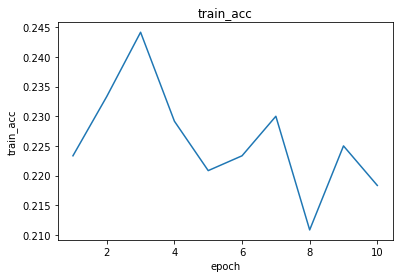

In [ ]:
simple_model.plot('train_acc')

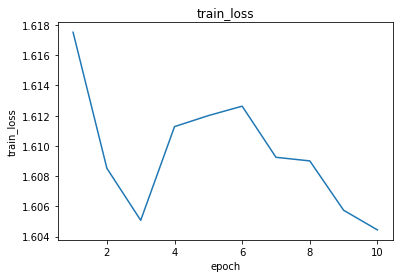

In [ ]:
simple_model.plot('train_loss')

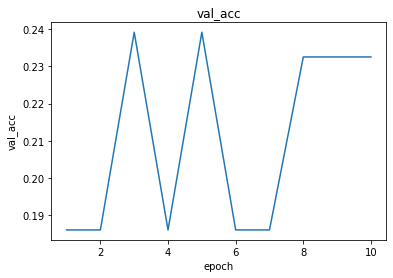

In [ ]:
simple_model.plot('val_acc')

# ResNet18 modified

In [ ]:
class Block(nn.Module):
    def __init__(self,input_channel, output_channel, kernel_size, stride=1, padding=0):
        super(Block,self).__init__()

        self.conv1=nn.Conv2d(input_channel,output_channel,kernel_size=kernel_size,padding=padding) # no stride
        self.conv2=nn.Conv2d(output_channel,output_channel,kernel_size=kernel_size,stride=stride,padding=padding) # stride if down sampling
        self.bn=nn.BatchNorm2d(output_channel)
        self.relu=nn.ReLU()

        self.layer=nn.Sequential(self.conv1, self.bn, self.relu, self.conv2, self.bn)

        self.stride=stride
        self.iden = nn.Conv2d(input_channel, output_channel, kernel_size=(1,1), stride=1)
        if input_channel==64:
            self.iden = nn.Conv2d(input_channel, output_channel, kernel_size=(1,1), stride=1)

    def forward(self,x):
        y = self.layer(x)
        if self.stride==1: # stride==2 인 경우는 downsampling 구간이기 때문에 residual 안함
            y = y + self.iden(x)
        y = self.relu(y)

        return y



class LeNet(nn.Module):
    def __init__(self,best_model_save_path="./best_model.pt"):
        super(LeNet,self).__init__()
        
        self.best_model_save_path = best_model_save_path

        self.conv1=nn.Conv2d(1,64,kernel_size=(6,7),stride=2,padding=3)
        self.maxpool=nn.MaxPool2d(kernel_size=(3,3),stride=2,padding=1)
        self.avgpool=nn.AdaptiveAvgPool2d((1,1)) # global avg pool
        self.relu=nn.ReLU()

        self.seq1=nn.Sequential(self.conv1,self.relu,self.maxpool)  # (1,100,501) -> (64,51,251).conv -> (64,25,126).maxpool
        self.seq2=nn.Sequential(Block(64,64,(3,3),padding=1),Block(64,64,(3,3),padding=1),Block(64,128,(3,4),stride=2,padding=1)) # (64,25,126) -> (64,25,126).block -> (64,25,126).block -> (128,13,63).block 
        self.seq3=nn.Sequential(Block(128,128,(3,3),padding=1),Block(128,128,(3,3),padding=1),Block(128,256,(3,3),stride=2,padding=1)) # (128,13,63) -> (128,13,63).block -> (128,13,63).block -> (256,7,32).block 
        self.seq4=nn.Sequential(Block(256,256,(3,3),padding=1),Block(256,256,(3,3),padding=1),self.avgpool) # (256,7,32) -> (256,7,32).block -> (256,7,32).block -> (256,1,1).avgpool

        self.fc=nn.Linear(256,5)

        # self.loss=nn.CrossEntropyLoss()
        # self.optimizer=optim.Adam(self.parameters(),lr=0.0001)

        self.train_accuracy = []
        self.train_loss = []
        self.val_accuracy = []
        self.val_loss = []

    def forward(self,x):       
        y=self.seq1(x)
        y=self.seq2(y)
        y=self.seq3(y)
        y=self.seq4(y)
        y=y.view(y.shape[0],-1)
        y=self.fc(y)
        return y

    # def train_(self, train_loader, val_loader, epochs, device):
    #     self.train_accuracy = []
    #     self.train_loss = []
    #     self.val_accuracy = []
    #     self.val_loss = []
    #     best_epoch = -1
    #     best_acc = -1 
        
    #     for epoch in range(1, epochs+1):
    #         total = 0
    #         correct = 0
    #         start_time = time.time()
    #         epoch_loss = 0.0
    #         epoch_acc = 0.0
    #         self.train()

    #         for batch_idx, (batch_data, batch_label) in enumerate(tqdm(train_loader)):
                
    #             spec, mfcc, chroma = batch_data
    #             mfcc= mfcc.to(device)
    #             # batch_data = (spec, mfcc, chroma)
    #             batch_label = batch_label.to(device)

    #             self.optimizer.zero_grad()

    #             pred = self.forward(mfcc) # (batch_size, 5)
    #             loss = self.loss(pred, batch_label)
    #             loss.backward()
    #             self.optimizer.step()

    #             epoch_loss += loss.item()

    #             _, pred_indices = torch.max(pred, axis=1)
    #             total += batch_data[0].shape[0]
    #             label = torch.max(batch_label, axis=1)[1]
    #             correct += pred_indices.eq(label).sum().item()
    #             # for p, l in zip(pred_indices, batch_label):
    #             #     print(f"predicted: {index2region[p.item()]} real:{index2region[l.item()]}")
            
    #         print(pred,batch_label) ############################################################################
    #         end_time = time.time()
    #         print(f"epoch {epoch} time: {end_time-start_time}sec(s).")


    #         epoch_loss /= len(LeNet_train_loader)
    #         self.train_loss.append(epoch_loss)
    #         epoch_acc = correct / total
    #         self.train_accuracy.append(epoch_acc)
    #         print(f"epoch {epoch} train accuracy: {epoch_acc}")
    #         print(f"epoch {epoch} loss: {epoch_loss}")  


    #         predicted, labels, val_loss = self.predict(val_loader, device)
            
    #         val_acc = predicted.eq(labels).sum().item() / len(predicted)
    #         print(f"epoch {epoch} val accuracy: {val_acc}")

    #         if val_acc > epoch_acc:
    #             best_acc = val_acc
    #             best_epoch = epoch
    #             torch.save(self.state_dict(), self.best_model_save_path)
            
    #         self.val_accuracy.append(val_acc)
    #         self.val_loss.append(val_loss)
            
            
            
    #     print("Finish!")
        
    #     return best_acc, best_epoch
            
    # def predict(self, test_loader, device):
    #     self.eval()
    #     labels = []
    #     predicted = []
    #     val_loss = 0.0
    #     with torch.no_grad():
    #         for batch_idx, (batch_data, batch_label) in enumerate(tqdm(test_loader)):

    #             spec, mfcc, chroma = batch_data
    #             mfcc= mfcc.to(device)
    #             # batch_data = (spec, mfcc, chroma)
    #             batch_label = batch_label.to(device)
                
    #             pred = self.forward(mfcc)

    #             _, pred_indices = torch.max(pred, axis=1)
    #             loss = self.loss(pred, batch_label)
                
    #             val_loss += loss.item()

    #             predicted.append(pred_indices)
    #             batch_label = torch.max(batch_label, axis=1)[1]
    #             labels.append(batch_label)
    #         print(pred,batch_label) ############################################################################
    #     val_loss /= len(test_loader)
    #     predicted = torch.cat(predicted, dim=0)
    #     labels = torch.cat(labels, dim=0)

    #     return predicted, labels, val_loss
    
    # def plot(self, which):
        
    #     X = [i for i in range(1, len(self.train_accuracy) + 1)]
    #     if which=='train_loss':
    #         y = self.train_loss
    #     elif which=='train_acc':
    #         y = self.train_accuracy
    #     elif which=='val_acc':
    #         y = self.val_accuracy
    #     elif which=='val_loss':
    #         y = self.val_loss

    #     plt.xlabel("epoch")
    #     plt.ylabel(which)
    #     plt.title(which)
    #     plt.plot(X, y, label="Train loss")
    #     plt.savefig(f"./model_{which}.png")
    #     plt.show()


In [ ]:
simple_model = LeNet().to(device)

loss_f=nn.CrossEntropyLoss()
optimizer=optim.Adam(simple_model.parameters(),lr=0.0001)
epochs=30

In [ ]:
train_size = int(len(dataset)*0.8)
test_size = len(dataset) - train_size

LeNet_train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
LeNet_test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
# train
def train(model):
    best_epoch = -1
    best_acc = -1 

    for epoch in range(1, epochs+1):
        total = 0
        correct = 0
        start_time = time.time()
        epoch_loss = 0.0
        epoch_acc = 0.0
        model.train()

        for batch_idx, (batch_data, batch_label) in enumerate(tqdm(LeNet_train_loader)):
            
            spec, mfcc, chroma = batch_data
            mfcc= mfcc.to(device)
            # batch_data = (spec, mfcc, chroma)
            batch_label = batch_label.to(device)

            optimizer.zero_grad()

            pred = model(mfcc) # (batch_size, 5)
            loss = loss_f(pred, batch_label)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            _, pred_indices = torch.max(pred, axis=1)
            total += batch_data[0].shape[0]
            label = torch.max(batch_label, axis=1)[1]
            correct += pred_indices.eq(label).sum().item()
            # for p, l in zip(pred_indices, batch_label):
            #     print(f"predicted: {index2region[p.item()]} real:{index2region[l.item()]}")
        
        print(pred_indices,label) ############################################################################
        end_time = time.time()
        print(f"epoch {epoch} time: {end_time-start_time}sec(s).")

        epoch_loss /= len(LeNet_train_loader)
        model.train_loss.append(epoch_loss)
        epoch_acc = correct / total
        model.train_accuracy.append(epoch_acc)
        print(f"epoch {epoch} train accuracy: {epoch_acc}")
        print(f"epoch {epoch} loss: {epoch_loss}")  

        # predicted, labels, val_loss = model.predict(LeNet_test_loader, device)
        
        # val_acc = predicted.eq(labels).sum().item() / len(predicted)
        # print(f"epoch {epoch} val accuracy: {val_acc}")

        # if val_acc > epoch_acc:
        #     best_acc = val_acc
        #     best_epoch = epoch
        #     torch.save(model.state_dict(), model.best_model_save_path)
        
        # model.val_accuracy.append(val_acc)
        # model.val_loss.append(val_loss)
        
    print("Finish!")

In [ ]:
train(simple_model)

100%|██████████| 38/38 [00:07<00:00,  5.13it/s]


tensor([3, 4, 4, 0, 0, 0, 2, 0, 3, 4, 4, 2, 1, 1, 4, 4], device='cuda:0') tensor([3, 4, 2, 0, 0, 0, 2, 0, 3, 4, 2, 2, 1, 1, 4, 4], device='cuda:0')
epoch 1 time: 7.413542747497559sec(s).
epoch 1 train accuracy: 0.7075
epoch 1 loss: 0.7255770987585971


100%|██████████| 38/38 [00:07<00:00,  5.20it/s]


tensor([3, 1, 1, 2, 4, 4, 1, 0, 4, 2, 1, 0, 3, 2, 0, 0], device='cuda:0') tensor([3, 1, 1, 2, 4, 4, 1, 0, 4, 2, 1, 0, 3, 2, 0, 0], device='cuda:0')
epoch 2 time: 7.321842193603516sec(s).
epoch 2 train accuracy: 0.89
epoch 2 loss: 0.32372593252282394


100%|██████████| 38/38 [00:07<00:00,  5.18it/s]


tensor([3, 0, 0, 1, 4, 0, 4, 3, 2, 4, 4, 3, 3, 3, 2, 0], device='cuda:0') tensor([3, 0, 0, 1, 4, 0, 4, 3, 1, 4, 3, 3, 3, 3, 1, 0], device='cuda:0')
epoch 3 time: 7.3462300300598145sec(s).
epoch 3 train accuracy: 0.9416666666666667
epoch 3 loss: 0.18368849207304025


100%|██████████| 38/38 [00:07<00:00,  5.15it/s]


tensor([3, 2, 2, 4, 0, 3, 4, 0, 1, 3, 1, 1, 3, 3, 3, 4], device='cuda:0') tensor([3, 2, 2, 4, 0, 3, 4, 0, 4, 3, 4, 1, 3, 3, 3, 4], device='cuda:0')
epoch 4 time: 7.389354467391968sec(s).
epoch 4 train accuracy: 0.9416666666666667
epoch 4 loss: 0.17890713657987745


100%|██████████| 38/38 [00:07<00:00,  5.18it/s]


tensor([4, 4, 3, 1, 2, 2, 0, 0, 2, 1, 0, 1, 1, 0, 4, 0], device='cuda:0') tensor([0, 4, 3, 1, 2, 2, 0, 0, 2, 1, 0, 1, 1, 0, 4, 0], device='cuda:0')
epoch 5 time: 7.349825620651245sec(s).
epoch 5 train accuracy: 0.9508333333333333
epoch 5 loss: 0.14570066862200437


100%|██████████| 38/38 [00:07<00:00,  5.18it/s]


tensor([0, 1, 3, 1, 0, 4, 1, 0, 4, 2, 2, 0, 3, 4, 3, 2], device='cuda:0') tensor([0, 1, 3, 1, 0, 4, 1, 0, 4, 2, 2, 0, 3, 4, 3, 1], device='cuda:0')
epoch 6 time: 7.352017641067505sec(s).
epoch 6 train accuracy: 0.9708333333333333
epoch 6 loss: 0.09105697813394822


100%|██████████| 38/38 [00:07<00:00,  5.17it/s]


tensor([0, 4, 3, 0, 3, 0, 2, 0, 2, 1, 2, 3, 1, 0, 0, 4], device='cuda:0') tensor([0, 4, 3, 0, 3, 0, 2, 0, 2, 1, 2, 3, 1, 0, 0, 4], device='cuda:0')
epoch 7 time: 7.363414525985718sec(s).
epoch 7 train accuracy: 0.9791666666666666
epoch 7 loss: 0.08635809583785503


100%|██████████| 38/38 [00:07<00:00,  5.11it/s]


tensor([1, 1, 1, 1, 2, 1, 2, 4, 3, 0, 3, 1, 3, 4, 0, 2], device='cuda:0') tensor([1, 1, 1, 1, 2, 1, 2, 4, 3, 0, 3, 1, 3, 4, 0, 2], device='cuda:0')
epoch 8 time: 7.446955680847168sec(s).
epoch 8 train accuracy: 0.9725
epoch 8 loss: 0.0755304847843945


100%|██████████| 38/38 [00:07<00:00,  5.13it/s]


tensor([0, 3, 2, 4, 3, 0, 4, 4, 0, 3, 1, 0, 1, 1, 3, 0], device='cuda:0') tensor([0, 3, 2, 4, 3, 0, 4, 0, 0, 3, 1, 0, 1, 1, 3, 0], device='cuda:0')
epoch 9 time: 7.427153587341309sec(s).
epoch 9 train accuracy: 0.9925
epoch 9 loss: 0.03613923630358553


100%|██████████| 38/38 [00:07<00:00,  5.17it/s]


tensor([4, 0, 4, 2, 3, 1, 0, 3, 2, 1, 0, 3, 4, 0, 1, 1], device='cuda:0') tensor([4, 0, 4, 2, 3, 1, 0, 3, 2, 1, 0, 3, 4, 0, 1, 1], device='cuda:0')
epoch 10 time: 7.368048191070557sec(s).
epoch 10 train accuracy: 0.9858333333333333
epoch 10 loss: 0.05190029063899266


100%|██████████| 38/38 [00:07<00:00,  5.15it/s]


tensor([4, 4, 4, 3, 2, 0, 2, 2, 4, 3, 3, 3, 4, 2, 4, 1], device='cuda:0') tensor([4, 4, 4, 3, 2, 0, 2, 2, 4, 3, 3, 3, 4, 2, 4, 1], device='cuda:0')
epoch 11 time: 7.387861728668213sec(s).
epoch 11 train accuracy: 0.9958333333333333
epoch 11 loss: 0.018934697831833835


100%|██████████| 38/38 [00:07<00:00,  5.14it/s]


tensor([4, 2, 3, 3, 2, 2, 2, 1, 0, 0, 2, 3, 1, 3, 3, 2], device='cuda:0') tensor([2, 2, 3, 3, 2, 2, 2, 1, 0, 0, 2, 3, 1, 3, 3, 2], device='cuda:0')
epoch 12 time: 7.411089897155762sec(s).
epoch 12 train accuracy: 0.9908333333333333
epoch 12 loss: 0.041333576492769156


100%|██████████| 38/38 [00:07<00:00,  5.13it/s]


tensor([4, 4, 3, 1, 0, 1, 3, 1, 0, 0, 0, 4, 2, 3, 0, 3], device='cuda:0') tensor([4, 4, 3, 1, 0, 1, 3, 1, 0, 0, 0, 4, 2, 3, 0, 3], device='cuda:0')
epoch 13 time: 7.42656397819519sec(s).
epoch 13 train accuracy: 0.995
epoch 13 loss: 0.024465488784603383


100%|██████████| 38/38 [00:07<00:00,  5.13it/s]


tensor([3, 3, 0, 4, 2, 3, 2, 2, 4, 0, 2, 1, 1, 4, 3, 3], device='cuda:0') tensor([3, 3, 0, 4, 2, 3, 2, 2, 4, 0, 2, 1, 1, 4, 3, 3], device='cuda:0')
epoch 14 time: 7.424247741699219sec(s).
epoch 14 train accuracy: 0.9933333333333333
epoch 14 loss: 0.02076763533190579


100%|██████████| 38/38 [00:07<00:00,  5.12it/s]


tensor([0, 3, 4, 0, 4, 3, 1, 0, 4, 2, 1, 3, 3, 3, 1, 2], device='cuda:0') tensor([0, 3, 4, 0, 4, 3, 1, 0, 4, 2, 1, 3, 3, 3, 1, 2], device='cuda:0')
epoch 15 time: 7.427255392074585sec(s).
epoch 15 train accuracy: 0.9933333333333333
epoch 15 loss: 0.022711293710591763


100%|██████████| 38/38 [00:07<00:00,  5.11it/s]


tensor([3, 2, 2, 4, 3, 0, 0, 2, 2, 4, 1, 0, 3, 1, 1, 4], device='cuda:0') tensor([3, 2, 2, 4, 3, 0, 0, 2, 2, 4, 1, 0, 3, 1, 1, 4], device='cuda:0')
epoch 16 time: 7.452739953994751sec(s).
epoch 16 train accuracy: 0.9891666666666666
epoch 16 loss: 0.02503452092825778


100%|██████████| 38/38 [00:07<00:00,  5.13it/s]


tensor([3, 0, 4, 3, 3, 1, 3, 0, 1, 0, 3, 1, 3, 4, 0, 2], device='cuda:0') tensor([3, 0, 4, 3, 3, 1, 3, 0, 4, 0, 3, 1, 3, 4, 0, 2], device='cuda:0')
epoch 17 time: 7.413309574127197sec(s).
epoch 17 train accuracy: 0.9858333333333333
epoch 17 loss: 0.0428568295288929


100%|██████████| 38/38 [00:07<00:00,  5.09it/s]


tensor([3, 0, 1, 3, 4, 3, 3, 3, 3, 1, 1, 2, 0, 0, 0, 4], device='cuda:0') tensor([3, 0, 1, 3, 4, 3, 3, 3, 3, 1, 1, 2, 0, 0, 0, 4], device='cuda:0')
epoch 18 time: 7.47619891166687sec(s).
epoch 18 train accuracy: 0.9866666666666667
epoch 18 loss: 0.05782534209643736


100%|██████████| 38/38 [00:07<00:00,  5.10it/s]


tensor([4, 0, 4, 0, 2, 3, 3, 1, 3, 1, 3, 1, 0, 2, 3, 2], device='cuda:0') tensor([4, 0, 4, 0, 2, 3, 3, 1, 3, 1, 3, 1, 0, 2, 3, 2], device='cuda:0')
epoch 19 time: 7.465691804885864sec(s).
epoch 19 train accuracy: 0.985
epoch 19 loss: 0.04469255591424084


100%|██████████| 38/38 [00:07<00:00,  5.08it/s]


tensor([0, 4, 1, 3, 4, 4, 0, 1, 4, 1, 1, 4, 2, 4, 3, 1], device='cuda:0') tensor([0, 4, 1, 3, 4, 4, 0, 1, 4, 1, 1, 4, 2, 4, 3, 1], device='cuda:0')
epoch 20 time: 7.488240480422974sec(s).
epoch 20 train accuracy: 0.9891666666666666
epoch 20 loss: 0.03242380467341527


100%|██████████| 38/38 [00:07<00:00,  5.10it/s]


tensor([1, 2, 2, 3, 3, 3, 4, 0, 2, 4, 3, 3, 0, 4, 2, 0], device='cuda:0') tensor([4, 2, 2, 3, 3, 3, 4, 0, 2, 4, 3, 3, 0, 4, 2, 0], device='cuda:0')
epoch 21 time: 7.455611944198608sec(s).
epoch 21 train accuracy: 0.995
epoch 21 loss: 0.014670014188404343


100%|██████████| 38/38 [00:07<00:00,  5.11it/s]


tensor([1, 2, 0, 4, 3, 2, 0, 2, 2, 0, 2, 3, 4, 0, 2, 3], device='cuda:0') tensor([1, 2, 0, 4, 3, 2, 0, 2, 2, 0, 2, 3, 4, 0, 2, 3], device='cuda:0')
epoch 22 time: 7.44478178024292sec(s).
epoch 22 train accuracy: 0.9933333333333333
epoch 22 loss: 0.025485080685221442


100%|██████████| 38/38 [00:07<00:00,  5.08it/s]


tensor([2, 3, 0, 2, 1, 0, 4, 0, 4, 0, 0, 0, 0, 0, 3, 1], device='cuda:0') tensor([2, 3, 0, 2, 1, 0, 4, 0, 0, 0, 0, 0, 0, 0, 3, 1], device='cuda:0')
epoch 23 time: 7.487400054931641sec(s).
epoch 23 train accuracy: 0.9916666666666667
epoch 23 loss: 0.02246826115266518


100%|██████████| 38/38 [00:07<00:00,  5.05it/s]


tensor([4, 1, 0, 1, 1, 2, 4, 3, 0, 1, 3, 1, 0, 2, 0, 3], device='cuda:0') tensor([4, 1, 0, 1, 1, 2, 4, 3, 0, 1, 3, 1, 0, 2, 0, 3], device='cuda:0')
epoch 24 time: 7.543104648590088sec(s).
epoch 24 train accuracy: 0.9908333333333333
epoch 24 loss: 0.028269738200929408


100%|██████████| 38/38 [00:07<00:00,  5.09it/s]


tensor([2, 1, 0, 1, 2, 2, 3, 0, 1, 1, 1, 2, 1, 3, 0, 4], device='cuda:0') tensor([2, 1, 0, 1, 2, 2, 3, 0, 1, 1, 1, 2, 1, 3, 0, 4], device='cuda:0')
epoch 25 time: 7.480605363845825sec(s).
epoch 25 train accuracy: 0.9975
epoch 25 loss: 0.011242310437266593


100%|██████████| 38/38 [00:07<00:00,  5.05it/s]


tensor([0, 0, 3, 3, 2, 1, 3, 3, 0, 3, 4, 1, 4, 0, 3, 2], device='cuda:0') tensor([0, 0, 3, 3, 2, 1, 3, 3, 0, 3, 4, 1, 4, 0, 3, 2], device='cuda:0')
epoch 26 time: 7.545835971832275sec(s).
epoch 26 train accuracy: 0.9983333333333333
epoch 26 loss: 0.005818516627569855


100%|██████████| 38/38 [00:07<00:00,  5.09it/s]


tensor([4, 3, 0, 2, 0, 2, 0, 3, 3, 0, 1, 1, 0, 0, 0, 1], device='cuda:0') tensor([4, 3, 0, 2, 0, 2, 0, 3, 3, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
epoch 27 time: 7.474952936172485sec(s).
epoch 27 train accuracy: 0.9983333333333333
epoch 27 loss: 0.017055443990868394


100%|██████████| 38/38 [00:07<00:00,  5.08it/s]


tensor([2, 0, 0, 4, 1, 3, 2, 0, 1, 0, 0, 4, 3, 0, 2, 0], device='cuda:0') tensor([2, 0, 0, 4, 1, 3, 2, 0, 1, 0, 0, 4, 3, 0, 2, 0], device='cuda:0')
epoch 28 time: 7.4961326122283936sec(s).
epoch 28 train accuracy: 0.9975
epoch 28 loss: 0.008286241481791398


100%|██████████| 38/38 [00:07<00:00,  5.03it/s]


tensor([2, 3, 2, 4, 1, 2, 2, 4, 4, 1, 1, 0, 2, 2, 0, 2], device='cuda:0') tensor([2, 3, 2, 4, 1, 2, 2, 4, 4, 1, 1, 0, 2, 2, 0, 2], device='cuda:0')
epoch 29 time: 7.562259197235107sec(s).
epoch 29 train accuracy: 0.9991666666666666
epoch 29 loss: 0.005162872154247261


100%|██████████| 38/38 [00:07<00:00,  5.06it/s]

tensor([3, 0, 1, 1, 3, 2, 0, 1, 0, 4, 3, 4, 3, 2, 4, 3], device='cuda:0') tensor([3, 0, 1, 1, 3, 2, 0, 1, 0, 4, 3, 4, 3, 2, 4, 3], device='cuda:0')
epoch 30 time: 7.521728038787842sec(s).
epoch 30 train accuracy: 0.9983333333333333
epoch 30 loss: 0.006850849011817972
Finish!


In [ ]:
# predict
def predict(model,test_loader):
    model.eval()
    labels = []
    predicted = []
    val_loss = 0.0
    # with torch.no_grad():
    for batch_idx, (batch_data, batch_label) in enumerate(tqdm(test_loader)):

        spec, mfcc, chroma = batch_data
        mfcc= mfcc.to(device)
        # batch_data = (spec, mfcc, chroma)
        batch_label = batch_label.to(device)
        
        pred = model(mfcc)

        _, pred_indices = torch.max(pred, axis=1)
        loss = loss_f(pred, batch_label)
        
        val_loss += loss.item()

        predicted.append(pred_indices)
        batch_label = torch.max(batch_label, axis=1)[1]
        labels.append(batch_label)
    print(pred,batch_label) ############################################################################ 
    eq = sum([sum(predicted[i]==labels[i]) for i in range(len(predicted))])
    total = len(predicted)*len(predicted[0])
    val_acc = eq / total
    print(f"\nval accuracy: {val_acc}")

    # if val_acc > epoch_acc:
    #     best_acc = val_acc
    #     best_epoch = epoch
    #     torch.save(model.state_dict(), model.best_model_save_path)
    
    model.val_accuracy.append(val_acc)
    model.val_loss.append(val_loss)  ###############여기까지 with

    val_loss /= len(test_loader)
    predicted = torch.cat(predicted, dim=0)
    labels = torch.cat(labels, dim=0)


In [ ]:
predict(simple_model,LeNet_train_loader)

100%|██████████| 38/38 [00:03<00:00,  9.51it/s]

tensor([[-4.6813, -4.5436,  0.4868,  4.0800, -0.1451],
        [-5.0183, -4.7935,  0.6023,  4.1495,  0.0516],
        [-4.8272, -4.6506,  0.3398,  4.3183, -0.1303],
        [-4.6204, -4.4798,  0.3640,  4.1219, -0.1411],
        [-4.9460, -4.7034,  0.5232,  4.1150,  0.0936],
        [-5.0319, -4.7538,  0.3306,  4.3435,  0.1009],
        [-4.4758, -4.4330,  0.3556,  4.1675, -0.3652],
        [-4.6243, -4.4987,  0.3646,  4.1765, -0.2172],
        [-4.6719, -4.5105,  0.3274,  4.1893, -0.1347],
        [-4.8343, -4.6900,  0.6174,  4.0970, -0.1227],
        [-5.0153, -4.8184,  0.6402,  4.1747, -0.0336],
        [-4.6203, -4.5407,  0.5864,  4.0485, -0.2951],
        [-5.1804, -4.9447,  0.8805,  3.9934,  0.1590],
        [-4.5943, -4.5039,  0.3594,  4.2197, -0.2994],
        [-4.7360, -4.5480,  0.3754,  4.1536, -0.0606],
        [-4.7335, -4.5946,  0.3253,  4.3284, -0.2450]], device='cuda:0',
       grad_fn=<AddmmBackward0>) tensor([1, 3, 4, 1, 1, 0, 4, 2, 2, 3, 3, 4, 3, 4, 1, 4], device='cuda

In [ ]:
# Plot
def plot(model,which):
    X = [i for i in range(1, len(model.train_accuracy) + 1)]
    if which=='train_loss':
        y = model.train_loss
    elif which=='train_acc':
        y = model.train_accuracy
    elif which=='val_acc':
        y = model.val_accuracy
    elif which=='val_loss':
        y = model.val_loss

    plt.xlabel("epoch")
    plt.ylabel(which)
    plt.title(which)
    plt.plot(X, y, label="Train loss")
    plt.savefig(f"./model_{which}.png")
    plt.show()

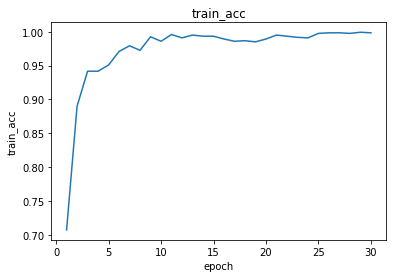

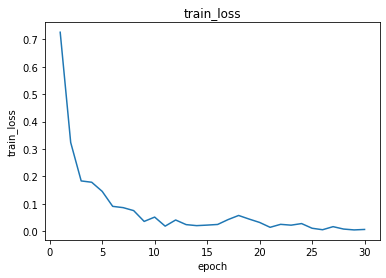

In [ ]:
# plt.figure(figsize=(8,6))

# plt.subplot(1,3,1)
plot(simple_model,'train_acc')

# plt.subplot(1,3,2)
plot(simple_model,'train_loss')

# plt.subplot(1,3,3)
# plot(simple_model,'val_acc')

plt.show()

In [ ]:
#extract the filter map of the convolution layer
filter_map = []
for param in list(simple_model.parameters()):
  if param.dim() == 4:
    print(param.shape)
    filter_map.append(param)

torch.Size([64, 1, 6, 7])
torch.Size([64, 64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64, 64, 1, 1])
torch.Size([64, 64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64, 64, 1, 1])
torch.Size([128, 64, 3, 4])
torch.Size([128, 128, 3, 4])
torch.Size([128, 64, 1, 1])
torch.Size([128, 128, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([128, 128, 1, 1])
torch.Size([128, 128, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([128, 128, 1, 1])
torch.Size([256, 128, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([256, 128, 1, 1])
torch.Size([256, 256, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([256, 256, 1, 1])
torch.Size([256, 256, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([256, 256, 1, 1])


# Visualize Filter

In [ ]:
#Make the function for feature map visualization
#tensor = (input filter), ch = (channel of filter you want to see)
from torchvision import utils
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
  n,c,w,h = tensor.shape

  if allkernels: 
    tensor = tensor.view(n*c, -1, w, h)
  elif c != 3: 
    tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
    
  rows = np.min((tensor.shape[0] // nrow + 1, 64))    
  grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
  plt.figure( figsize=(nrow,rows) )
  plt.imshow(grid.numpy().transpose((1, 2, 0)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


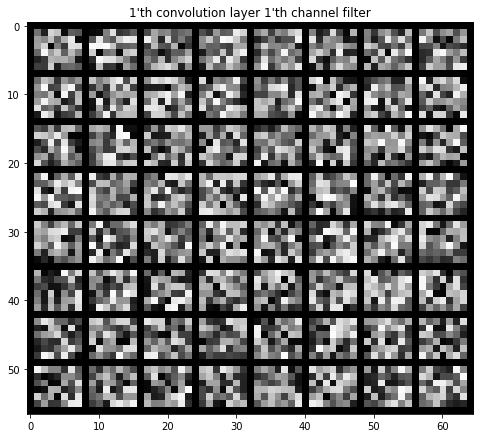

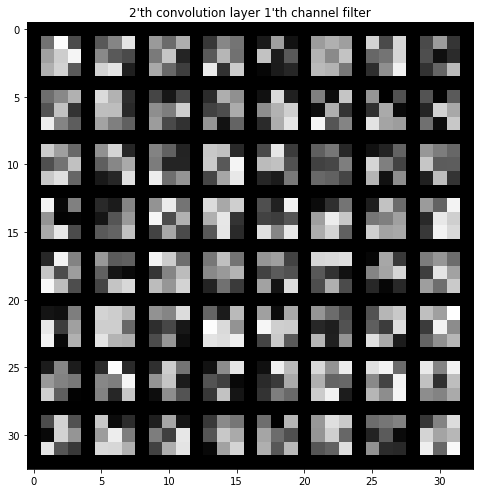

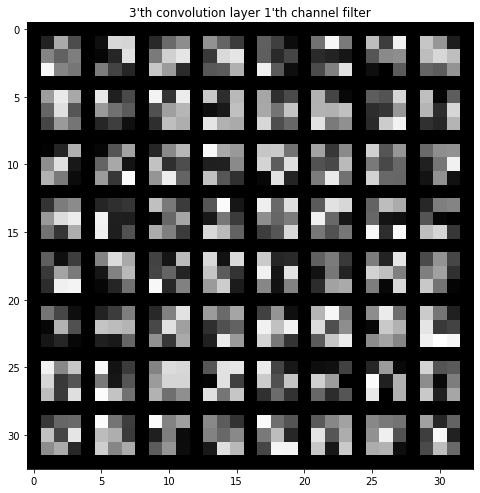

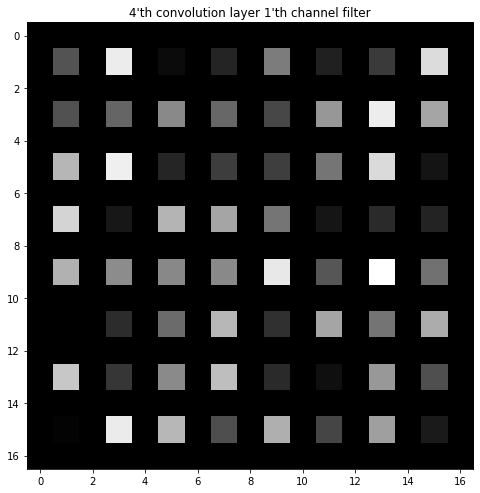

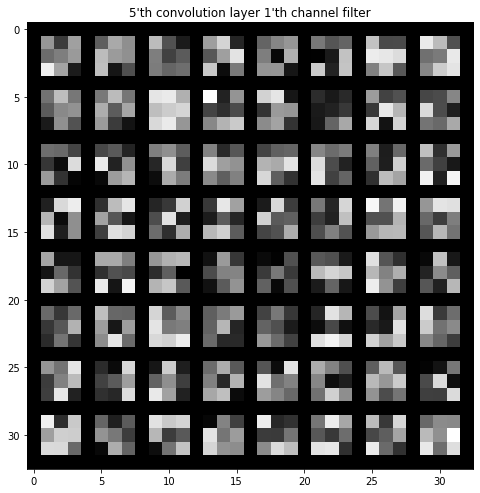

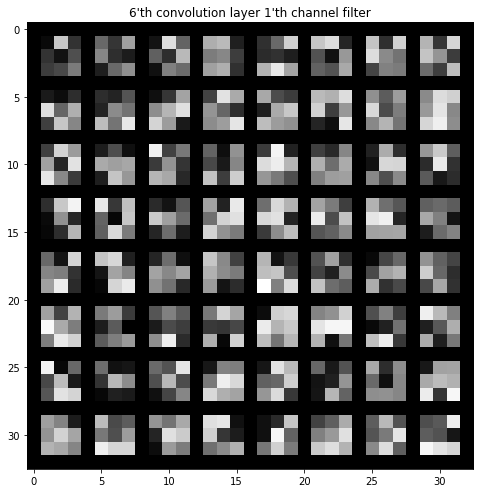

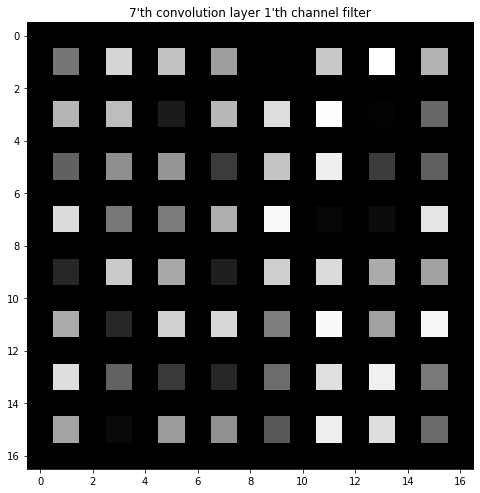

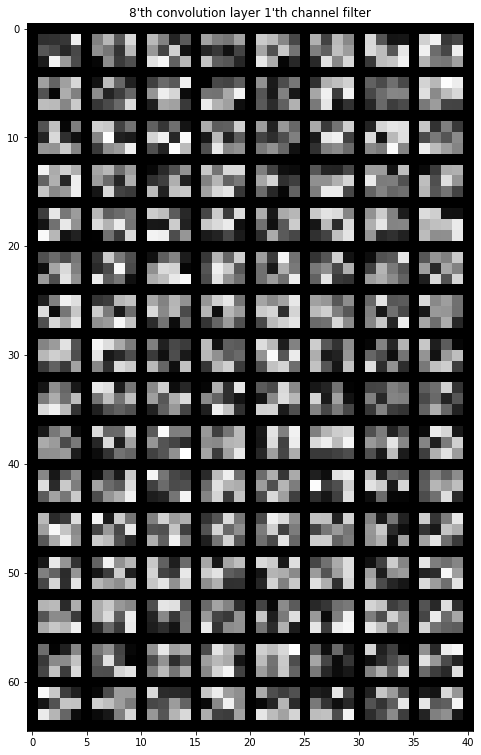

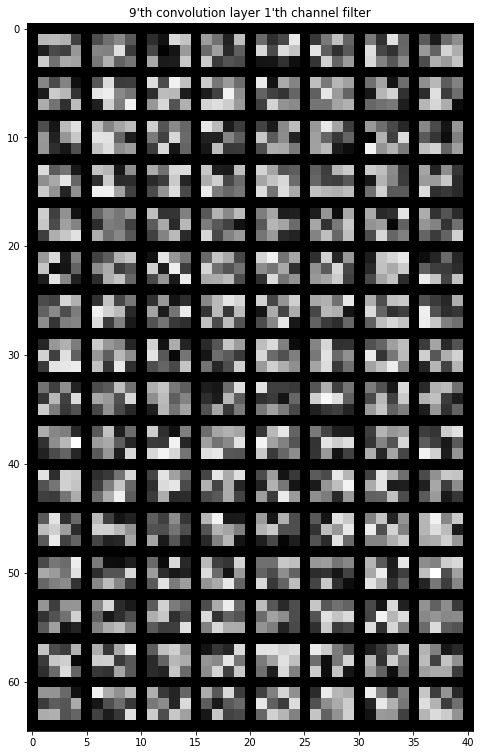

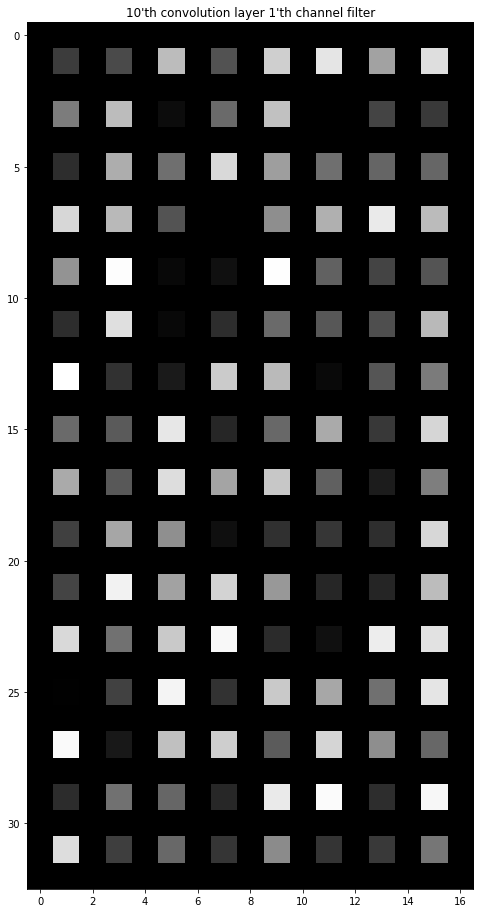

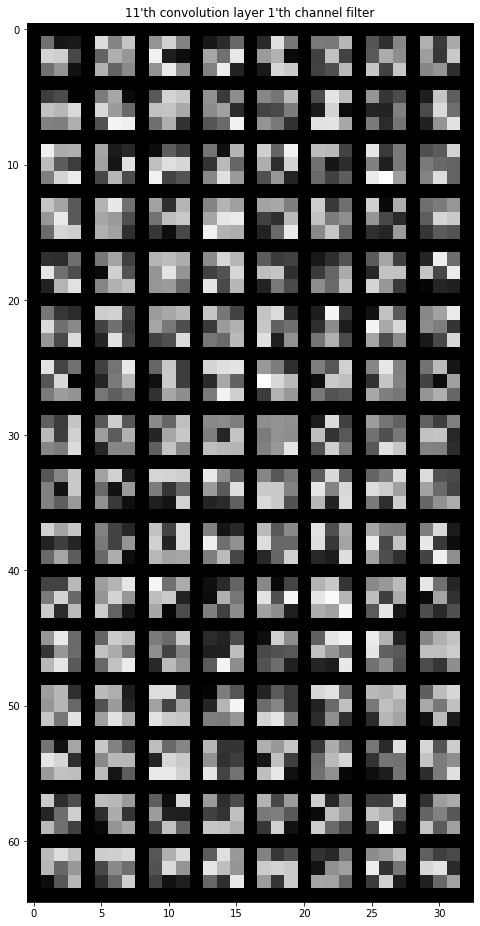

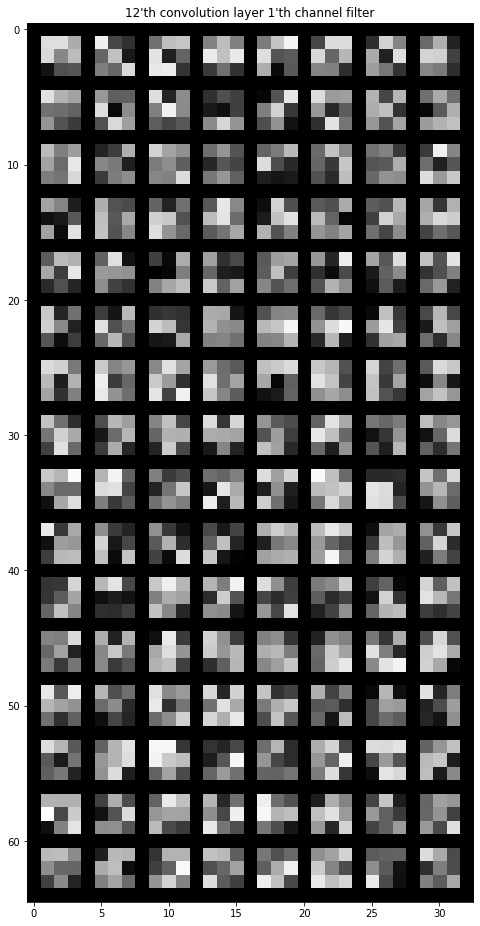

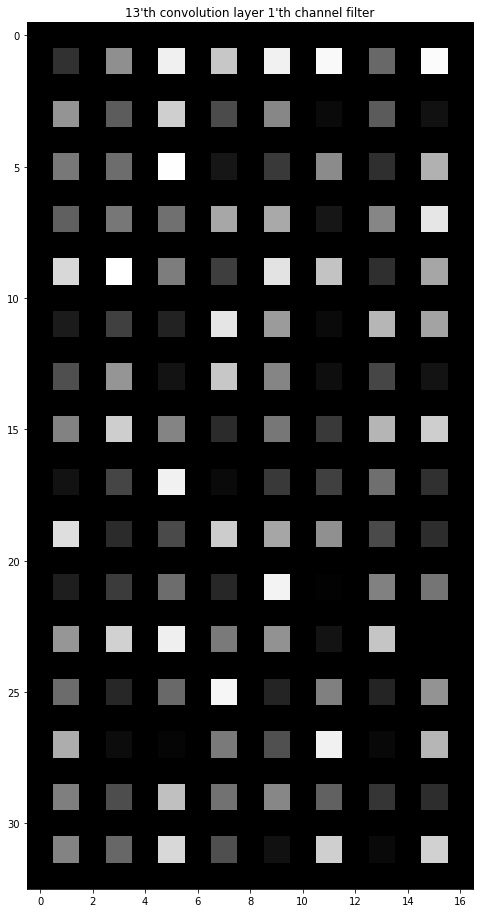

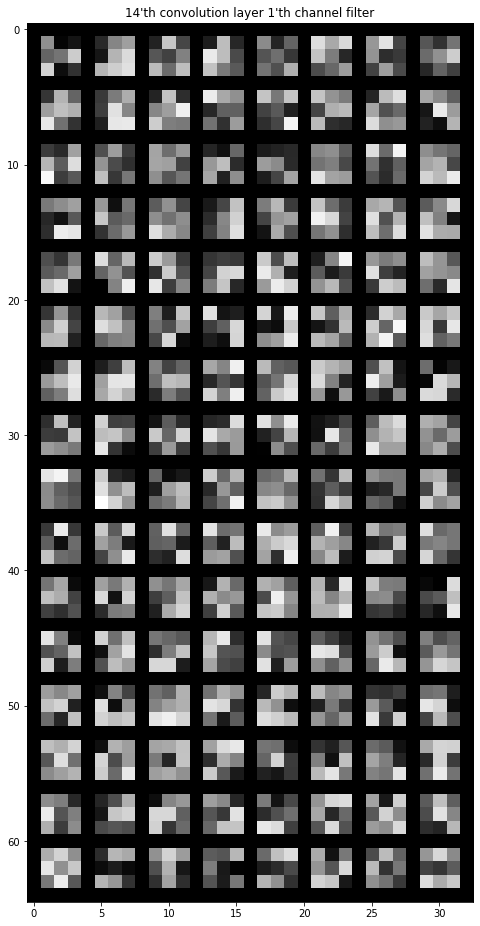

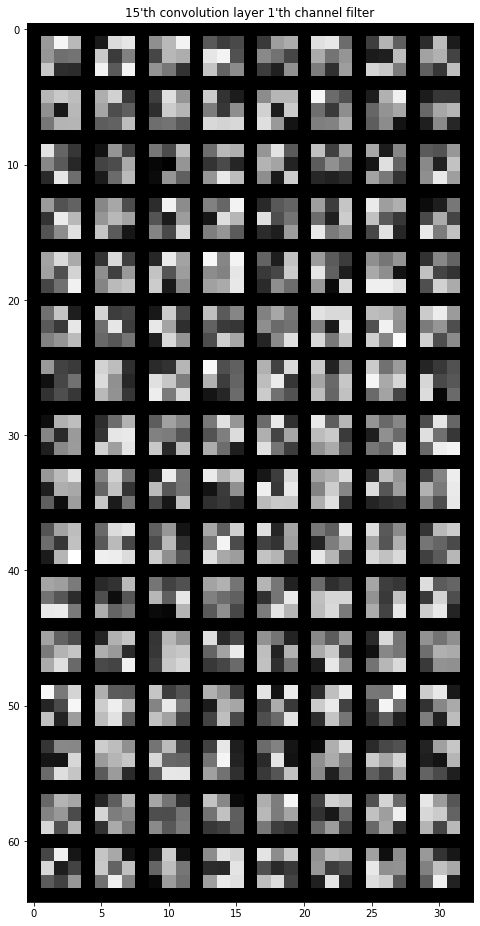

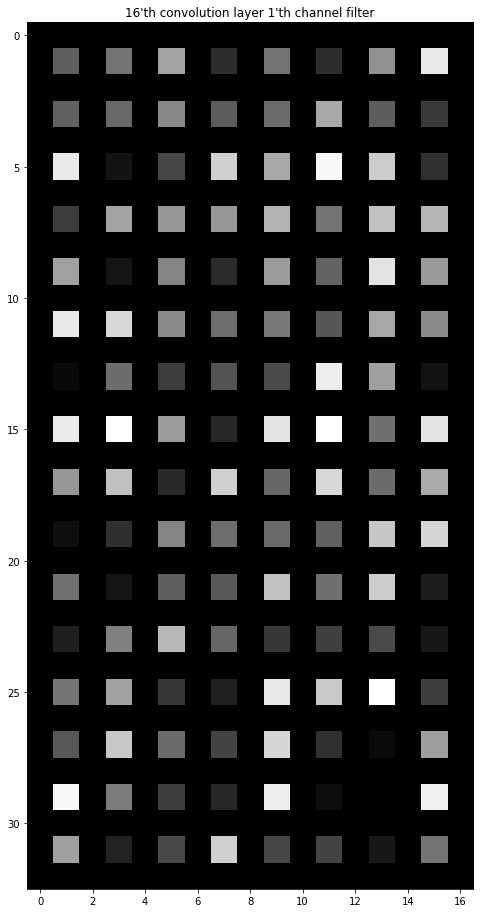

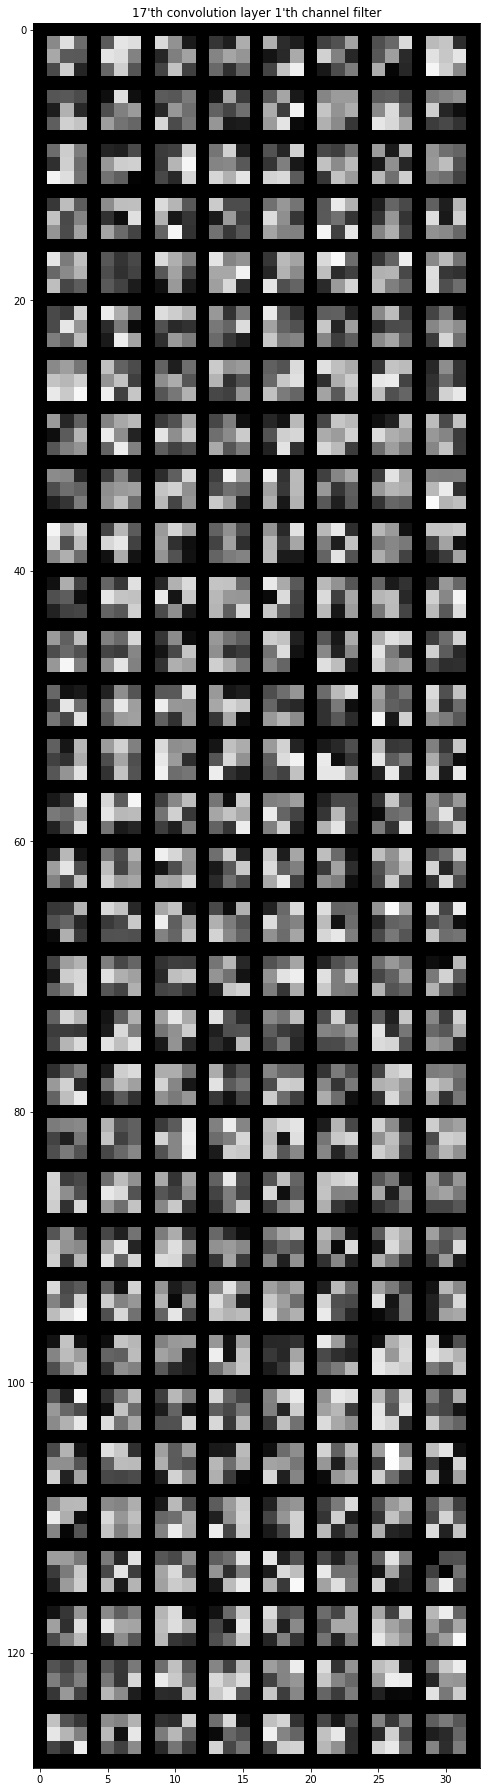

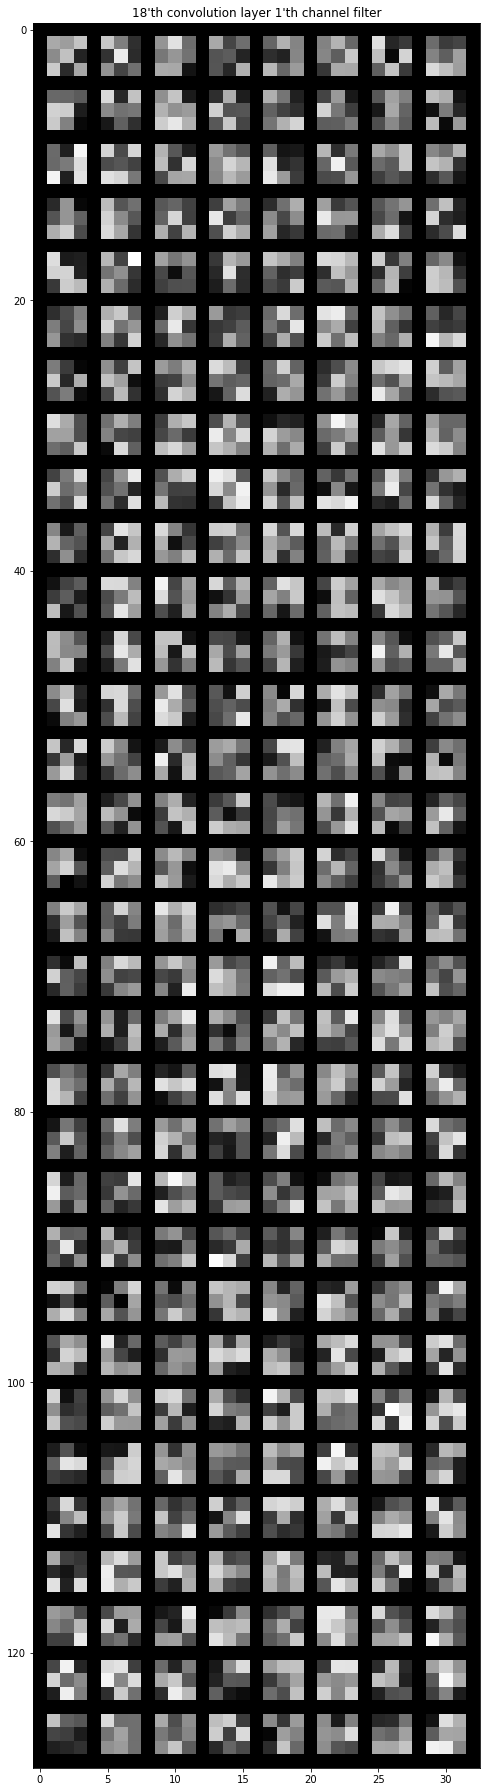

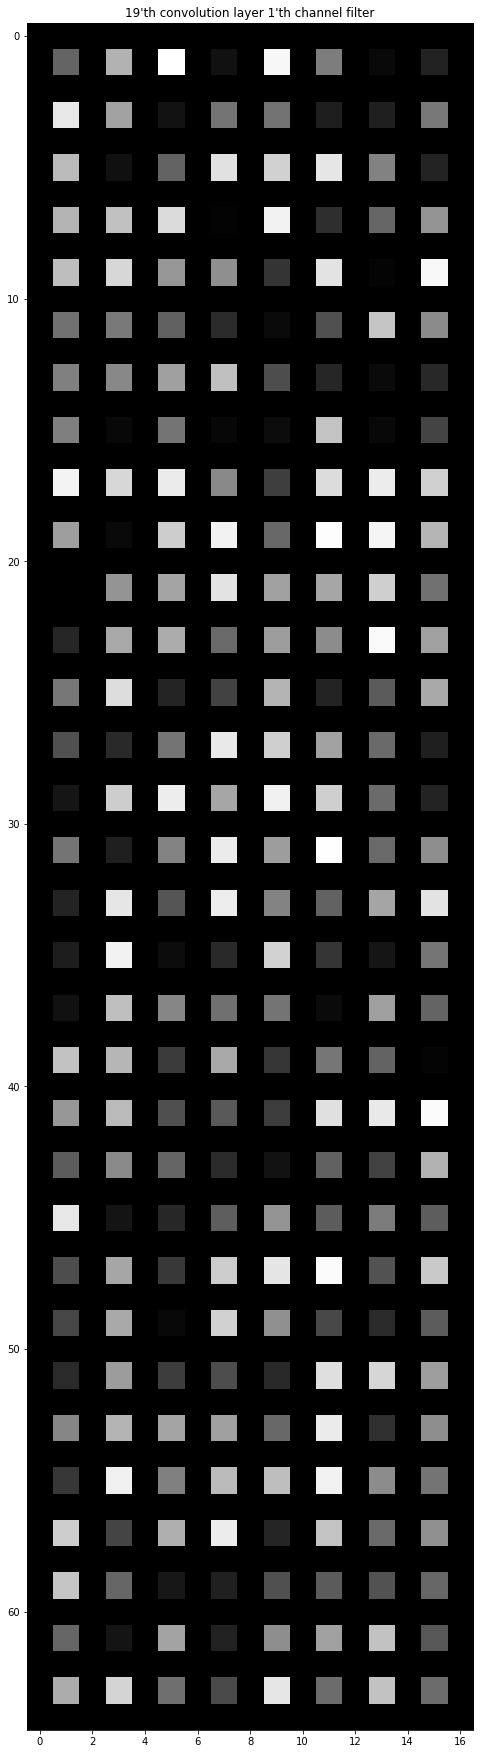

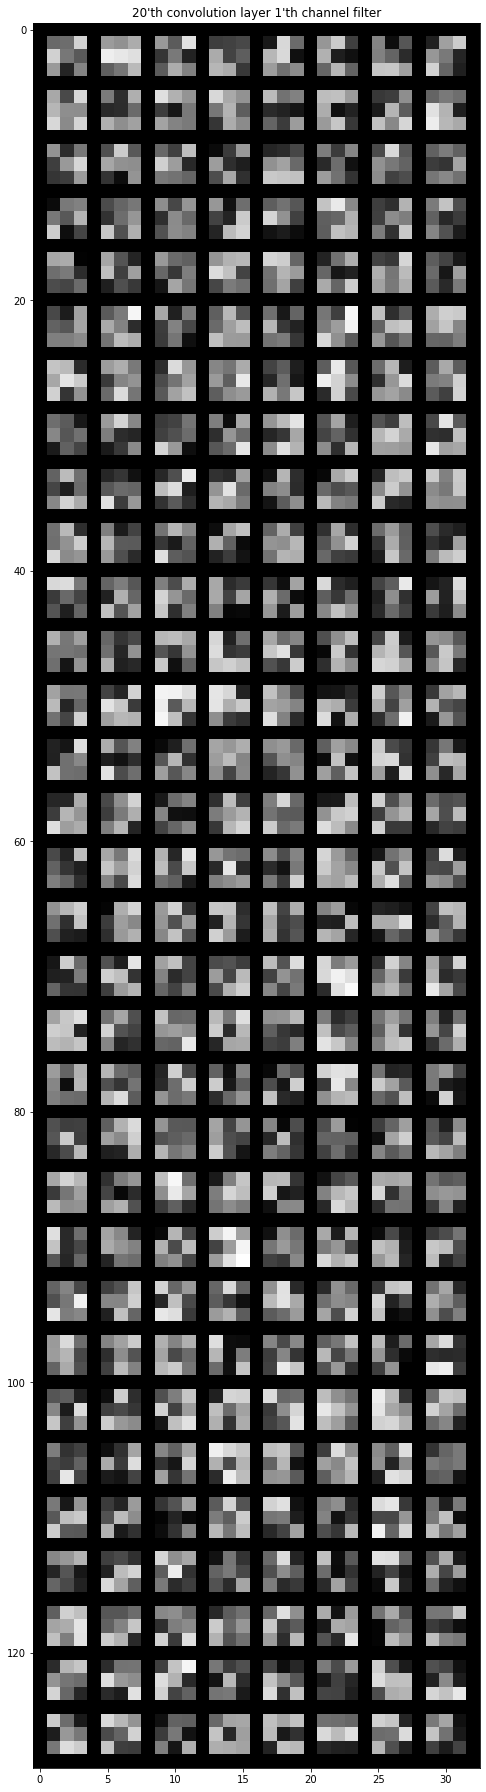

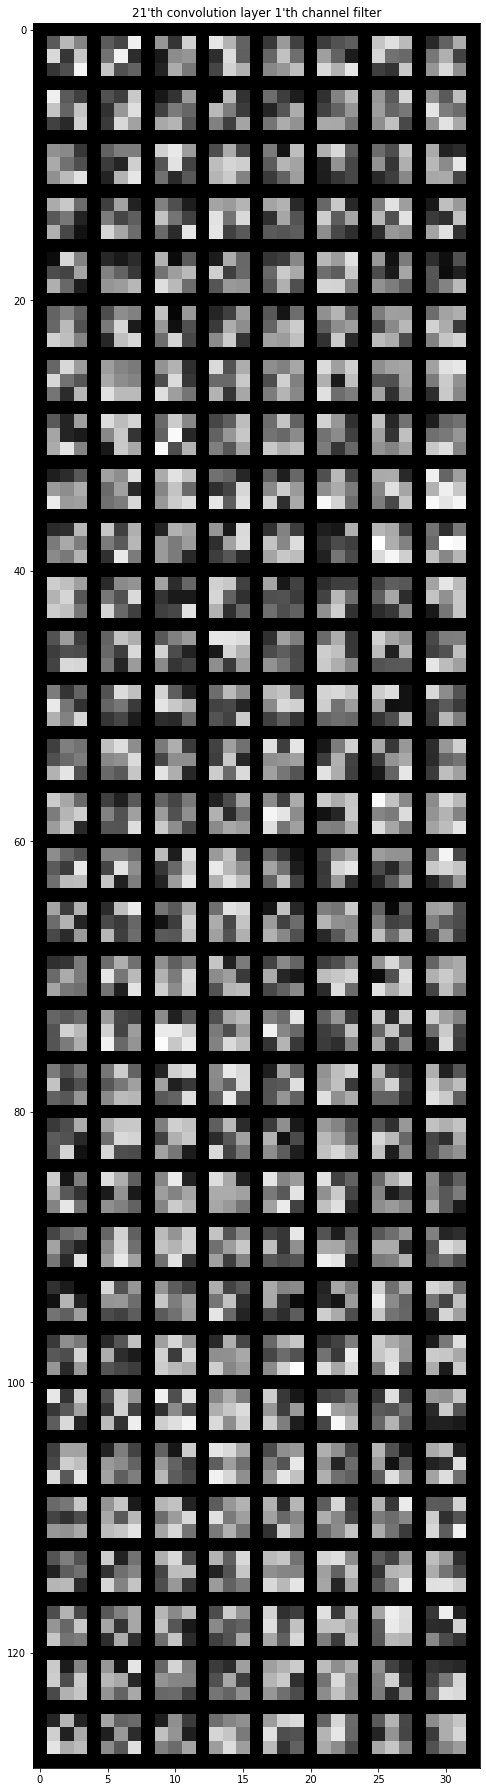

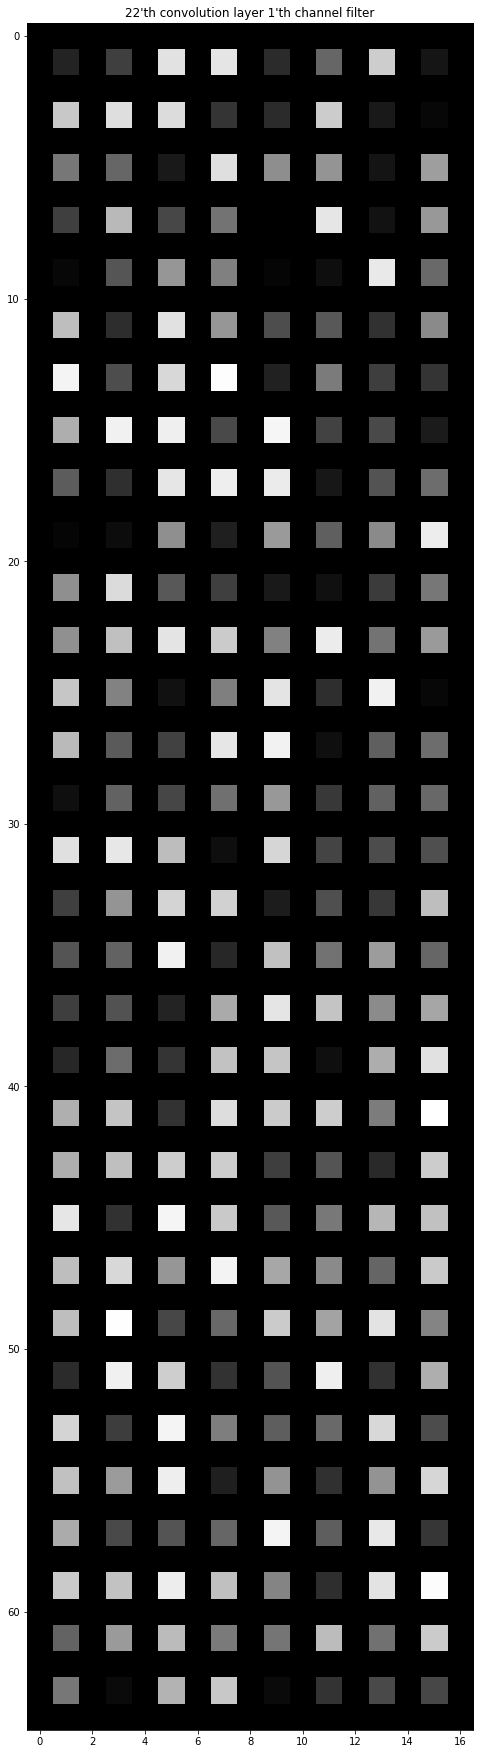

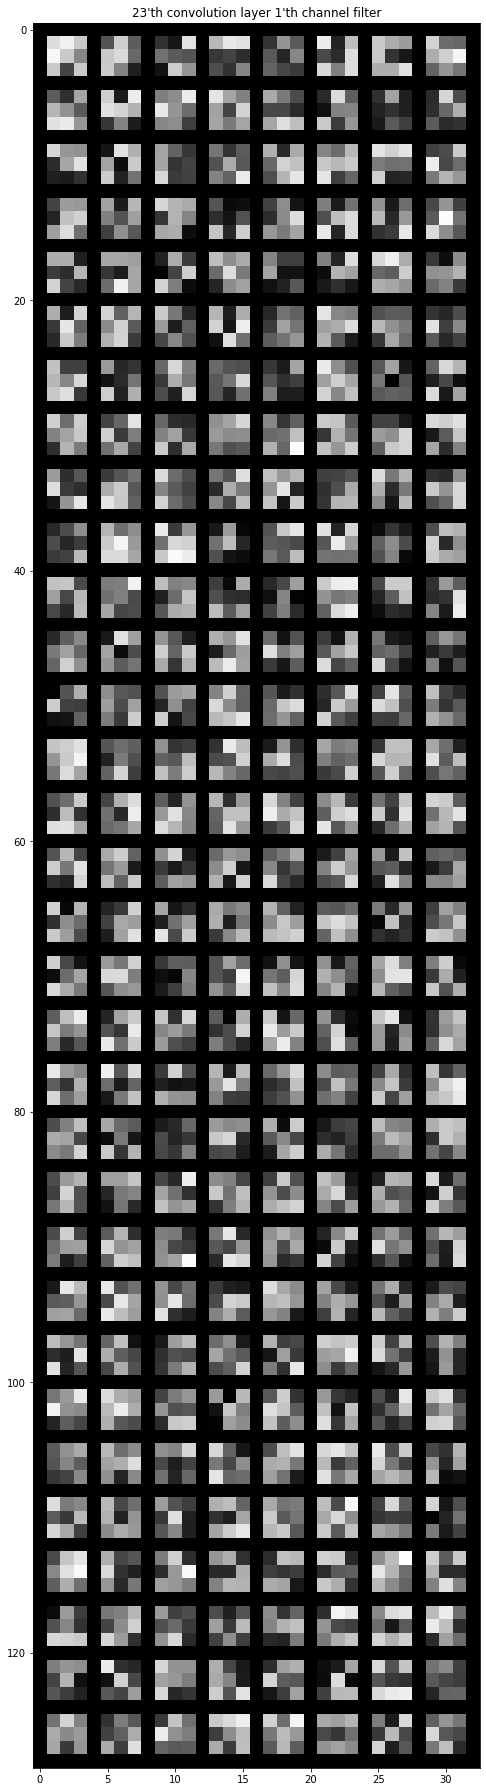

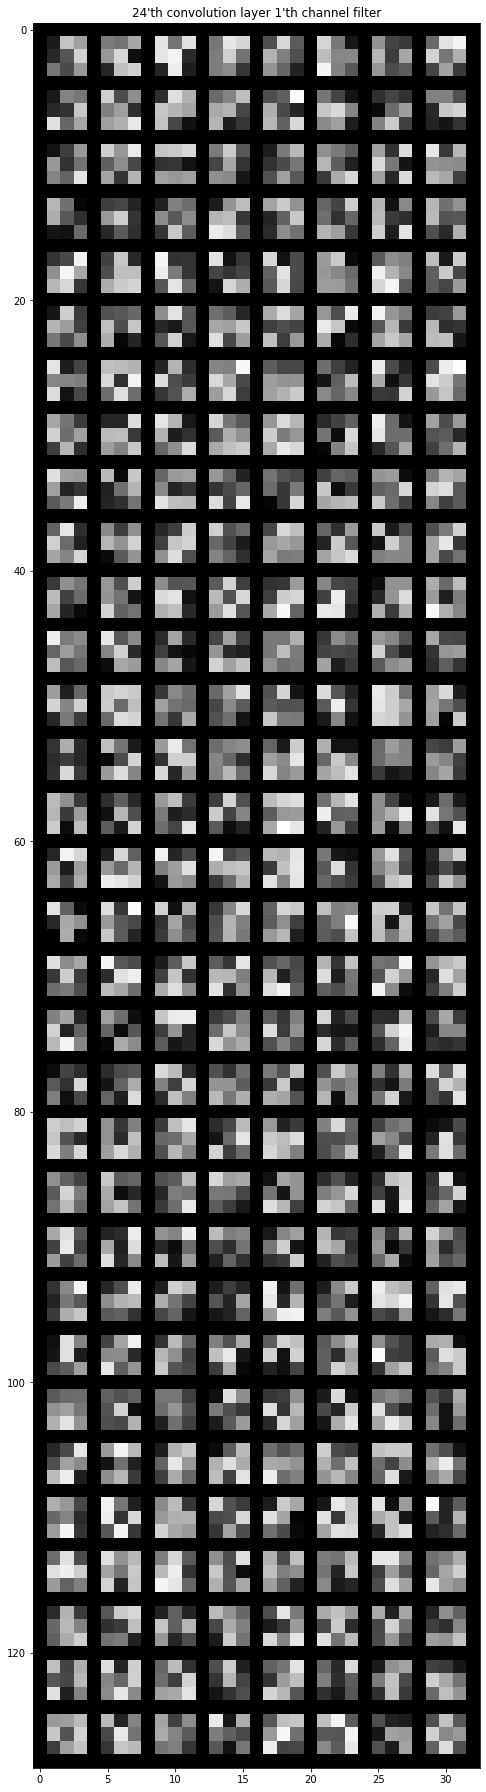

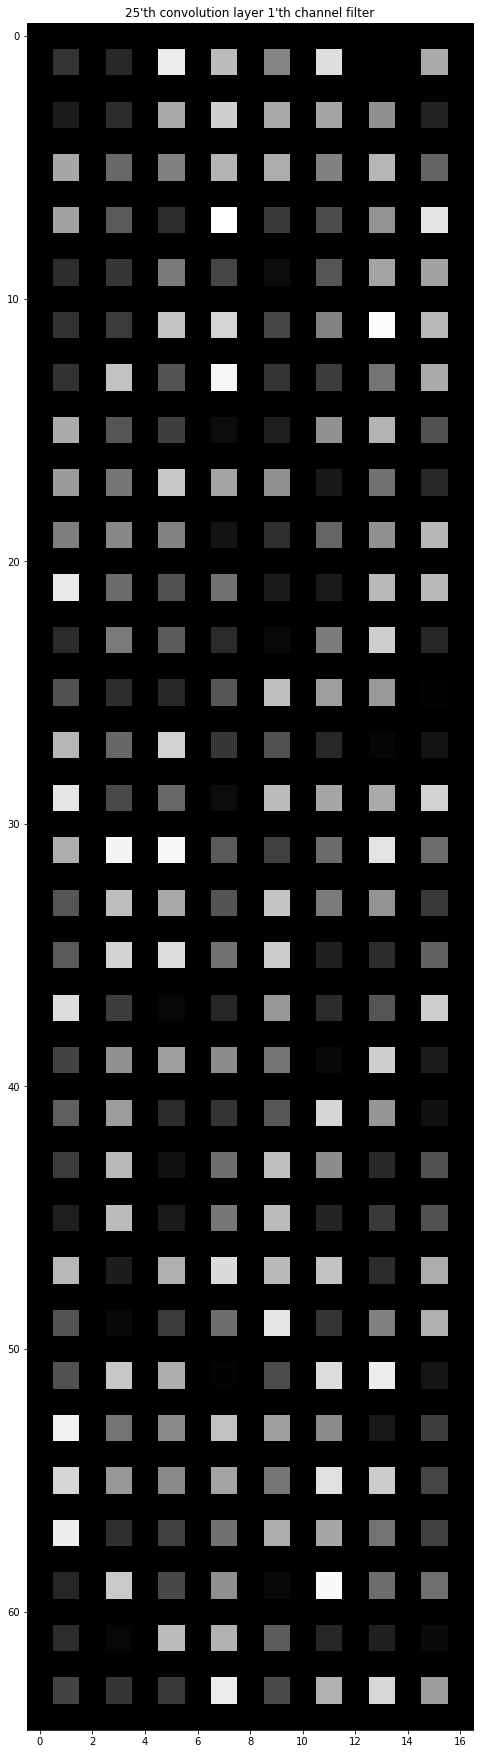

In [ ]:
for n, weight in enumerate(filter_map):
  ch = 0
  weight=weight.cpu()
  visTensor(weight, ch=0, allkernels=False)
  plt.title(f'{n+1}\'th convolution layer {ch+1}\'th channel filter')

In [ ]:
# simple_model(test_dataset[0][0][1].to(device))
simple_model.eval()
for batch_idx, (batch_data, batch_label) in enumerate(train_loader):

    spec, mfcc, chroma = batch_data
    mfcc= mfcc.to(device)
    # batch_data = (spec, mfcc, chroma)
    batch_label = batch_label.to(device)
    
    pred = simple_model(mfcc)
    print(pred)
    _, pred_indices = torch.max(pred, axis=1)
    batch_label = torch.max(batch_label, axis=1)[1]

    print(pred_indices,batch_label)

    break

tensor([[-0.6281, -1.7702, -1.3691,  3.8973, -0.8039],
        [-0.6858, -1.8173, -1.3975,  4.0314, -0.8493],
        [-0.7148, -1.8367, -1.4078,  4.0921, -0.8731],
        [-0.6851, -1.8136, -1.3987,  4.0309, -0.8524],
        [-0.6877, -1.8207, -1.4005,  4.0398, -0.8495],
        [-0.6395, -1.7824, -1.3804,  3.9332, -0.8108],
        [-0.6890, -1.8143, -1.3984,  4.0338, -0.8502],
        [-0.6423, -1.7796, -1.3773,  3.9320, -0.8179],
        [-0.6574, -1.7892, -1.3814,  3.9572, -0.8221],
        [-0.6856, -1.8219, -1.4018,  4.0427, -0.8547],
        [-0.6181, -1.7672, -1.3689,  3.8815, -0.7909],
        [-0.6314, -1.7762, -1.3752,  3.9117, -0.8007],
        [-0.6963, -1.8172, -1.4012,  4.0485, -0.8560],
        [-0.6287, -1.7742, -1.3759,  3.9114, -0.8071],
        [-0.6731, -1.8132, -1.3988,  4.0202, -0.8454],
        [-0.6973, -1.8262, -1.4081,  4.0672, -0.8626],
        [-0.6381, -1.7814, -1.3800,  3.9328, -0.8164],
        [-0.6534, -1.7847, -1.3808,  3.9494, -0.8205],
        [-

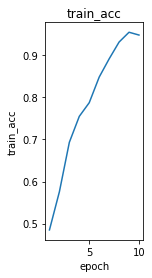

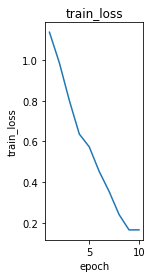

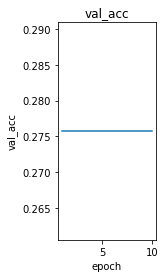

In [ ]:
plt.subplot(1,3,1)
simple_model.plot('train_acc')

plt.subplot(1,3,2)
simple_model.plot('train_loss')

plt.subplot(1,3,3)
simple_model.plot('val_acc')

plt.show()

In [ ]:
for batch_idx, (batch_data, batch_label) in enumerate(LeNet_train_loader):
    spec, mfcc, chroma = batch_data
    # batch_data = (spec, mfcc, chroma)
    batch_label = batch_label.to(device)
    break
print(batch_label)

tensor([[0., 0., 0., 1., 0.]], device='cuda:0')


In [ ]:
train_dataset[0]

((tensor([[[0.5878, 0.0000, 0.1682,  ..., 0.0000, 0.3653, 0.6681],
           [0.6845, 0.4730, 0.5001,  ..., 0.2274, 0.2419, 0.6734],
           [0.8021, 0.6136, 0.8162,  ..., 0.4442, 0.5468, 0.7488],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1176],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1172],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1169]]]),
  tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [0.9244, 0.8967, 0.9064,  ..., 0.6991, 0.6840, 0.7472],
           ...,
           [0.9012, 0.8843, 0.8820,  ..., 0.7083, 0.7085, 0.7249],
           [0.9007, 0.8827, 0.8806,  ..., 0.7078, 0.7095, 0.7234],
           [0.9018, 0.8848, 0.8787,  ..., 0.7113, 0.7075, 0.7187]]]),
  tensor([[[0.8707, 0.2385, 0.4482,  ..., 0.4420, 0.9651, 0.3952],
           [1.0000, 0.9564, 0.1924,  ..., 1.0000, 0.6207, 0.2616],
           [0.7693, 0.96

# LSTM

In [ ]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM,self).__init__()

        self.hidden_size=64
        self.num_layers=1
        self.input_size=100  #mfcc 기준

        self.lstm=nn.LSTM(input_size=self.input_size,hidden_size=self.hidden_size, num_layers =self.num_layers,batch_first=True)
        self.linear=nn.Linear(32064,5) # mfcc 기준 # hidden -> 지역 개수
        self.softmax=nn.Softmax(dim=1)

        self.loss=nn.CrossEntropyLoss()
        self.optimizer=optim.Adam(self.parameters(),lr=0.005)

    def forward(self,x):
        x = x.reshape(x.shape[0],-1,x.shape[3]) # 16,100,501 = (batch size, 100, 501)
        x = x.view(x.shape[0],x.shape[2],-1) # 16,501,100 = (batch size, sequence len, input size)
        
        #Initial hidden state
        h_0 = torch.zeros((self.num_layers, x.shape[0], self.hidden_size)).to(device=device)
        #Initial cell state
        c_0 = torch.zeros((self.num_layers, x.shape[0], self.hidden_size)).to(device=device)
        
        y, (h_n,c_n) =self.lstm(x,(h_0,c_0))
        
        y = y.reshape(y.shape[0],-1) # y = (batch size, sequence len * hidden_size)
        y = self.linear(y)
        y = self.softmax(y)

        return y

    def train_(self,train_loader, val_loader, epochs, device):
        self.train_accuracy = []
        self.train_loss = []
        self.val_accuracy = []
        self.val_loss = []
        best_epoch = -1
        best_acc = -1 
        
        for epoch in range(1, epochs+1):
            total = 0
            correct = 0
            start_time = time.time()
            epoch_loss = 0.0
            epoch_acc = 0.0
            self.train()

            for batch_idx, (batch_data, batch_label) in enumerate(tqdm(train_loader)):
                
                spec, mfcc, chroma = batch_data
                mfcc= mfcc.to(device)
                # batch_data = (spec, mfcc, chroma)
                batch_label = batch_label.to(device)
                
                self.optimizer.zero_grad()

                pred = self.forward(mfcc) # (batch_size, 5)
                loss = self.loss(pred, batch_label)
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()

                _, pred_indices = torch.max(pred, axis=1)
                total += batch_data[0].shape[0]
                label = torch.max(batch_label, axis=1)[1]
                correct += pred_indices.eq(label).sum().item()
                # for p, l in zip(pred_indices, batch_label):
                #     print(f"predicted: {index2region[p.item()]} real:{index2region[l.item()]}")
            
            print(pred,batch_label) ############################################################################
            end_time = time.time()
            print(f"epoch {epoch} time: {end_time-start_time}sec(s).")


            epoch_loss /= len(train_loader)
            self.train_loss.append(epoch_loss)
            epoch_acc = correct / total
            self.train_accuracy.append(epoch_acc)
            print(f"epoch {epoch} train accuracy: {epoch_acc}")
            print(f"epoch {epoch} loss: {epoch_loss}")  


            predicted, labels, val_loss = self.predict(val_loader, device)
            
            val_acc = predicted.eq(labels).sum().item() / len(predicted)
            print(f"epoch {epoch} val accuracy: {val_acc}")

            if val_acc > epoch_acc:
                best_acc = val_acc
                best_epoch = epoch
                torch.save(self.state_dict(), self.best_model_save_path)
            
            self.val_accuracy.append(val_acc)
            self.val_loss.append(val_loss)
            
            
            
        print("Finish!")
        
        return best_acc, best_epoch
            
    def predict(self, test_loader, device):
        self.eval()
        labels = []
        predicted = []
        val_loss = 0.0
        with torch.no_grad():
            for batch_idx, (batch_data, batch_label) in enumerate(tqdm(test_loader)):

                spec, mfcc, chroma = batch_data
                mfcc= mfcc.to(device)
                # batch_data = (spec, mfcc, chroma)
                batch_label = batch_label.to(device)
                
                pred = self.forward(mfcc)

                _, pred_indices = torch.max(pred, axis=1)
                loss = self.loss(pred, batch_label)
                
                val_loss += loss.item()

                predicted.append(pred_indices)
                batch_label = torch.max(batch_label, axis=1)[1]
                labels.append(batch_label)
            print(pred,batch_label) ############################################################################
        val_loss /= len(test_loader)
        predicted = torch.cat(predicted, dim=0)
        labels = torch.cat(labels, dim=0)

        return predicted, labels, val_loss



In [ ]:
train_size = int(len(dataset)*0.8)
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset,batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=16, shuffle=True)

In [ ]:
lstm_model=LSTM().to(device)

lstm_model.train_(train_loader,test_loader,10,device)

100%|██████████| 75/75 [00:28<00:00,  2.65it/s]


tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.]])
epoch 1 ti

100%|██████████| 19/19 [00:01<00:00, 11.53it/s]


tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]]) tensor([3, 4, 4, 2, 3, 1, 4, 1, 1, 0, 3, 3, 3])
epoch 1 val accuracy: 0.2159468438538206


100%|██████████| 75/75 [00:18<00:00,  4.15it/s]


tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]], grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.]])
epoch 2 ti

100%|██████████| 19/19 [00:01<00:00, 11.37it/s]


tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]]) tensor([2, 0, 1, 0, 1, 4, 1, 1, 3, 0, 0, 0, 4])
epoch 2 val accuracy: 0.2159468438538206


100%|██████████| 75/75 [00:17<00:00,  4.39it/s]


tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]], grad_fn=<SoftmaxBackward0>) tensor([[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.]])
epoch 3 ti

100%|██████████| 19/19 [00:01<00:00, 11.53it/s]


tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]]) tensor([4, 4, 4, 2, 2, 0, 1, 3, 0, 3, 4, 2, 3])
epoch 3 val accuracy: 0.2159468438538206


100%|██████████| 75/75 [00:17<00:00,  4.37it/s]


tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.]])
epoch 4 ti

100%|██████████| 19/19 [00:01<00:00, 11.40it/s]


tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]]) tensor([1, 0, 3, 2, 4, 2, 1, 2, 4, 3, 0, 0, 2])
epoch 4 val accuracy: 0.2159468438538206


100%|██████████| 75/75 [00:17<00:00,  4.37it/s]


tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]], grad_fn=<SoftmaxBackward0>) tensor([[0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.]])
epoch 5 ti

100%|██████████| 19/19 [00:01<00:00, 11.40it/s]


tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]]) tensor([2, 1, 0, 2, 0, 0, 1, 4, 4, 2, 4, 1, 0])
epoch 5 val accuracy: 0.2159468438538206


100%|██████████| 75/75 [00:17<00:00,  4.35it/s]


tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]], grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.]])
epoch 6 ti

100%|██████████| 19/19 [00:01<00:00, 11.64it/s]


tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]]) tensor([0, 0, 2, 4, 3, 3, 4, 0, 1, 2, 4, 0, 4])
epoch 6 val accuracy: 0.2159468438538206


100%|██████████| 75/75 [00:17<00:00,  4.37it/s]


tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.]])
epoch 7 ti

100%|██████████| 19/19 [00:01<00:00, 11.26it/s]


tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]]) tensor([1, 3, 3, 4, 4, 4, 3, 3, 3, 0, 2, 3, 0])
epoch 7 val accuracy: 0.2159468438538206


100%|██████████| 75/75 [00:17<00:00,  4.33it/s]


tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])
epoch 8 ti

100%|██████████| 19/19 [00:01<00:00, 11.41it/s]


tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]]) tensor([2, 2, 0, 3, 1, 2, 2, 0, 1, 3, 3, 1, 0])
epoch 8 val accuracy: 0.2159468438538206


100%|██████████| 75/75 [00:17<00:00,  4.34it/s]


tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.]])
epoch 9 ti

100%|██████████| 19/19 [00:01<00:00, 11.24it/s]


tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]]) tensor([1, 2, 1, 3, 1, 3, 2, 2, 4, 4, 4, 3, 0])
epoch 9 val accuracy: 0.2159468438538206


100%|██████████| 75/75 [00:17<00:00,  4.27it/s]


tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])
epoch 10 t

100%|██████████| 19/19 [00:01<00:00, 11.32it/s]

tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]]) tensor([0, 2, 1, 3, 2, 1, 0, 3, 3, 0, 0, 2, 1])
epoch 10 val accuracy: 0.2159468438538206
Finish!


(-1, -1)

# DNN

In [ ]:
class MLP(nn.Module):
    def __init__(self,best_model_save_path="./best_model.pt"):
        super(MLP,self).__init__()
        
        self.best_model_save_path = best_model_save_path
        
        self.linear=nn.Linear(50100,5) #mfcc 기준
        self.softmax=nn.Softmax(dim=1)
        self.layer=nn.Sequential(self.linear,self.softmax)

        self.optimizer=optim.SGD(self.parameters(),lr=0.0001)
        self.loss = nn.CrossEntropyLoss()
        # nn.MultiMarginLoss() -> SVM 과 유사함 /// 현재는 확률적으로 나타내고 있기 때문에 불필요

    def forward(self,x):
        x=x.view(x.shape[0],-1) # (batch size, other wise) -> flatten
        y=self.layer(x)
        
        return y
    
    def train_(self,train_loader, val_loader, epochs, device):
        self.train_accuracy = []
        self.train_loss = []
        self.val_accuracy = []
        self.val_loss = []
        best_epoch = -1
        best_acc = -1 
        
        for epoch in range(1, epochs+1):
            total = 0
            correct = 0
            start_time = time.time()
            epoch_loss = 0.0
            epoch_acc = 0.0
            self.train()

            for batch_idx, (batch_data, batch_label) in enumerate(tqdm(train_loader)):
                
                spec, mfcc, chroma = batch_data
                mfcc= mfcc.to(device)
                # batch_data = (spec, mfcc, chroma)
                batch_label = batch_label.to(device)
                
                self.optimizer.zero_grad()

                pred = self.forward(mfcc) # (batch_size, 5)
                loss = self.loss(pred, batch_label)
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()

                _, pred_indices = torch.max(pred, axis=1)
                total += batch_data[0].shape[0]
                label = torch.max(batch_label, axis=1)[1]
                correct += pred_indices.eq(label).sum().item()
                # for p, l in zip(pred_indices, batch_label):
                #     print(f"predicted: {index2region[p.item()]} real:{index2region[l.item()]}")
            
            print(pred,batch_label) ############################################################################
            end_time = time.time()
            print(f"epoch {epoch} time: {end_time-start_time}sec(s).")


            epoch_loss /= len(train_loader)
            self.train_loss.append(epoch_loss)
            epoch_acc = correct / total
            self.train_accuracy.append(epoch_acc)
            print(f"epoch {epoch} train accuracy: {epoch_acc}")
            print(f"epoch {epoch} loss: {epoch_loss}")  


            predicted, labels, val_loss = self.predict(val_loader, device)
            
            val_acc = predicted.eq(labels).sum().item() / len(predicted)
            print(f"epoch {epoch} val accuracy: {val_acc}")

            if val_acc > epoch_acc:
                best_acc = val_acc
                best_epoch = epoch
                torch.save(self.state_dict(), self.best_model_save_path)
            
            self.val_accuracy.append(val_acc)
            self.val_loss.append(val_loss)
            
            
            
        print("Finish!")
        
        return best_acc, best_epoch
            
    def predict(self, test_loader, device):
        self.eval()
        labels = []
        predicted = []
        val_loss = 0.0
        with torch.no_grad():
            for batch_idx, (batch_data, batch_label) in enumerate(tqdm(test_loader)):

                spec, mfcc, chroma = batch_data
                mfcc= mfcc.to(device)
                # batch_data = (spec, mfcc, chroma)
                batch_label = batch_label.to(device)
                
                pred = self.forward(mfcc)

                _, pred_indices = torch.max(pred, axis=1)
                loss = self.loss(pred, batch_label)
                
                val_loss += loss.item()

                predicted.append(pred_indices)
                batch_label = torch.max(batch_label, axis=1)[1]
                labels.append(batch_label)
            print(pred,batch_label) ############################################################################
        val_loss /= len(test_loader)
        predicted = torch.cat(predicted, dim=0)
        labels = torch.cat(labels, dim=0)

        return predicted, labels, val_loss

    def plot(self, which):
        
        X = [i for i in range(1, len(self.train_accuracy) + 1)]
        if which=='train_loss':
            y = self.train_loss
        elif which=='train_acc':
            y = self.train_accuracy
        elif which=='val_acc':
            y = self.val_accuracy
        elif which=='val_loss':
            y = self.val_loss

        plt.xlabel("epoch")
        plt.ylabel(which)
        plt.title(which)
        plt.plot(X, y, label="Train loss")
        plt.savefig(f"./mlp_model_{which}.png")
        plt.show()





In [ ]:
mlp_model=MLP().to(device)

mlp_train_loader = DataLoader(cross_val_train[0], shuffle=True)
mlp_test_loader = DataLoader(cross_val_test[0], shuffle=True)

mlp_model.train_(mlp_train_loader,mlp_test_loader,10,device)

100%|██████████| 1200/1200 [00:03<00:00, 310.18it/s]


tensor([[0.6364, 0.0465, 0.0923, 0.1545, 0.0703]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>) tensor([[0., 1., 0., 0., 0.]], device='cuda:0')
epoch 1 time: 3.8768749237060547sec(s).
epoch 1 train accuracy: 0.19916666666666666
epoch 1 loss: 1.6330032188693682


100%|██████████| 301/301 [00:00<00:00, 357.03it/s]


tensor([[0.5803, 0.0594, 0.1010, 0.1807, 0.0786]], device='cuda:0') tensor([1], device='cuda:0')
epoch 1 val accuracy: 0.22259136212624583


100%|██████████| 1200/1200 [00:03<00:00, 309.17it/s]


tensor([[0.8769, 0.0304, 0.0215, 0.0342, 0.0371]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]], device='cuda:0')
epoch 2 time: 3.889162540435791sec(s).
epoch 2 train accuracy: 0.23416666666666666
epoch 2 loss: 1.6178899824619293


100%|██████████| 301/301 [00:00<00:00, 386.12it/s]


tensor([[0.8549, 0.0354, 0.0250, 0.0428, 0.0419]], device='cuda:0') tensor([1], device='cuda:0')
epoch 2 val accuracy: 0.22259136212624583


100%|██████████| 1200/1200 [00:03<00:00, 309.41it/s]


tensor([[0.1332, 0.0181, 0.3381, 0.4509, 0.0597]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]], device='cuda:0')
epoch 3 time: 3.8894591331481934sec(s).
epoch 3 train accuracy: 0.2375
epoch 3 loss: 1.6105428106089432


100%|██████████| 301/301 [00:00<00:00, 402.01it/s]


tensor([[0.1620, 0.0207, 0.1823, 0.5816, 0.0534]], device='cuda:0') tensor([4], device='cuda:0')
epoch 3 val accuracy: 0.2059800664451827


100%|██████████| 1200/1200 [00:03<00:00, 316.98it/s]


tensor([[0.0861, 0.0559, 0.1378, 0.5653, 0.1549]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>) tensor([[0., 1., 0., 0., 0.]], device='cuda:0')
epoch 4 time: 3.7948696613311768sec(s).
epoch 4 train accuracy: 0.2425
epoch 4 loss: 1.6118029901385307


100%|██████████| 301/301 [00:00<00:00, 368.64it/s]


tensor([[0.1940, 0.0896, 0.1931, 0.3402, 0.1831]], device='cuda:0') tensor([0], device='cuda:0')
epoch 4 val accuracy: 0.2159468438538206


100%|██████████| 1200/1200 [00:03<00:00, 309.38it/s]


tensor([[0.6198, 0.0455, 0.1245, 0.1667, 0.0434]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>) tensor([[0., 1., 0., 0., 0.]], device='cuda:0')
epoch 5 time: 3.8874382972717285sec(s).
epoch 5 train accuracy: 0.26916666666666667
epoch 5 loss: 1.5970571394264699


100%|██████████| 301/301 [00:00<00:00, 410.14it/s]


tensor([[0.7106, 0.0343, 0.1005, 0.1194, 0.0352]], device='cuda:0') tensor([2], device='cuda:0')
epoch 5 val accuracy: 0.26245847176079734


100%|██████████| 1200/1200 [00:03<00:00, 314.80it/s]


tensor([[0.8097, 0.0531, 0.0476, 0.0638, 0.0258]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]], device='cuda:0')
epoch 6 time: 3.823946714401245sec(s).
epoch 6 train accuracy: 0.2633333333333333
epoch 6 loss: 1.5946068440377712


100%|██████████| 301/301 [00:00<00:00, 376.47it/s]


tensor([[0.7244, 0.0558, 0.0604, 0.1177, 0.0418]], device='cuda:0') tensor([0], device='cuda:0')
epoch 6 val accuracy: 0.22591362126245848


100%|██████████| 1200/1200 [00:03<00:00, 309.17it/s]


tensor([[0.6595, 0.1167, 0.0497, 0.0926, 0.0816]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>) tensor([[0., 1., 0., 0., 0.]], device='cuda:0')
epoch 7 time: 3.8908379077911377sec(s).
epoch 7 train accuracy: 0.26666666666666666
epoch 7 loss: 1.5902016238868237


100%|██████████| 301/301 [00:00<00:00, 371.22it/s]


tensor([[0.6133, 0.1781, 0.0529, 0.0858, 0.0698]], device='cuda:0') tensor([1], device='cuda:0')
epoch 7 val accuracy: 0.2558139534883721


100%|██████████| 1200/1200 [00:03<00:00, 316.17it/s]


tensor([[0.7434, 0.0715, 0.0618, 0.0960, 0.0273]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]], device='cuda:0')
epoch 8 time: 3.805372714996338sec(s).
epoch 8 train accuracy: 0.2733333333333333
epoch 8 loss: 1.5899772931138674


100%|██████████| 301/301 [00:00<00:00, 412.18it/s]


tensor([[0.3228, 0.0836, 0.0857, 0.4317, 0.0761]], device='cuda:0') tensor([3], device='cuda:0')
epoch 8 val accuracy: 0.26245847176079734


100%|██████████| 1200/1200 [00:03<00:00, 319.20it/s]


tensor([[0.0532, 0.0374, 0.0653, 0.7777, 0.0664]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]], device='cuda:0')
epoch 9 time: 3.7684435844421387sec(s).
epoch 9 train accuracy: 0.2866666666666667
epoch 9 loss: 1.5837490443388622


100%|██████████| 301/301 [00:00<00:00, 409.53it/s]


tensor([[0.0235, 0.0351, 0.0690, 0.8170, 0.0554]], device='cuda:0') tensor([0], device='cuda:0')
epoch 9 val accuracy: 0.21926910299003322


100%|██████████| 1200/1200 [00:03<00:00, 323.64it/s]


tensor([[0.0155, 0.0105, 0.0183, 0.9402, 0.0155]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]], device='cuda:0')
epoch 10 time: 3.718161106109619sec(s).
epoch 10 train accuracy: 0.28833333333333333
epoch 10 loss: 1.5816354781885942


100%|██████████| 301/301 [00:00<00:00, 402.94it/s]

tensor([[0.1853, 0.0277, 0.0510, 0.7081, 0.0278]], device='cuda:0') tensor([1], device='cuda:0')
epoch 10 val accuracy: 0.21262458471760798
Finish!


(0.22259136212624583, 1)

In [ ]:
mlp_model=MLP().to(device)

mlp_train_loader = DataLoader(train_dataset, shuffle=True)
mlp_test_loader = DataLoader(test_dataset, shuffle=True)

mlp_model.train_(mlp_train_loader,mlp_test_loader,200,device)

100%|██████████| 1200/1200 [00:05<00:00, 222.62it/s]


tensor([[0.2780, 0.1165, 0.1081, 0.1305, 0.3669]], grad_fn=<SoftmaxBackward0>) tensor([[0., 1., 0., 0., 0.]])
epoch 1 time: 5.40123724937439sec(s).
epoch 1 train accuracy: 0.24
epoch 1 loss: 1.619920257826646


100%|██████████| 301/301 [00:00<00:00, 337.59it/s]


tensor([[0.2269, 0.1745, 0.1154, 0.1621, 0.3211]]) tensor([4])
epoch 1 val accuracy: 0.18272425249169436


100%|██████████| 1200/1200 [00:05<00:00, 238.29it/s]


tensor([[0.5476, 0.0338, 0.1508, 0.2001, 0.0676]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 2 time: 5.043555974960327sec(s).
epoch 2 train accuracy: 0.23333333333333334
epoch 2 loss: 1.6225083711246648


100%|██████████| 301/301 [00:00<00:00, 354.92it/s]


tensor([[0.4144, 0.0486, 0.1786, 0.2968, 0.0616]]) tensor([3])
epoch 2 val accuracy: 0.3089700996677741


100%|██████████| 1200/1200 [00:05<00:00, 236.67it/s]


tensor([[0.0628, 0.0352, 0.0555, 0.0310, 0.8155]], grad_fn=<SoftmaxBackward0>) tensor([[0., 1., 0., 0., 0.]])
epoch 3 time: 5.076821804046631sec(s).
epoch 3 train accuracy: 0.23
epoch 3 loss: 1.6163635677595933


100%|██████████| 301/301 [00:01<00:00, 296.22it/s]


tensor([[0.0929, 0.0416, 0.0638, 0.0304, 0.7713]]) tensor([0])
epoch 3 val accuracy: 0.17275747508305647


100%|██████████| 1200/1200 [00:04<00:00, 250.95it/s]


tensor([[0.8543, 0.0133, 0.0231, 0.0741, 0.0352]], grad_fn=<SoftmaxBackward0>) tensor([[0., 1., 0., 0., 0.]])
epoch 4 time: 4.791872978210449sec(s).
epoch 4 train accuracy: 0.22666666666666666
epoch 4 loss: 1.6166700999935468


100%|██████████| 301/301 [00:00<00:00, 351.39it/s]


tensor([[0.8056, 0.0218, 0.0363, 0.0855, 0.0508]]) tensor([3])
epoch 4 val accuracy: 0.2159468438538206


100%|██████████| 1200/1200 [00:05<00:00, 217.10it/s]


tensor([[0.6539, 0.0460, 0.0440, 0.1894, 0.0667]], grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 5 time: 5.538612127304077sec(s).
epoch 5 train accuracy: 0.23916666666666667
epoch 5 loss: 1.6106969717144966


100%|██████████| 301/301 [00:00<00:00, 370.55it/s]


tensor([[0.9528, 0.0105, 0.0118, 0.0144, 0.0105]]) tensor([1])
epoch 5 val accuracy: 0.2159468438538206


100%|██████████| 1200/1200 [00:04<00:00, 256.06it/s]


tensor([[0.4981, 0.0399, 0.0597, 0.1542, 0.2481]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.]])
epoch 6 time: 4.699404001235962sec(s).
epoch 6 train accuracy: 0.25583333333333336
epoch 6 loss: 1.600843818038702


100%|██████████| 301/301 [00:00<00:00, 340.41it/s]


tensor([[0.5137, 0.0344, 0.0506, 0.0783, 0.3229]]) tensor([4])
epoch 6 val accuracy: 0.2425249169435216


100%|██████████| 1200/1200 [00:05<00:00, 231.55it/s]


tensor([[0.1264, 0.0858, 0.0712, 0.1508, 0.5657]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.]])
epoch 7 time: 5.192244052886963sec(s).
epoch 7 train accuracy: 0.24583333333333332
epoch 7 loss: 1.5953273277481397


100%|██████████| 301/301 [00:00<00:00, 331.86it/s]


tensor([[0.1118, 0.0501, 0.0491, 0.0945, 0.6944]]) tensor([4])
epoch 7 val accuracy: 0.17275747508305647


100%|██████████| 1200/1200 [00:04<00:00, 246.98it/s]


tensor([[0.5106, 0.0423, 0.0813, 0.1992, 0.1666]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 8 time: 4.867388725280762sec(s).
epoch 8 train accuracy: 0.25416666666666665
epoch 8 loss: 1.599892976284027


100%|██████████| 301/301 [00:00<00:00, 345.38it/s]


tensor([[0.0855, 0.0353, 0.0811, 0.5442, 0.2539]]) tensor([4])
epoch 8 val accuracy: 0.3089700996677741


100%|██████████| 1200/1200 [00:04<00:00, 243.77it/s]


tensor([[0.1294, 0.0727, 0.0254, 0.0536, 0.7189]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 9 time: 4.932298183441162sec(s).
epoch 9 train accuracy: 0.2841666666666667
epoch 9 loss: 1.5874136618773143


100%|██████████| 301/301 [00:00<00:00, 321.16it/s]


tensor([[0.1614, 0.0804, 0.0292, 0.0684, 0.6606]]) tensor([1])
epoch 9 val accuracy: 0.19601328903654486


100%|██████████| 1200/1200 [00:05<00:00, 231.79it/s]


tensor([[0.9731, 0.0096, 0.0079, 0.0033, 0.0061]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.]])
epoch 10 time: 5.185387372970581sec(s).
epoch 10 train accuracy: 0.2808333333333333
epoch 10 loss: 1.5882895177602767


100%|██████████| 301/301 [00:00<00:00, 305.90it/s]


tensor([[0.9690, 0.0115, 0.0091, 0.0062, 0.0042]]) tensor([3])
epoch 10 val accuracy: 0.2159468438538206


100%|██████████| 1200/1200 [00:05<00:00, 229.71it/s]


tensor([[0.8916, 0.0218, 0.0197, 0.0142, 0.0527]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.]])
epoch 11 time: 5.2362329959869385sec(s).
epoch 11 train accuracy: 0.2725
epoch 11 loss: 1.5849304655690988


100%|██████████| 301/301 [00:00<00:00, 336.72it/s]


tensor([[0.8839, 0.0189, 0.0182, 0.0180, 0.0610]]) tensor([0])
epoch 11 val accuracy: 0.25249169435215946


100%|██████████| 1200/1200 [00:05<00:00, 202.32it/s]


tensor([[0.7049, 0.1058, 0.0424, 0.1164, 0.0306]], grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 12 time: 5.939873218536377sec(s).
epoch 12 train accuracy: 0.2608333333333333
epoch 12 loss: 1.5825775841871896


100%|██████████| 301/301 [00:00<00:00, 322.97it/s]


tensor([[0.7054, 0.0881, 0.0429, 0.1185, 0.0451]]) tensor([2])
epoch 12 val accuracy: 0.2823920265780731


100%|██████████| 1200/1200 [00:05<00:00, 226.99it/s]


tensor([[0.2668, 0.0739, 0.3161, 0.2577, 0.0856]], grad_fn=<SoftmaxBackward0>) tensor([[0., 1., 0., 0., 0.]])
epoch 13 time: 5.300451040267944sec(s).
epoch 13 train accuracy: 0.29
epoch 13 loss: 1.5779763408998648


100%|██████████| 301/301 [00:00<00:00, 321.07it/s]


tensor([[0.0368, 0.0543, 0.1346, 0.6763, 0.0980]]) tensor([3])
epoch 13 val accuracy: 0.32558139534883723


100%|██████████| 1200/1200 [00:05<00:00, 218.80it/s]


tensor([[0.0669, 0.2241, 0.0409, 0.5632, 0.1049]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 14 time: 5.49458384513855sec(s).
epoch 14 train accuracy: 0.275
epoch 14 loss: 1.5816762232283752


100%|██████████| 301/301 [00:01<00:00, 289.64it/s]


tensor([[0.0613, 0.1095, 0.0310, 0.7092, 0.0889]]) tensor([2])
epoch 14 val accuracy: 0.31893687707641194


100%|██████████| 1200/1200 [00:05<00:00, 215.75it/s]


tensor([[0.4413, 0.1106, 0.0328, 0.2606, 0.1547]], grad_fn=<SoftmaxBackward0>) tensor([[0., 1., 0., 0., 0.]])
epoch 15 time: 5.571886777877808sec(s).
epoch 15 train accuracy: 0.2725
epoch 15 loss: 1.5774492526054382


100%|██████████| 301/301 [00:01<00:00, 288.14it/s]


tensor([[0.2446, 0.1980, 0.0412, 0.3918, 0.1244]]) tensor([3])
epoch 15 val accuracy: 0.2823920265780731


100%|██████████| 1200/1200 [00:05<00:00, 225.43it/s]


tensor([[0.0324, 0.0294, 0.0709, 0.5315, 0.3358]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 16 time: 5.332404613494873sec(s).
epoch 16 train accuracy: 0.30666666666666664
epoch 16 loss: 1.5663211954136689


100%|██████████| 301/301 [00:00<00:00, 302.90it/s]


tensor([[0.4575, 0.0663, 0.1547, 0.2082, 0.1133]]) tensor([0])
epoch 16 val accuracy: 0.2757475083056478


100%|██████████| 1200/1200 [00:06<00:00, 190.93it/s]


tensor([[0.7388, 0.0244, 0.0283, 0.1919, 0.0166]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 17 time: 6.297412872314453sec(s).
epoch 17 train accuracy: 0.2925
epoch 17 loss: 1.573682706008355


100%|██████████| 301/301 [00:01<00:00, 293.93it/s]


tensor([[0.7509, 0.0371, 0.0488, 0.1285, 0.0347]]) tensor([3])
epoch 17 val accuracy: 0.3222591362126246


100%|██████████| 1200/1200 [00:05<00:00, 205.22it/s]


tensor([[0.0507, 0.0323, 0.1004, 0.7097, 0.1069]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 18 time: 5.857854127883911sec(s).
epoch 18 train accuracy: 0.3
epoch 18 loss: 1.565526531090339


100%|██████████| 301/301 [00:00<00:00, 319.57it/s]


tensor([[0.0808, 0.0366, 0.1452, 0.6512, 0.0862]]) tensor([3])
epoch 18 val accuracy: 0.3222591362126246


100%|██████████| 1200/1200 [00:05<00:00, 223.18it/s]


tensor([[0.2334, 0.0614, 0.0669, 0.5832, 0.0551]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.]])
epoch 19 time: 5.389020204544067sec(s).
epoch 19 train accuracy: 0.2825
epoch 19 loss: 1.5665683620671431


100%|██████████| 301/301 [00:00<00:00, 356.47it/s]


tensor([[0.3073, 0.0751, 0.0797, 0.4423, 0.0955]]) tensor([2])
epoch 19 val accuracy: 0.3023255813953488


100%|██████████| 1200/1200 [00:05<00:00, 224.21it/s]


tensor([[0.1787, 0.0936, 0.0404, 0.5805, 0.1068]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 20 time: 5.3625404834747314sec(s).
epoch 20 train accuracy: 0.295
epoch 20 loss: 1.5633265241980552


100%|██████████| 301/301 [00:00<00:00, 342.18it/s]


tensor([[0.7216, 0.0646, 0.0361, 0.1665, 0.0113]]) tensor([2])
epoch 20 val accuracy: 0.33222591362126247


100%|██████████| 1200/1200 [00:05<00:00, 234.45it/s]


tensor([[0.0298, 0.0165, 0.0083, 0.9287, 0.0166]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 21 time: 5.128384113311768sec(s).
epoch 21 train accuracy: 0.3025
epoch 21 loss: 1.5642082214852173


100%|██████████| 301/301 [00:01<00:00, 288.65it/s]


tensor([[0.0408, 0.0108, 0.0073, 0.8529, 0.0882]]) tensor([0])
epoch 21 val accuracy: 0.33554817275747506


100%|██████████| 1200/1200 [00:05<00:00, 229.48it/s]


tensor([[0.0377, 0.1442, 0.0672, 0.3316, 0.4192]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.]])
epoch 22 time: 5.2404396533966064sec(s).
epoch 22 train accuracy: 0.2941666666666667
epoch 22 loss: 1.5598170792559782


100%|██████████| 301/301 [00:01<00:00, 279.70it/s]


tensor([[0.3107, 0.0690, 0.0543, 0.3776, 0.1883]]) tensor([0])
epoch 22 val accuracy: 0.3289036544850498


100%|██████████| 1200/1200 [00:04<00:00, 243.93it/s]


tensor([[0.5578, 0.1046, 0.0416, 0.0940, 0.2020]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 23 time: 4.927749156951904sec(s).
epoch 23 train accuracy: 0.3175
epoch 23 loss: 1.5546273233989873


100%|██████████| 301/301 [00:01<00:00, 298.95it/s]


tensor([[0.0677, 0.0457, 0.0263, 0.1864, 0.6737]]) tensor([1])
epoch 23 val accuracy: 0.25249169435215946


100%|██████████| 1200/1200 [00:05<00:00, 220.55it/s]


tensor([[0.2922, 0.0685, 0.0351, 0.5702, 0.0340]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 24 time: 5.453744173049927sec(s).
epoch 24 train accuracy: 0.30416666666666664
epoch 24 loss: 1.5571245951453845


100%|██████████| 301/301 [00:01<00:00, 288.28it/s]


tensor([[0.3650, 0.0579, 0.0420, 0.4946, 0.0404]]) tensor([4])
epoch 24 val accuracy: 0.2691029900332226


100%|██████████| 1200/1200 [00:05<00:00, 218.14it/s]


tensor([[0.4948, 0.1364, 0.0233, 0.0746, 0.2709]], grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 25 time: 5.517894744873047sec(s).
epoch 25 train accuracy: 0.30833333333333335
epoch 25 loss: 1.5579478175441424


100%|██████████| 301/301 [00:00<00:00, 309.57it/s]


tensor([[0.6142, 0.1187, 0.0183, 0.0653, 0.1835]]) tensor([2])
epoch 25 val accuracy: 0.292358803986711


100%|██████████| 1200/1200 [00:05<00:00, 231.29it/s]


tensor([[0.2809, 0.1095, 0.4182, 0.0490, 0.1423]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.]])
epoch 26 time: 5.208404302597046sec(s).
epoch 26 train accuracy: 0.31583333333333335
epoch 26 loss: 1.549514538049698


100%|██████████| 301/301 [00:00<00:00, 331.05it/s]


tensor([[0.3012, 0.1556, 0.3291, 0.0752, 0.1389]]) tensor([1])
epoch 26 val accuracy: 0.3554817275747508


100%|██████████| 1200/1200 [00:04<00:00, 240.76it/s]


tensor([[0.7981, 0.0570, 0.0249, 0.0785, 0.0415]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 27 time: 4.993096828460693sec(s).
epoch 27 train accuracy: 0.3225
epoch 27 loss: 1.5498002487917741


100%|██████████| 301/301 [00:00<00:00, 358.88it/s]


tensor([[0.9573, 0.0214, 0.0074, 0.0120, 0.0019]]) tensor([0])
epoch 27 val accuracy: 0.29900332225913623


100%|██████████| 1200/1200 [00:05<00:00, 232.88it/s]


tensor([[0.0103, 0.2448, 0.0721, 0.4250, 0.2477]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.]])
epoch 28 time: 5.159601211547852sec(s).
epoch 28 train accuracy: 0.315
epoch 28 loss: 1.5513203915953637


100%|██████████| 301/301 [00:00<00:00, 339.20it/s]


tensor([[0.0147, 0.1788, 0.0684, 0.4124, 0.3257]]) tensor([3])
epoch 28 val accuracy: 0.3554817275747508


100%|██████████| 1200/1200 [00:05<00:00, 221.43it/s]


tensor([[0.9280, 0.0158, 0.0153, 0.0154, 0.0255]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.]])
epoch 29 time: 5.4277184009552sec(s).
epoch 29 train accuracy: 0.32666666666666666
epoch 29 loss: 1.549690327992042


100%|██████████| 301/301 [00:00<00:00, 331.23it/s]


tensor([[0.0168, 0.0111, 0.0093, 0.1511, 0.8117]]) tensor([3])
epoch 29 val accuracy: 0.25249169435215946


100%|██████████| 1200/1200 [00:05<00:00, 234.20it/s]


tensor([[0.0082, 0.0217, 0.0121, 0.8943, 0.0636]], grad_fn=<SoftmaxBackward0>) tensor([[0., 1., 0., 0., 0.]])
epoch 30 time: 5.135879039764404sec(s).
epoch 30 train accuracy: 0.3233333333333333
epoch 30 loss: 1.5469981901347638


100%|██████████| 301/301 [00:00<00:00, 326.89it/s]


tensor([[0.2869, 0.1293, 0.0742, 0.3862, 0.1234]]) tensor([0])
epoch 30 val accuracy: 0.3122923588039867


100%|██████████| 1200/1200 [00:05<00:00, 217.30it/s]


tensor([[0.2371, 0.2152, 0.0739, 0.2933, 0.1806]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 31 time: 5.537245035171509sec(s).
epoch 31 train accuracy: 0.3358333333333333
epoch 31 loss: 1.539913254380226


100%|██████████| 301/301 [00:00<00:00, 364.40it/s]


tensor([[0.4905, 0.1132, 0.0448, 0.2976, 0.0539]]) tensor([2])
epoch 31 val accuracy: 0.3388704318936877


100%|██████████| 1200/1200 [00:04<00:00, 243.34it/s]


tensor([[0.0844, 0.2622, 0.0230, 0.4943, 0.1361]], grad_fn=<SoftmaxBackward0>) tensor([[0., 1., 0., 0., 0.]])
epoch 32 time: 4.939127206802368sec(s).
epoch 32 train accuracy: 0.3258333333333333
epoch 32 loss: 1.537692334552606


100%|██████████| 301/301 [00:00<00:00, 338.04it/s]


tensor([[0.7394, 0.1915, 0.0097, 0.0577, 0.0017]]) tensor([2])
epoch 32 val accuracy: 0.3488372093023256


100%|██████████| 1200/1200 [00:05<00:00, 217.30it/s]


tensor([[0.2201, 0.1480, 0.0394, 0.4565, 0.1360]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.]])
epoch 33 time: 5.531756639480591sec(s).
epoch 33 train accuracy: 0.32416666666666666
epoch 33 loss: 1.5380533048510552


100%|██████████| 301/301 [00:00<00:00, 301.93it/s]


tensor([[0.0125, 0.0424, 0.0125, 0.6796, 0.2529]]) tensor([3])
epoch 33 val accuracy: 0.3920265780730897


100%|██████████| 1200/1200 [00:05<00:00, 223.36it/s]


tensor([[0.1239, 0.1395, 0.0289, 0.5091, 0.1986]], grad_fn=<SoftmaxBackward0>) tensor([[0., 1., 0., 0., 0.]])
epoch 34 time: 5.382605791091919sec(s).
epoch 34 train accuracy: 0.345
epoch 34 loss: 1.534334136992693


100%|██████████| 301/301 [00:00<00:00, 342.04it/s]


tensor([[0.4372, 0.1669, 0.0392, 0.2370, 0.1197]]) tensor([0])
epoch 34 val accuracy: 0.3554817275747508


100%|██████████| 1200/1200 [00:05<00:00, 227.74it/s]


tensor([[0.0067, 0.0731, 0.0158, 0.7756, 0.1288]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.]])
epoch 35 time: 5.278727054595947sec(s).
epoch 35 train accuracy: 0.33666666666666667
epoch 35 loss: 1.5313337796429793


100%|██████████| 301/301 [00:00<00:00, 305.26it/s]


tensor([[0.1463, 0.3235, 0.0695, 0.4126, 0.0481]]) tensor([1])
epoch 35 val accuracy: 0.3754152823920266


100%|██████████| 1200/1200 [00:05<00:00, 210.25it/s]


tensor([[0.9629, 0.0201, 0.0137, 0.0023, 0.0011]], grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 36 time: 5.721988916397095sec(s).
epoch 36 train accuracy: 0.35083333333333333
epoch 36 loss: 1.5286026244858901


100%|██████████| 301/301 [00:00<00:00, 330.65it/s]


tensor([[0.5220, 0.0960, 0.0692, 0.1584, 0.1543]]) tensor([0])
epoch 36 val accuracy: 0.30564784053156147


100%|██████████| 1200/1200 [00:05<00:00, 219.42it/s]


tensor([[0.5512, 0.1307, 0.2172, 0.0094, 0.0915]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.]])
epoch 37 time: 5.481386184692383sec(s).
epoch 37 train accuracy: 0.3408333333333333
epoch 37 loss: 1.5274111426870027


100%|██████████| 301/301 [00:01<00:00, 286.62it/s]


tensor([[0.2016, 0.2196, 0.2734, 0.2251, 0.0802]]) tensor([0])
epoch 37 val accuracy: 0.4318936877076412


100%|██████████| 1200/1200 [00:05<00:00, 206.04it/s]


tensor([[0.0116, 0.0163, 0.1434, 0.7829, 0.0459]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 38 time: 5.833292722702026sec(s).
epoch 38 train accuracy: 0.3641666666666667
epoch 38 loss: 1.5229850775996845


100%|██████████| 301/301 [00:01<00:00, 288.00it/s]


tensor([[0.1771, 0.0480, 0.3900, 0.0391, 0.3458]]) tensor([3])
epoch 38 val accuracy: 0.3754152823920266


100%|██████████| 1200/1200 [00:05<00:00, 208.84it/s]


tensor([[0.7454, 0.0810, 0.0197, 0.1218, 0.0321]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 39 time: 5.758469104766846sec(s).
epoch 39 train accuracy: 0.35083333333333333
epoch 39 loss: 1.523596661289533


100%|██████████| 301/301 [00:00<00:00, 304.07it/s]


tensor([[0.7499, 0.0751, 0.0162, 0.1550, 0.0038]]) tensor([4])
epoch 39 val accuracy: 0.3588039867109635


100%|██████████| 1200/1200 [00:05<00:00, 225.07it/s]


tensor([[0.4515, 0.0063, 0.0134, 0.5093, 0.0194]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 40 time: 5.343536853790283sec(s).
epoch 40 train accuracy: 0.36
epoch 40 loss: 1.521331938157479


100%|██████████| 301/301 [00:00<00:00, 328.85it/s]


tensor([[0.0371, 0.0109, 0.0189, 0.9074, 0.0257]]) tensor([0])
epoch 40 val accuracy: 0.32558139534883723


100%|██████████| 1200/1200 [00:05<00:00, 238.25it/s]


tensor([[0.1765, 0.4635, 0.2468, 0.0752, 0.0380]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.]])
epoch 41 time: 5.053303241729736sec(s).
epoch 41 train accuracy: 0.35333333333333333
epoch 41 loss: 1.5230841458837192


100%|██████████| 301/301 [00:00<00:00, 310.63it/s]


tensor([[5.7982e-04, 1.4932e-01, 7.1363e-02, 7.4509e-01, 3.3642e-02]]) tensor([4])
epoch 41 val accuracy: 0.3687707641196013


100%|██████████| 1200/1200 [00:05<00:00, 226.97it/s]


tensor([[0.3651, 0.2934, 0.1381, 0.1242, 0.0792]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 42 time: 5.299684762954712sec(s).
epoch 42 train accuracy: 0.3625
epoch 42 loss: 1.520467436661323


100%|██████████| 301/301 [00:00<00:00, 330.98it/s]


tensor([[0.0087, 0.0444, 0.0271, 0.6038, 0.3160]]) tensor([4])
epoch 42 val accuracy: 0.3588039867109635


100%|██████████| 1200/1200 [00:05<00:00, 208.11it/s]


tensor([[0.0245, 0.0916, 0.0376, 0.2116, 0.6346]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 43 time: 5.779160737991333sec(s).
epoch 43 train accuracy: 0.37166666666666665
epoch 43 loss: 1.5173667076726753


100%|██████████| 301/301 [00:01<00:00, 292.80it/s]


tensor([[0.3017, 0.2219, 0.0737, 0.3905, 0.0123]]) tensor([3])
epoch 43 val accuracy: 0.42524916943521596


100%|██████████| 1200/1200 [00:04<00:00, 241.66it/s]


tensor([[0.6307, 0.0907, 0.0753, 0.0994, 0.1039]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.]])
epoch 44 time: 4.977003335952759sec(s).
epoch 44 train accuracy: 0.3525
epoch 44 loss: 1.5144661339124044


100%|██████████| 301/301 [00:00<00:00, 322.58it/s]


tensor([[0.0178, 0.0469, 0.0271, 0.8899, 0.0183]]) tensor([4])
epoch 44 val accuracy: 0.3920265780730897


100%|██████████| 1200/1200 [00:05<00:00, 222.22it/s]


tensor([[0.9791, 0.0026, 0.0050, 0.0092, 0.0041]], grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 45 time: 5.411801099777222sec(s).
epoch 45 train accuracy: 0.36833333333333335
epoch 45 loss: 1.5071756620705128


100%|██████████| 301/301 [00:00<00:00, 346.56it/s]


tensor([[0.0613, 0.0076, 0.0087, 0.0449, 0.8776]]) tensor([4])
epoch 45 val accuracy: 0.2823920265780731


100%|██████████| 1200/1200 [00:05<00:00, 226.94it/s]


tensor([[0.1948, 0.1490, 0.0776, 0.1066, 0.4719]], grad_fn=<SoftmaxBackward0>) tensor([[0., 1., 0., 0., 0.]])
epoch 46 time: 5.298426389694214sec(s).
epoch 46 train accuracy: 0.37666666666666665
epoch 46 loss: 1.5092215996980667


100%|██████████| 301/301 [00:00<00:00, 344.58it/s]


tensor([[0.2164, 0.1030, 0.0385, 0.0910, 0.5511]]) tensor([4])
epoch 46 val accuracy: 0.38870431893687707


100%|██████████| 1200/1200 [00:05<00:00, 235.82it/s]


tensor([[0.0581, 0.0504, 0.0536, 0.7315, 0.1065]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 47 time: 5.097525596618652sec(s).
epoch 47 train accuracy: 0.37416666666666665
epoch 47 loss: 1.5062317135433356


100%|██████████| 301/301 [00:00<00:00, 346.23it/s]


tensor([[0.0477, 0.1024, 0.0562, 0.7843, 0.0094]]) tensor([4])
epoch 47 val accuracy: 0.30564784053156147


100%|██████████| 1200/1200 [00:05<00:00, 213.38it/s]


tensor([[0.0492, 0.1797, 0.1104, 0.6445, 0.0161]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 48 time: 5.6349053382873535sec(s).
epoch 48 train accuracy: 0.3825
epoch 48 loss: 1.5072021069129309


100%|██████████| 301/301 [00:00<00:00, 342.27it/s]


tensor([[0.0138, 0.1785, 0.1405, 0.5561, 0.1110]]) tensor([3])
epoch 48 val accuracy: 0.38205980066445183


100%|██████████| 1200/1200 [00:05<00:00, 215.86it/s]


tensor([[0.6685, 0.1697, 0.1101, 0.0255, 0.0262]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.]])
epoch 49 time: 5.571146249771118sec(s).
epoch 49 train accuracy: 0.36666666666666664
epoch 49 loss: 1.505240977058808


100%|██████████| 301/301 [00:00<00:00, 344.79it/s]


tensor([[0.0446, 0.0850, 0.0567, 0.5120, 0.3017]]) tensor([3])
epoch 49 val accuracy: 0.36212624584717606


100%|██████████| 1200/1200 [00:05<00:00, 222.17it/s]


tensor([[0.0116, 0.0295, 0.0281, 0.6487, 0.2820]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 50 time: 5.413962125778198sec(s).
epoch 50 train accuracy: 0.3875
epoch 50 loss: 1.501794063101212


100%|██████████| 301/301 [00:00<00:00, 347.71it/s]


tensor([[0.4001, 0.0081, 0.0113, 0.5671, 0.0134]]) tensor([3])
epoch 50 val accuracy: 0.38870431893687707


100%|██████████| 1200/1200 [00:05<00:00, 234.45it/s]


tensor([[3.8103e-01, 5.3982e-01, 7.1778e-02, 5.0516e-04, 6.8609e-03]],
       grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 51 time: 5.134506464004517sec(s).
epoch 51 train accuracy: 0.36916666666666664
epoch 51 loss: 1.5028600107630095


100%|██████████| 301/301 [00:00<00:00, 356.11it/s]


tensor([[0.0130, 0.8809, 0.0696, 0.0033, 0.0333]]) tensor([4])
epoch 51 val accuracy: 0.4053156146179402


100%|██████████| 1200/1200 [00:04<00:00, 243.32it/s]


tensor([[0.6298, 0.0125, 0.0144, 0.3354, 0.0078]], grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 52 time: 4.939819097518921sec(s).
epoch 52 train accuracy: 0.39666666666666667
epoch 52 loss: 1.496526367564996


100%|██████████| 301/301 [00:00<00:00, 307.91it/s]


tensor([[0.0576, 0.1048, 0.0452, 0.4882, 0.3042]]) tensor([2])
epoch 52 val accuracy: 0.4053156146179402


100%|██████████| 1200/1200 [00:05<00:00, 231.60it/s]


tensor([[0.1881, 0.1657, 0.1015, 0.1255, 0.4192]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 53 time: 5.189965486526489sec(s).
epoch 53 train accuracy: 0.39
epoch 53 loss: 1.4938210178911686


100%|██████████| 301/301 [00:00<00:00, 311.86it/s]


tensor([[0.1829, 0.2738, 0.1439, 0.1273, 0.2721]]) tensor([1])
epoch 53 val accuracy: 0.4019933554817276


100%|██████████| 1200/1200 [00:05<00:00, 226.99it/s]


tensor([[0.0131, 0.0611, 0.0071, 0.9140, 0.0047]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 54 time: 5.295064926147461sec(s).
epoch 54 train accuracy: 0.40166666666666667
epoch 54 loss: 1.4958968436221283


100%|██████████| 301/301 [00:00<00:00, 321.56it/s]


tensor([[0.0680, 0.7711, 0.0553, 0.1032, 0.0023]]) tensor([1])
epoch 54 val accuracy: 0.3920265780730897


100%|██████████| 1200/1200 [00:05<00:00, 200.66it/s]


tensor([[0.0374, 0.0075, 0.0086, 0.3846, 0.5618]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.]])
epoch 55 time: 5.995544910430908sec(s).
epoch 55 train accuracy: 0.395
epoch 55 loss: 1.496664861838023


100%|██████████| 301/301 [00:01<00:00, 289.91it/s]


tensor([[0.0481, 0.0199, 0.0113, 0.7995, 0.1212]]) tensor([3])
epoch 55 val accuracy: 0.3654485049833887


100%|██████████| 1200/1200 [00:05<00:00, 225.74it/s]


tensor([[0.6264, 0.1280, 0.0415, 0.0977, 0.1064]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 56 time: 5.326772928237915sec(s).
epoch 56 train accuracy: 0.3983333333333333
epoch 56 loss: 1.488685373912255


100%|██████████| 301/301 [00:00<00:00, 322.19it/s]


tensor([[0.2227, 0.3461, 0.1121, 0.2439, 0.0752]]) tensor([3])
epoch 56 val accuracy: 0.3289036544850498


100%|██████████| 1200/1200 [00:05<00:00, 207.95it/s]


tensor([[9.1034e-01, 1.9497e-02, 1.1327e-02, 5.8332e-02, 5.0266e-04]],
       grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 57 time: 5.782941102981567sec(s).
epoch 57 train accuracy: 0.39916666666666667
epoch 57 loss: 1.4937352879345418


100%|██████████| 301/301 [00:00<00:00, 344.39it/s]


tensor([[0.3367, 0.4512, 0.0958, 0.0612, 0.0551]]) tensor([2])
epoch 57 val accuracy: 0.42857142857142855


100%|██████████| 1200/1200 [00:06<00:00, 197.96it/s]


tensor([[0.5754, 0.1201, 0.0619, 0.1741, 0.0684]], grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 58 time: 6.071451187133789sec(s).
epoch 58 train accuracy: 0.41083333333333333
epoch 58 loss: 1.482694652825594


100%|██████████| 301/301 [00:00<00:00, 340.78it/s]


tensor([[0.1247, 0.0998, 0.0478, 0.2972, 0.4304]]) tensor([3])
epoch 58 val accuracy: 0.33222591362126247


100%|██████████| 1200/1200 [00:05<00:00, 215.13it/s]


tensor([[0.9150, 0.0038, 0.0109, 0.0676, 0.0027]], grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 59 time: 5.596758127212524sec(s).
epoch 59 train accuracy: 0.4041666666666667
epoch 59 loss: 1.4861060078938801


100%|██████████| 301/301 [00:00<00:00, 320.76it/s]


tensor([[0.6872, 0.0331, 0.1019, 0.1550, 0.0228]]) tensor([4])
epoch 59 val accuracy: 0.36212624584717606


100%|██████████| 1200/1200 [00:05<00:00, 230.40it/s]


tensor([[0.0019, 0.2742, 0.3414, 0.1553, 0.2271]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 60 time: 5.2212560176849365sec(s).
epoch 60 train accuracy: 0.4041666666666667
epoch 60 loss: 1.4835103481014569


100%|██████████| 301/301 [00:01<00:00, 299.11it/s]


tensor([[0.0050, 0.0312, 0.1389, 0.7066, 0.1183]]) tensor([3])
epoch 60 val accuracy: 0.39867109634551495


100%|██████████| 1200/1200 [00:05<00:00, 230.00it/s]


tensor([[0.7425, 0.1008, 0.0128, 0.0063, 0.1376]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 61 time: 5.229536294937134sec(s).
epoch 61 train accuracy: 0.4075
epoch 61 loss: 1.4830222256978354


100%|██████████| 301/301 [00:01<00:00, 295.49it/s]


tensor([[9.3683e-01, 4.7505e-02, 8.1827e-03, 4.2916e-04, 7.0564e-03]]) tensor([4])
epoch 61 val accuracy: 0.43521594684385384


100%|██████████| 1200/1200 [00:05<00:00, 228.74it/s]


tensor([[0.0028, 0.0141, 0.0118, 0.8353, 0.1360]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.]])
epoch 62 time: 5.259071111679077sec(s).
epoch 62 train accuracy: 0.41083333333333333
epoch 62 loss: 1.4803728206455709


100%|██████████| 301/301 [00:00<00:00, 319.49it/s]


tensor([[1.3906e-01, 3.7137e-02, 1.8218e-02, 8.0526e-01, 3.2521e-04]]) tensor([0])
epoch 62 val accuracy: 0.292358803986711


100%|██████████| 1200/1200 [00:05<00:00, 219.06it/s]


tensor([[0.0699, 0.1017, 0.0677, 0.3340, 0.4266]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 63 time: 5.488687038421631sec(s).
epoch 63 train accuracy: 0.4083333333333333
epoch 63 loss: 1.479556019504865


100%|██████████| 301/301 [00:00<00:00, 308.67it/s]


tensor([[0.2365, 0.0715, 0.0374, 0.6186, 0.0360]]) tensor([3])
epoch 63 val accuracy: 0.4318936877076412


100%|██████████| 1200/1200 [00:05<00:00, 209.71it/s]


tensor([[0.0900, 0.8306, 0.0292, 0.0362, 0.0140]], grad_fn=<SoftmaxBackward0>) tensor([[0., 1., 0., 0., 0.]])
epoch 64 time: 5.729735374450684sec(s).
epoch 64 train accuracy: 0.4066666666666667
epoch 64 loss: 1.4781143562992414


100%|██████████| 301/301 [00:00<00:00, 321.56it/s]


tensor([[1.3342e-01, 8.3974e-01, 1.8209e-02, 7.9645e-03, 6.6028e-04]]) tensor([4])
epoch 64 val accuracy: 0.31893687707641194


100%|██████████| 1200/1200 [00:05<00:00, 234.92it/s]


tensor([[0.9407, 0.0025, 0.0038, 0.0467, 0.0062]], grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 65 time: 5.118208885192871sec(s).
epoch 65 train accuracy: 0.4266666666666667
epoch 65 loss: 1.4706541144351164


100%|██████████| 301/301 [00:00<00:00, 327.12it/s]


tensor([[0.7608, 0.0304, 0.0150, 0.1509, 0.0429]]) tensor([4])
epoch 65 val accuracy: 0.3554817275747508


100%|██████████| 1200/1200 [00:05<00:00, 208.83it/s]


tensor([[0.0423, 0.4555, 0.0328, 0.4442, 0.0251]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 66 time: 5.756108283996582sec(s).
epoch 66 train accuracy: 0.4166666666666667
epoch 66 loss: 1.476678550740083


100%|██████████| 301/301 [00:01<00:00, 279.53it/s]


tensor([[0.0397, 0.1746, 0.0267, 0.5702, 0.1888]]) tensor([3])
epoch 66 val accuracy: 0.3588039867109635


100%|██████████| 1200/1200 [00:06<00:00, 191.31it/s]


tensor([[0.8560, 0.1027, 0.0270, 0.0108, 0.0034]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 67 time: 6.289289951324463sec(s).
epoch 67 train accuracy: 0.42083333333333334
epoch 67 loss: 1.4762623051802317


100%|██████████| 301/301 [00:01<00:00, 259.18it/s]


tensor([[0.6380, 0.0202, 0.0095, 0.2225, 0.1098]]) tensor([0])
epoch 67 val accuracy: 0.3554817275747508


100%|██████████| 1200/1200 [00:06<00:00, 191.14it/s]


tensor([[0.1330, 0.0312, 0.0071, 0.7589, 0.0697]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 68 time: 6.2898759841918945sec(s).
epoch 68 train accuracy: 0.4216666666666667
epoch 68 loss: 1.4750494589904943


100%|██████████| 301/301 [00:00<00:00, 303.48it/s]


tensor([[0.0172, 0.0267, 0.0077, 0.4262, 0.5222]]) tensor([2])
epoch 68 val accuracy: 0.43853820598006643


100%|██████████| 1200/1200 [00:05<00:00, 204.32it/s]


tensor([[0.7202, 0.2117, 0.0317, 0.0332, 0.0031]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 69 time: 5.882208585739136sec(s).
epoch 69 train accuracy: 0.42083333333333334
epoch 69 loss: 1.470922548075517


100%|██████████| 301/301 [00:00<00:00, 303.37it/s]


tensor([[0.0598, 0.4162, 0.0362, 0.3483, 0.1396]]) tensor([1])
epoch 69 val accuracy: 0.4684385382059801


100%|██████████| 1200/1200 [00:05<00:00, 212.97it/s]


tensor([[0.2086, 0.0244, 0.0361, 0.6372, 0.0936]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 70 time: 5.646875858306885sec(s).
epoch 70 train accuracy: 0.4425
epoch 70 loss: 1.4677717632551988


100%|██████████| 301/301 [00:01<00:00, 292.67it/s]


tensor([[0.0415, 0.0884, 0.0670, 0.5983, 0.2048]]) tensor([4])
epoch 70 val accuracy: 0.44518272425249167


100%|██████████| 1200/1200 [00:05<00:00, 215.49it/s]


tensor([[0.7799, 0.0042, 0.0031, 0.2119, 0.0009]], grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 71 time: 5.586269855499268sec(s).
epoch 71 train accuracy: 0.43833333333333335
epoch 71 loss: 1.4659050161639848


100%|██████████| 301/301 [00:01<00:00, 295.40it/s]


tensor([[0.0509, 0.1899, 0.0195, 0.6209, 0.1188]]) tensor([1])
epoch 71 val accuracy: 0.4219269102990033


100%|██████████| 1200/1200 [00:05<00:00, 220.27it/s]


tensor([[5.6095e-03, 1.5711e-01, 1.0362e-02, 8.2610e-01, 8.1891e-04]],
       grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 72 time: 5.458919048309326sec(s).
epoch 72 train accuracy: 0.42916666666666664
epoch 72 loss: 1.4688631357252597


100%|██████████| 301/301 [00:01<00:00, 298.03it/s]


tensor([[0.4400, 0.3198, 0.0391, 0.1513, 0.0498]]) tensor([4])
epoch 72 val accuracy: 0.4684385382059801


100%|██████████| 1200/1200 [00:05<00:00, 203.98it/s]


tensor([[0.4270, 0.4135, 0.0287, 0.1266, 0.0042]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 73 time: 5.893383979797363sec(s).
epoch 73 train accuracy: 0.4425
epoch 73 loss: 1.4613846778372923


100%|██████████| 301/301 [00:01<00:00, 292.26it/s]


tensor([[3.2069e-01, 6.6537e-01, 1.1602e-02, 1.5756e-04, 2.1805e-03]]) tensor([2])
epoch 73 val accuracy: 0.3488372093023256


100%|██████████| 1200/1200 [00:05<00:00, 207.47it/s]


tensor([[0.5143, 0.1246, 0.1114, 0.0994, 0.1504]], grad_fn=<SoftmaxBackward0>) tensor([[0., 1., 0., 0., 0.]])
epoch 74 time: 5.799383878707886sec(s).
epoch 74 train accuracy: 0.44166666666666665
epoch 74 loss: 1.4573615216215452


100%|██████████| 301/301 [00:00<00:00, 312.83it/s]


tensor([[0.8261, 0.0878, 0.0742, 0.0071, 0.0048]]) tensor([1])
epoch 74 val accuracy: 0.3521594684385382


100%|██████████| 1200/1200 [00:05<00:00, 212.62it/s]


tensor([[0.0885, 0.6366, 0.0698, 0.1867, 0.0183]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 75 time: 5.654549598693848sec(s).
epoch 75 train accuracy: 0.42333333333333334
epoch 75 loss: 1.4638284587860106


100%|██████████| 301/301 [00:00<00:00, 336.67it/s]


tensor([[0.3117, 0.3955, 0.0252, 0.2672, 0.0004]]) tensor([3])
epoch 75 val accuracy: 0.4019933554817276


100%|██████████| 1200/1200 [00:05<00:00, 203.73it/s]


tensor([[0.0072, 0.0150, 0.0166, 0.8800, 0.0812]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 76 time: 5.901503562927246sec(s).
epoch 76 train accuracy: 0.44333333333333336
epoch 76 loss: 1.459103457281987


100%|██████████| 301/301 [00:00<00:00, 343.13it/s]


tensor([[0.0700, 0.0229, 0.0191, 0.8829, 0.0051]]) tensor([0])
epoch 76 val accuracy: 0.31561461794019935


100%|██████████| 1200/1200 [00:04<00:00, 245.90it/s]


tensor([[0.0063, 0.1342, 0.0090, 0.2678, 0.5827]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 77 time: 4.891839265823364sec(s).
epoch 77 train accuracy: 0.4633333333333333
epoch 77 loss: 1.4535399138430753


100%|██████████| 301/301 [00:00<00:00, 329.66it/s]


tensor([[0.0361, 0.3105, 0.0380, 0.5258, 0.0896]]) tensor([0])
epoch 77 val accuracy: 0.3920265780730897


100%|██████████| 1200/1200 [00:05<00:00, 231.60it/s]


tensor([[0.6290, 0.3337, 0.0303, 0.0057, 0.0013]], grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 78 time: 5.191339492797852sec(s).
epoch 78 train accuracy: 0.45
epoch 78 loss: 1.4608446033795675


100%|██████████| 301/301 [00:00<00:00, 349.60it/s]


tensor([[0.0258, 0.2016, 0.0353, 0.2756, 0.4617]]) tensor([4])
epoch 78 val accuracy: 0.4684385382059801


100%|██████████| 1200/1200 [00:05<00:00, 231.07it/s]


tensor([[0.7478, 0.1181, 0.0259, 0.0875, 0.0206]], grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 79 time: 5.201857089996338sec(s).
epoch 79 train accuracy: 0.445
epoch 79 loss: 1.4535105209052563


100%|██████████| 301/301 [00:00<00:00, 316.44it/s]


tensor([[0.1785, 0.6672, 0.0158, 0.0019, 0.1366]]) tensor([3])
epoch 79 val accuracy: 0.4684385382059801


100%|██████████| 1200/1200 [00:06<00:00, 195.58it/s]


tensor([[0.0429, 0.0603, 0.0253, 0.0671, 0.8045]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.]])
epoch 80 time: 6.1469011306762695sec(s).
epoch 80 train accuracy: 0.43333333333333335
epoch 80 loss: 1.4578513665994008


100%|██████████| 301/301 [00:01<00:00, 282.37it/s]


tensor([[0.1102, 0.0268, 0.0385, 0.3740, 0.4505]]) tensor([3])
epoch 80 val accuracy: 0.45514950166112955


100%|██████████| 1200/1200 [00:05<00:00, 222.27it/s]


tensor([[1.5325e-01, 8.0573e-01, 2.6185e-02, 1.4098e-02, 7.3621e-04]],
       grad_fn=<SoftmaxBackward0>) tensor([[0., 1., 0., 0., 0.]])
epoch 81 time: 5.412301540374756sec(s).
epoch 81 train accuracy: 0.445
epoch 81 loss: 1.4575104237596195


100%|██████████| 301/301 [00:00<00:00, 310.32it/s]


tensor([[0.0195, 0.8749, 0.0414, 0.0177, 0.0465]]) tensor([3])
epoch 81 val accuracy: 0.46179401993355484


100%|██████████| 1200/1200 [00:06<00:00, 196.16it/s]


tensor([[0.6374, 0.2584, 0.0227, 0.0056, 0.0758]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 82 time: 6.127842903137207sec(s).
epoch 82 train accuracy: 0.4525
epoch 82 loss: 1.4519638887047768


100%|██████████| 301/301 [00:01<00:00, 298.84it/s]


tensor([[0.2256, 0.5378, 0.0239, 0.0769, 0.1358]]) tensor([2])
epoch 82 val accuracy: 0.43853820598006643


100%|██████████| 1200/1200 [00:05<00:00, 201.49it/s]


tensor([[1.5467e-02, 4.4399e-03, 3.7602e-02, 9.4224e-01, 2.5512e-04]],
       grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 83 time: 5.963002443313599sec(s).
epoch 83 train accuracy: 0.4475
epoch 83 loss: 1.4527973170081774


100%|██████████| 301/301 [00:01<00:00, 297.92it/s]


tensor([[6.3133e-01, 2.0020e-01, 8.0291e-02, 8.7715e-02, 4.6885e-04]]) tensor([3])
epoch 83 val accuracy: 0.3787375415282392


100%|██████████| 1200/1200 [00:05<00:00, 219.44it/s]


tensor([[0.4038, 0.3421, 0.0435, 0.1885, 0.0221]], grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 84 time: 5.480369806289673sec(s).
epoch 84 train accuracy: 0.46166666666666667
epoch 84 loss: 1.4496516785522302


100%|██████████| 301/301 [00:01<00:00, 272.89it/s]


tensor([[0.4799, 0.1217, 0.0451, 0.2097, 0.1435]]) tensor([0])
epoch 84 val accuracy: 0.4883720930232558


100%|██████████| 1200/1200 [00:05<00:00, 201.57it/s]


tensor([[0.0382, 0.5610, 0.0703, 0.2853, 0.0452]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 85 time: 5.963359594345093sec(s).
epoch 85 train accuracy: 0.445
epoch 85 loss: 1.450685075869163


100%|██████████| 301/301 [00:00<00:00, 332.07it/s]


tensor([[0.5146, 0.1008, 0.3368, 0.0456, 0.0023]]) tensor([0])
epoch 85 val accuracy: 0.47840531561461797


100%|██████████| 1200/1200 [00:06<00:00, 195.01it/s]


tensor([[0.0352, 0.8824, 0.0679, 0.0062, 0.0082]], grad_fn=<SoftmaxBackward0>) tensor([[0., 1., 0., 0., 0.]])
epoch 86 time: 6.161837816238403sec(s).
epoch 86 train accuracy: 0.4558333333333333
epoch 86 loss: 1.4464842148125172


100%|██████████| 301/301 [00:01<00:00, 285.81it/s]


tensor([[0.6916, 0.1088, 0.0309, 0.1539, 0.0148]]) tensor([0])
epoch 86 val accuracy: 0.4219269102990033


100%|██████████| 1200/1200 [00:06<00:00, 190.48it/s]


tensor([[0.0287, 0.4862, 0.0258, 0.0129, 0.4463]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 87 time: 6.3141913414001465sec(s).
epoch 87 train accuracy: 0.46
epoch 87 loss: 1.4415518005688985


100%|██████████| 301/301 [00:00<00:00, 344.26it/s]


tensor([[2.1947e-01, 3.5917e-01, 2.7615e-02, 1.7726e-04, 3.9357e-01]]) tensor([3])
epoch 87 val accuracy: 0.3654485049833887


100%|██████████| 1200/1200 [00:06<00:00, 199.30it/s]


tensor([[1.1117e-02, 6.8198e-03, 5.6824e-04, 9.8106e-01, 4.3108e-04]],
       grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 88 time: 6.036878347396851sec(s).
epoch 88 train accuracy: 0.4525
epoch 88 loss: 1.4469694053630033


100%|██████████| 301/301 [00:00<00:00, 321.96it/s]


tensor([[0.0460, 0.0536, 0.0034, 0.8901, 0.0069]]) tensor([3])
epoch 88 val accuracy: 0.4584717607973422


100%|██████████| 1200/1200 [00:06<00:00, 195.49it/s]


tensor([[0.1435, 0.0513, 0.0162, 0.7085, 0.0805]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 89 time: 6.1481404304504395sec(s).
epoch 89 train accuracy: 0.4725
epoch 89 loss: 1.4426422062019506


100%|██████████| 301/301 [00:00<00:00, 324.86it/s]


tensor([[0.5733, 0.2344, 0.1031, 0.0308, 0.0584]]) tensor([0])
epoch 89 val accuracy: 0.4750830564784053


100%|██████████| 1200/1200 [00:05<00:00, 232.69it/s]


tensor([[0.7566, 0.1422, 0.0526, 0.0457, 0.0029]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 90 time: 5.169956922531128sec(s).
epoch 90 train accuracy: 0.4658333333333333
epoch 90 loss: 1.4421698093911013


100%|██████████| 301/301 [00:01<00:00, 281.49it/s]


tensor([[0.7378, 0.0992, 0.0611, 0.0848, 0.0171]]) tensor([2])
epoch 90 val accuracy: 0.4318936877076412


100%|██████████| 1200/1200 [00:05<00:00, 207.77it/s]


tensor([[0.7605, 0.1355, 0.0723, 0.0187, 0.0130]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 91 time: 5.796566009521484sec(s).
epoch 91 train accuracy: 0.4741666666666667
epoch 91 loss: 1.4394351510206858


100%|██████████| 301/301 [00:01<00:00, 296.34it/s]


tensor([[0.0287, 0.0995, 0.0577, 0.1788, 0.6353]]) tensor([1])
epoch 91 val accuracy: 0.4119601328903654


100%|██████████| 1200/1200 [00:06<00:00, 196.93it/s]


tensor([[0.0041, 0.0216, 0.0030, 0.0119, 0.9594]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.]])
epoch 92 time: 6.1043007373809814sec(s).
epoch 92 train accuracy: 0.45666666666666667
epoch 92 loss: 1.439553900907437


100%|██████████| 301/301 [00:00<00:00, 305.10it/s]


tensor([[0.0037, 0.0419, 0.0047, 0.7492, 0.2005]]) tensor([3])
epoch 92 val accuracy: 0.42857142857142855


100%|██████████| 1200/1200 [00:05<00:00, 211.64it/s]


tensor([[0.1221, 0.6303, 0.0281, 0.1839, 0.0357]], grad_fn=<SoftmaxBackward0>) tensor([[0., 1., 0., 0., 0.]])
epoch 93 time: 5.6785924434661865sec(s).
epoch 93 train accuracy: 0.47333333333333333
epoch 93 loss: 1.4355855771899224


100%|██████████| 301/301 [00:00<00:00, 316.31it/s]


tensor([[0.5896, 0.2975, 0.0549, 0.0192, 0.0388]]) tensor([0])
epoch 93 val accuracy: 0.38870431893687707


100%|██████████| 1200/1200 [00:05<00:00, 207.12it/s]


tensor([[0.0046, 0.0781, 0.0194, 0.8889, 0.0091]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 94 time: 5.808306932449341sec(s).
epoch 94 train accuracy: 0.46416666666666667
epoch 94 loss: 1.4371716307103635


100%|██████████| 301/301 [00:01<00:00, 286.32it/s]


tensor([[0.0611, 0.2106, 0.0299, 0.6584, 0.0401]]) tensor([1])
epoch 94 val accuracy: 0.4850498338870432


100%|██████████| 1200/1200 [00:06<00:00, 190.63it/s]


tensor([[0.0525, 0.5174, 0.0471, 0.2185, 0.1645]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 95 time: 6.303337812423706sec(s).
epoch 95 train accuracy: 0.4633333333333333
epoch 95 loss: 1.4384274261196455


100%|██████████| 301/301 [00:01<00:00, 298.08it/s]


tensor([[0.4054, 0.2507, 0.0666, 0.2751, 0.0022]]) tensor([4])
epoch 95 val accuracy: 0.47840531561461797


100%|██████████| 1200/1200 [00:05<00:00, 214.05it/s]


tensor([[0.6010, 0.2407, 0.0893, 0.0535, 0.0155]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 96 time: 5.619912385940552sec(s).
epoch 96 train accuracy: 0.46416666666666667
epoch 96 loss: 1.4389809161921343


100%|██████████| 301/301 [00:01<00:00, 295.52it/s]


tensor([[0.8899, 0.0558, 0.0334, 0.0102, 0.0107]]) tensor([0])
epoch 96 val accuracy: 0.46179401993355484


100%|██████████| 1200/1200 [00:06<00:00, 195.86it/s]


tensor([[0.0134, 0.9535, 0.0260, 0.0043, 0.0028]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 97 time: 6.1411707401275635sec(s).
epoch 97 train accuracy: 0.4825
epoch 97 loss: 1.4309866137305896


100%|██████████| 301/301 [00:01<00:00, 296.11it/s]


tensor([[0.1151, 0.2654, 0.0166, 0.5511, 0.0518]]) tensor([2])
epoch 97 val accuracy: 0.43853820598006643


100%|██████████| 1200/1200 [00:06<00:00, 194.09it/s]


tensor([[1.5278e-02, 3.9585e-03, 4.2160e-03, 9.7650e-01, 4.8525e-05]],
       grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 98 time: 6.192547559738159sec(s).
epoch 98 train accuracy: 0.4741666666666667
epoch 98 loss: 1.4334752181669077


100%|██████████| 301/301 [00:00<00:00, 304.16it/s]


tensor([[4.2366e-01, 1.8226e-01, 3.2447e-02, 3.6143e-01, 2.0856e-04]]) tensor([0])
epoch 98 val accuracy: 0.46179401993355484


100%|██████████| 1200/1200 [00:06<00:00, 191.48it/s]


tensor([[0.0353, 0.0799, 0.0085, 0.0055, 0.8707]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 99 time: 6.277483224868774sec(s).
epoch 99 train accuracy: 0.48
epoch 99 loss: 1.4355420111119748


100%|██████████| 301/301 [00:01<00:00, 281.90it/s]


tensor([[0.0139, 0.4542, 0.0145, 0.3590, 0.1584]]) tensor([1])
epoch 99 val accuracy: 0.46179401993355484


100%|██████████| 1200/1200 [00:05<00:00, 204.34it/s]


tensor([[0.2186, 0.4113, 0.0297, 0.3371, 0.0033]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 100 time: 5.886380672454834sec(s).
epoch 100 train accuracy: 0.48
epoch 100 loss: 1.431412376711766


100%|██████████| 301/301 [00:01<00:00, 279.60it/s]


tensor([[0.0344, 0.0964, 0.0181, 0.0806, 0.7705]]) tensor([4])
epoch 100 val accuracy: 0.45514950166112955


100%|██████████| 1200/1200 [00:06<00:00, 189.86it/s]


tensor([[1.4659e-02, 9.5855e-01, 1.0339e-02, 1.6304e-02, 1.4594e-04]],
       grad_fn=<SoftmaxBackward0>) tensor([[0., 1., 0., 0., 0.]])
epoch 101 time: 6.334987640380859sec(s).
epoch 101 train accuracy: 0.4716666666666667
epoch 101 loss: 1.4360763613879681


100%|██████████| 301/301 [00:01<00:00, 290.57it/s]


tensor([[0.0312, 0.5223, 0.0236, 0.4220, 0.0008]]) tensor([4])
epoch 101 val accuracy: 0.45514950166112955


100%|██████████| 1200/1200 [00:06<00:00, 186.49it/s]


tensor([[0.0099, 0.0219, 0.0116, 0.9398, 0.0167]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 102 time: 6.454611301422119sec(s).
epoch 102 train accuracy: 0.4891666666666667
epoch 102 loss: 1.4302426692843437


100%|██████████| 301/301 [00:01<00:00, 274.06it/s]


tensor([[0.6482, 0.1115, 0.0446, 0.0160, 0.1797]]) tensor([3])
epoch 102 val accuracy: 0.5016611295681063


100%|██████████| 1200/1200 [00:06<00:00, 197.59it/s]


tensor([[0.0386, 0.3979, 0.0359, 0.0323, 0.4954]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 103 time: 6.086529731750488sec(s).
epoch 103 train accuracy: 0.4741666666666667
epoch 103 loss: 1.4300416707495849


100%|██████████| 301/301 [00:01<00:00, 288.18it/s]


tensor([[0.0305, 0.6143, 0.0248, 0.2068, 0.1236]]) tensor([4])
epoch 103 val accuracy: 0.4318936877076412


100%|██████████| 1200/1200 [00:06<00:00, 188.19it/s]


tensor([[9.8087e-01, 7.0870e-03, 7.2067e-03, 4.8241e-03, 8.9700e-06]],
       grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 104 time: 6.387324094772339sec(s).
epoch 104 train accuracy: 0.48083333333333333
epoch 104 loss: 1.4307198993861676


100%|██████████| 301/301 [00:01<00:00, 294.50it/s]


tensor([[0.3438, 0.1304, 0.0792, 0.2519, 0.1948]]) tensor([0])
epoch 104 val accuracy: 0.4983388704318937


100%|██████████| 1200/1200 [00:06<00:00, 191.46it/s]


tensor([[0.1281, 0.1585, 0.0335, 0.6024, 0.0775]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 105 time: 6.281982898712158sec(s).
epoch 105 train accuracy: 0.47833333333333333
epoch 105 loss: 1.4303834321101507


100%|██████████| 301/301 [00:01<00:00, 297.81it/s]


tensor([[0.0276, 0.0434, 0.0097, 0.9014, 0.0179]]) tensor([3])
epoch 105 val accuracy: 0.48172757475083056


100%|██████████| 1200/1200 [00:06<00:00, 194.84it/s]


tensor([[0.0183, 0.1774, 0.0446, 0.0456, 0.7141]], grad_fn=<SoftmaxBackward0>) tensor([[0., 1., 0., 0., 0.]])
epoch 106 time: 6.172465801239014sec(s).
epoch 106 train accuracy: 0.4825
epoch 106 loss: 1.4263611833751202


100%|██████████| 301/301 [00:01<00:00, 275.24it/s]


tensor([[0.0189, 0.0076, 0.0036, 0.9606, 0.0094]]) tensor([3])
epoch 106 val accuracy: 0.4119601328903654


100%|██████████| 1200/1200 [00:06<00:00, 195.04it/s]


tensor([[0.1323, 0.5881, 0.0875, 0.1330, 0.0591]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 107 time: 6.160262584686279sec(s).
epoch 107 train accuracy: 0.49333333333333335
epoch 107 loss: 1.4220232512553532


100%|██████████| 301/301 [00:01<00:00, 275.34it/s]


tensor([[0.4990, 0.0918, 0.0552, 0.3174, 0.0366]]) tensor([0])
epoch 107 val accuracy: 0.4883720930232558


100%|██████████| 1200/1200 [00:06<00:00, 188.81it/s]


tensor([[0.0014, 0.0687, 0.0027, 0.8793, 0.0478]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 108 time: 6.365347385406494sec(s).
epoch 108 train accuracy: 0.48583333333333334
epoch 108 loss: 1.4255551527440549


100%|██████████| 301/301 [00:01<00:00, 279.39it/s]


tensor([[8.5397e-03, 9.7592e-01, 1.0025e-02, 5.4117e-03, 1.0148e-04]]) tensor([2])
epoch 108 val accuracy: 0.39867109634551495


100%|██████████| 1200/1200 [00:06<00:00, 188.85it/s]


tensor([[0.0945, 0.2106, 0.0528, 0.1644, 0.4776]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 109 time: 6.372818231582642sec(s).
epoch 109 train accuracy: 0.49666666666666665
epoch 109 loss: 1.416855987161398


100%|██████████| 301/301 [00:01<00:00, 284.00it/s]


tensor([[0.0182, 0.0149, 0.0078, 0.3460, 0.6131]]) tensor([1])
epoch 109 val accuracy: 0.4584717607973422


100%|██████████| 1200/1200 [00:06<00:00, 186.55it/s]


tensor([[0.1519, 0.2213, 0.3577, 0.1004, 0.1687]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 110 time: 6.442724704742432sec(s).
epoch 110 train accuracy: 0.49416666666666664
epoch 110 loss: 1.4197244029740492


100%|██████████| 301/301 [00:01<00:00, 267.40it/s]


tensor([[0.3071, 0.0350, 0.4011, 0.1869, 0.0699]]) tensor([0])
epoch 110 val accuracy: 0.5049833887043189


100%|██████████| 1200/1200 [00:06<00:00, 196.38it/s]


tensor([[0.3274, 0.3885, 0.0315, 0.1692, 0.0834]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 111 time: 6.124713659286499sec(s).
epoch 111 train accuracy: 0.4841666666666667
epoch 111 loss: 1.4218062710265318


100%|██████████| 301/301 [00:01<00:00, 287.35it/s]


tensor([[0.2107, 0.6859, 0.0173, 0.0826, 0.0034]]) tensor([0])
epoch 111 val accuracy: 0.4019933554817276


100%|██████████| 1200/1200 [00:06<00:00, 195.74it/s]


tensor([[1.8715e-04, 6.3286e-03, 1.6298e-03, 1.2960e-03, 9.9056e-01]],
       grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.]])
epoch 112 time: 6.154541969299316sec(s).
epoch 112 train accuracy: 0.4866666666666667
epoch 112 loss: 1.418034475048383


100%|██████████| 301/301 [00:01<00:00, 284.54it/s]


tensor([[8.2745e-01, 2.8061e-02, 6.1614e-03, 1.3788e-01, 4.4393e-04]]) tensor([3])
epoch 112 val accuracy: 0.44518272425249167


100%|██████████| 1200/1200 [00:06<00:00, 191.00it/s]


tensor([[0.4848, 0.3127, 0.0337, 0.1509, 0.0179]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.]])
epoch 113 time: 6.293344974517822sec(s).
epoch 113 train accuracy: 0.495
epoch 113 loss: 1.4183618862430254


100%|██████████| 301/301 [00:01<00:00, 278.40it/s]


tensor([[0.0188, 0.0076, 0.0043, 0.0567, 0.9126]]) tensor([4])
epoch 113 val accuracy: 0.4186046511627907


100%|██████████| 1200/1200 [00:06<00:00, 194.24it/s]


tensor([[0.0769, 0.0755, 0.8047, 0.0412, 0.0017]], grad_fn=<SoftmaxBackward0>) tensor([[0., 1., 0., 0., 0.]])
epoch 114 time: 6.189824342727661sec(s).
epoch 114 train accuracy: 0.5091666666666667
epoch 114 loss: 1.4187522887686888


100%|██████████| 301/301 [00:01<00:00, 286.64it/s]


tensor([[0.1111, 0.0479, 0.5242, 0.1915, 0.1252]]) tensor([3])
epoch 114 val accuracy: 0.43521594684385384


100%|██████████| 1200/1200 [00:06<00:00, 195.47it/s]


tensor([[0.3107, 0.0519, 0.0257, 0.2534, 0.3583]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 115 time: 6.146054029464722sec(s).
epoch 115 train accuracy: 0.5041666666666667
epoch 115 loss: 1.4146722334623336


100%|██████████| 301/301 [00:01<00:00, 274.00it/s]


tensor([[0.4526, 0.2264, 0.0549, 0.1802, 0.0859]]) tensor([1])
epoch 115 val accuracy: 0.4750830564784053


100%|██████████| 1200/1200 [00:06<00:00, 190.95it/s]


tensor([[0.0281, 0.0162, 0.1126, 0.4319, 0.4112]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 116 time: 6.298017501831055sec(s).
epoch 116 train accuracy: 0.49916666666666665
epoch 116 loss: 1.4117514466742676


100%|██████████| 301/301 [00:01<00:00, 295.29it/s]


tensor([[8.3461e-01, 5.6275e-03, 4.9558e-02, 1.0969e-01, 5.2088e-04]]) tensor([0])
epoch 116 val accuracy: 0.3754152823920266


100%|██████████| 1200/1200 [00:06<00:00, 191.40it/s]


tensor([[0.2255, 0.0177, 0.0099, 0.4350, 0.3119]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 117 time: 6.286280870437622sec(s).
epoch 117 train accuracy: 0.5066666666666667
epoch 117 loss: 1.4130994261304537


100%|██████████| 301/301 [00:01<00:00, 276.80it/s]


tensor([[0.0257, 0.0018, 0.0010, 0.9679, 0.0037]]) tensor([3])
epoch 117 val accuracy: 0.46179401993355484


100%|██████████| 1200/1200 [00:06<00:00, 191.48it/s]


tensor([[6.6746e-04, 1.2191e-02, 4.6000e-03, 9.8006e-01, 2.4833e-03]],
       grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 118 time: 6.284302711486816sec(s).
epoch 118 train accuracy: 0.5033333333333333
epoch 118 loss: 1.4132025430599848


100%|██████████| 301/301 [00:01<00:00, 278.49it/s]


tensor([[0.1308, 0.6209, 0.2332, 0.0019, 0.0132]]) tensor([2])
epoch 118 val accuracy: 0.42857142857142855


100%|██████████| 1200/1200 [00:06<00:00, 192.81it/s]


tensor([[0.2073, 0.3540, 0.0742, 0.2487, 0.1158]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 119 time: 6.23824667930603sec(s).
epoch 119 train accuracy: 0.5041666666666667
epoch 119 loss: 1.4124078477919102


100%|██████████| 301/301 [00:01<00:00, 296.14it/s]


tensor([[0.5451, 0.2335, 0.1174, 0.0936, 0.0103]]) tensor([2])
epoch 119 val accuracy: 0.45182724252491696


100%|██████████| 1200/1200 [00:06<00:00, 196.90it/s]


tensor([[2.0692e-02, 1.6487e-01, 7.9442e-01, 2.3601e-04, 1.9790e-02]],
       grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.]])
epoch 120 time: 6.111314296722412sec(s).
epoch 120 train accuracy: 0.5058333333333334
epoch 120 loss: 1.4101078014572461


100%|██████████| 301/301 [00:01<00:00, 291.93it/s]


tensor([[0.0365, 0.0448, 0.9156, 0.0010, 0.0022]]) tensor([4])
epoch 120 val accuracy: 0.3023255813953488


100%|██████████| 1200/1200 [00:06<00:00, 195.58it/s]


tensor([[0.4880, 0.2503, 0.1561, 0.0959, 0.0097]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 121 time: 6.145857572555542sec(s).
epoch 121 train accuracy: 0.5116666666666667
epoch 121 loss: 1.410657352854808


100%|██████████| 301/301 [00:00<00:00, 304.89it/s]


tensor([[0.2638, 0.3492, 0.0463, 0.2593, 0.0814]]) tensor([1])
epoch 121 val accuracy: 0.5016611295681063


100%|██████████| 1200/1200 [00:06<00:00, 187.70it/s]


tensor([[0.3493, 0.0596, 0.0288, 0.5379, 0.0243]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 122 time: 6.400990962982178sec(s).
epoch 122 train accuracy: 0.5083333333333333
epoch 122 loss: 1.4083958321809769


100%|██████████| 301/301 [00:01<00:00, 278.30it/s]


tensor([[0.3700, 0.1587, 0.3850, 0.0289, 0.0574]]) tensor([4])
epoch 122 val accuracy: 0.4883720930232558


100%|██████████| 1200/1200 [00:06<00:00, 198.08it/s]


tensor([[0.7629, 0.0908, 0.0248, 0.0310, 0.0905]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 123 time: 6.067111253738403sec(s).
epoch 123 train accuracy: 0.5066666666666667
epoch 123 loss: 1.4094390149911245


100%|██████████| 301/301 [00:00<00:00, 307.88it/s]


tensor([[9.9039e-01, 6.9106e-03, 1.9671e-03, 7.2131e-04, 6.9148e-06]]) tensor([0])
epoch 123 val accuracy: 0.4219269102990033


100%|██████████| 1200/1200 [00:06<00:00, 190.53it/s]


tensor([[9.7838e-01, 5.7842e-03, 1.2325e-02, 3.1471e-03, 3.5961e-04]],
       grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 124 time: 6.315698146820068sec(s).
epoch 124 train accuracy: 0.5008333333333334
epoch 124 loss: 1.4095810323953628


100%|██████████| 301/301 [00:01<00:00, 275.86it/s]


tensor([[0.2016, 0.6935, 0.0778, 0.0207, 0.0064]]) tensor([2])
epoch 124 val accuracy: 0.5083056478405316


100%|██████████| 1200/1200 [00:06<00:00, 189.52it/s]


tensor([[0.3661, 0.0540, 0.0289, 0.0048, 0.5462]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 125 time: 6.342838764190674sec(s).
epoch 125 train accuracy: 0.49833333333333335
epoch 125 loss: 1.4067222395042578


100%|██████████| 301/301 [00:01<00:00, 290.47it/s]


tensor([[0.0311, 0.9359, 0.0240, 0.0015, 0.0075]]) tensor([1])
epoch 125 val accuracy: 0.46511627906976744


100%|██████████| 1200/1200 [00:06<00:00, 185.43it/s]


tensor([[0.1275, 0.4793, 0.0231, 0.0993, 0.2708]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.]])
epoch 126 time: 6.481374979019165sec(s).
epoch 126 train accuracy: 0.5075
epoch 126 loss: 1.4087786982456842


100%|██████████| 301/301 [00:01<00:00, 280.67it/s]


tensor([[0.0090, 0.0057, 0.0034, 0.0632, 0.9186]]) tensor([3])
epoch 126 val accuracy: 0.46511627906976744


100%|██████████| 1200/1200 [00:06<00:00, 196.25it/s]


tensor([[0.9639, 0.0020, 0.0211, 0.0096, 0.0034]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 127 time: 6.1227617263793945sec(s).
epoch 127 train accuracy: 0.5075
epoch 127 loss: 1.4067829201122124


100%|██████████| 301/301 [00:01<00:00, 294.00it/s]


tensor([[7.5134e-01, 1.9299e-01, 5.4765e-02, 7.0664e-04, 2.0075e-04]]) tensor([0])
epoch 127 val accuracy: 0.4750830564784053


100%|██████████| 1200/1200 [00:06<00:00, 195.99it/s]


tensor([[0.8204, 0.1082, 0.0218, 0.0484, 0.0012]], grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 128 time: 6.137988328933716sec(s).
epoch 128 train accuracy: 0.5058333333333334
epoch 128 loss: 1.4086409652233123


100%|██████████| 301/301 [00:01<00:00, 285.07it/s]


tensor([[4.0100e-02, 9.3094e-01, 1.9821e-02, 8.6528e-03, 4.8175e-04]]) tensor([1])
epoch 128 val accuracy: 0.5083056478405316


100%|██████████| 1200/1200 [00:06<00:00, 198.91it/s]


tensor([[0.0486, 0.2023, 0.0251, 0.2604, 0.4635]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.]])
epoch 129 time: 6.0435471534729sec(s).
epoch 129 train accuracy: 0.5183333333333333
epoch 129 loss: 1.404620012094577


100%|██████████| 301/301 [00:00<00:00, 331.77it/s]


tensor([[0.0504, 0.0335, 0.0078, 0.3009, 0.6073]]) tensor([4])
epoch 129 val accuracy: 0.5182724252491694


100%|██████████| 1200/1200 [00:06<00:00, 194.43it/s]


tensor([[0.5148, 0.2782, 0.0372, 0.0146, 0.1551]], grad_fn=<SoftmaxBackward0>) tensor([[0., 1., 0., 0., 0.]])
epoch 130 time: 6.182039737701416sec(s).
epoch 130 train accuracy: 0.5225
epoch 130 loss: 1.4026784278949103


100%|██████████| 301/301 [00:01<00:00, 276.20it/s]


tensor([[9.1813e-04, 9.6380e-01, 1.6617e-02, 1.7094e-02, 1.5689e-03]]) tensor([4])
epoch 130 val accuracy: 0.4584717607973422


100%|██████████| 1200/1200 [00:06<00:00, 197.68it/s]


tensor([[0.0587, 0.5347, 0.0680, 0.1479, 0.1908]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 131 time: 6.084888935089111sec(s).
epoch 131 train accuracy: 0.5191666666666667
epoch 131 loss: 1.395869872669379


100%|██████████| 301/301 [00:00<00:00, 304.45it/s]


tensor([[6.7659e-01, 2.6281e-01, 5.9522e-02, 1.0416e-03, 4.5993e-05]]) tensor([0])
epoch 131 val accuracy: 0.4983388704318937


100%|██████████| 1200/1200 [00:06<00:00, 197.14it/s]


tensor([[0.8528, 0.0392, 0.0407, 0.0582, 0.0092]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 132 time: 6.108325481414795sec(s).
epoch 132 train accuracy: 0.5125
epoch 132 loss: 1.4009646348655225


100%|██████████| 301/301 [00:01<00:00, 287.01it/s]


tensor([[0.9220, 0.0187, 0.0178, 0.0206, 0.0209]]) tensor([2])
epoch 132 val accuracy: 0.45514950166112955


100%|██████████| 1200/1200 [00:06<00:00, 191.45it/s]


tensor([[0.0991, 0.8330, 0.0295, 0.0364, 0.0020]], grad_fn=<SoftmaxBackward0>) tensor([[0., 1., 0., 0., 0.]])
epoch 133 time: 6.276641845703125sec(s).
epoch 133 train accuracy: 0.535
epoch 133 loss: 1.394273012181123


100%|██████████| 301/301 [00:00<00:00, 305.56it/s]


tensor([[0.4838, 0.3441, 0.0209, 0.1383, 0.0129]]) tensor([2])
epoch 133 val accuracy: 0.5049833887043189


100%|██████████| 1200/1200 [00:06<00:00, 189.42it/s]


tensor([[7.8265e-01, 1.0701e-01, 1.0054e-01, 9.7726e-03, 3.0661e-05]],
       grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 134 time: 6.345239877700806sec(s).
epoch 134 train accuracy: 0.5175
epoch 134 loss: 1.398661715487639


100%|██████████| 301/301 [00:01<00:00, 281.78it/s]


tensor([[0.0059, 0.0221, 0.0064, 0.2372, 0.7285]]) tensor([4])
epoch 134 val accuracy: 0.5016611295681063


100%|██████████| 1200/1200 [00:06<00:00, 189.50it/s]


tensor([[0.0159, 0.0211, 0.0088, 0.9517, 0.0025]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 135 time: 6.341874837875366sec(s).
epoch 135 train accuracy: 0.5333333333333333
epoch 135 loss: 1.395753844579061


100%|██████████| 301/301 [00:01<00:00, 291.37it/s]


tensor([[1.9044e-01, 7.3886e-01, 6.3336e-02, 7.2960e-03, 6.3802e-05]]) tensor([2])
epoch 135 val accuracy: 0.4983388704318937


100%|██████████| 1200/1200 [00:06<00:00, 189.76it/s]


tensor([[0.1366, 0.6301, 0.0773, 0.1348, 0.0212]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.]])
epoch 136 time: 6.332389831542969sec(s).
epoch 136 train accuracy: 0.5225
epoch 136 loss: 1.3970921844244004


100%|██████████| 301/301 [00:01<00:00, 292.58it/s]


tensor([[0.0059, 0.0076, 0.0013, 0.9668, 0.0185]]) tensor([3])
epoch 136 val accuracy: 0.42524916943521596


100%|██████████| 1200/1200 [00:06<00:00, 192.86it/s]


tensor([[0.4302, 0.1386, 0.1045, 0.2761, 0.0507]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 137 time: 6.2316718101501465sec(s).
epoch 137 train accuracy: 0.5291666666666667
epoch 137 loss: 1.3966682089865208


100%|██████████| 301/301 [00:01<00:00, 283.98it/s]


tensor([[0.2953, 0.0066, 0.0151, 0.6786, 0.0044]]) tensor([3])
epoch 137 val accuracy: 0.48172757475083056


100%|██████████| 1200/1200 [00:06<00:00, 190.14it/s]


tensor([[0.3452, 0.0392, 0.1765, 0.1924, 0.2468]], grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 138 time: 6.319891452789307sec(s).
epoch 138 train accuracy: 0.5291666666666667
epoch 138 loss: 1.3942353761196136


100%|██████████| 301/301 [00:01<00:00, 292.51it/s]


tensor([[0.1905, 0.0374, 0.1954, 0.0927, 0.4840]]) tensor([2])
epoch 138 val accuracy: 0.4584717607973422


100%|██████████| 1200/1200 [00:06<00:00, 188.74it/s]


tensor([[0.3174, 0.3083, 0.0234, 0.0335, 0.3175]], grad_fn=<SoftmaxBackward0>) tensor([[0., 1., 0., 0., 0.]])
epoch 139 time: 6.372931718826294sec(s).
epoch 139 train accuracy: 0.5358333333333334
epoch 139 loss: 1.388659002929926


100%|██████████| 301/301 [00:01<00:00, 298.26it/s]


tensor([[0.2703, 0.6762, 0.0515, 0.0010, 0.0011]]) tensor([4])
epoch 139 val accuracy: 0.3388704318936877


100%|██████████| 1200/1200 [00:06<00:00, 184.68it/s]


tensor([[0.6452, 0.2799, 0.0601, 0.0094, 0.0053]], grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 140 time: 6.506825685501099sec(s).
epoch 140 train accuracy: 0.5183333333333333
epoch 140 loss: 1.3967301044861475


100%|██████████| 301/301 [00:01<00:00, 296.42it/s]


tensor([[0.4926, 0.0145, 0.0211, 0.4657, 0.0061]]) tensor([3])
epoch 140 val accuracy: 0.4750830564784053


100%|██████████| 1200/1200 [00:06<00:00, 194.64it/s]


tensor([[0.3016, 0.4661, 0.0588, 0.0706, 0.1030]], grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 141 time: 6.176749229431152sec(s).
epoch 141 train accuracy: 0.525
epoch 141 loss: 1.3916996446748575


100%|██████████| 301/301 [00:01<00:00, 280.72it/s]


tensor([[0.0940, 0.7864, 0.1030, 0.0150, 0.0015]]) tensor([1])
epoch 141 val accuracy: 0.521594684385382


100%|██████████| 1200/1200 [00:06<00:00, 192.63it/s]


tensor([[4.5953e-01, 1.8819e-02, 8.6286e-04, 5.2078e-01, 1.5309e-05]],
       grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 142 time: 6.24170708656311sec(s).
epoch 142 train accuracy: 0.535
epoch 142 loss: 1.3926816600064436


100%|██████████| 301/301 [00:01<00:00, 283.36it/s]


tensor([[0.0482, 0.0293, 0.0064, 0.3158, 0.6004]]) tensor([4])
epoch 142 val accuracy: 0.5282392026578073


100%|██████████| 1200/1200 [00:06<00:00, 189.08it/s]


tensor([[8.9524e-03, 5.1984e-04, 4.6718e-04, 9.9004e-01, 1.7601e-05]],
       grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 143 time: 6.355990171432495sec(s).
epoch 143 train accuracy: 0.5258333333333334
epoch 143 loss: 1.3923957125842572


100%|██████████| 301/301 [00:01<00:00, 286.83it/s]


tensor([[7.4902e-01, 2.2323e-01, 2.6952e-02, 6.5341e-04, 1.4456e-04]]) tensor([2])
epoch 143 val accuracy: 0.4750830564784053


100%|██████████| 1200/1200 [00:06<00:00, 194.62it/s]


tensor([[0.8970, 0.0498, 0.0337, 0.0146, 0.0049]], grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 144 time: 6.182757139205933sec(s).
epoch 144 train accuracy: 0.5341666666666667
epoch 144 loss: 1.3927235952516397


100%|██████████| 301/301 [00:01<00:00, 272.77it/s]


tensor([[2.0172e-01, 6.8621e-01, 1.0981e-01, 1.9115e-03, 3.4838e-04]]) tensor([2])
epoch 144 val accuracy: 0.5149501661129569


100%|██████████| 1200/1200 [00:06<00:00, 193.22it/s]


tensor([[7.0126e-03, 2.9401e-03, 3.9635e-03, 9.8605e-01, 3.7668e-05]],
       grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 145 time: 6.2226080894470215sec(s).
epoch 145 train accuracy: 0.53
epoch 145 loss: 1.3891906579832236


100%|██████████| 301/301 [00:01<00:00, 280.46it/s]


tensor([[0.1827, 0.6686, 0.1425, 0.0041, 0.0021]]) tensor([2])
epoch 145 val accuracy: 0.45182724252491696


100%|██████████| 1200/1200 [00:06<00:00, 191.26it/s]


tensor([[0.0847, 0.6450, 0.2567, 0.0128, 0.0008]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 146 time: 6.2874438762664795sec(s).
epoch 146 train accuracy: 0.5358333333333334
epoch 146 loss: 1.3874086399376393


100%|██████████| 301/301 [00:01<00:00, 275.80it/s]


tensor([[0.1562, 0.1533, 0.2199, 0.4028, 0.0678]]) tensor([2])
epoch 146 val accuracy: 0.4850498338870432


100%|██████████| 1200/1200 [00:06<00:00, 198.88it/s]


tensor([[0.1900, 0.2009, 0.0982, 0.2578, 0.2531]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 147 time: 6.043792724609375sec(s).
epoch 147 train accuracy: 0.5408333333333334
epoch 147 loss: 1.3886632099747658


100%|██████████| 301/301 [00:01<00:00, 283.76it/s]


tensor([[0.1152, 0.1552, 0.0429, 0.5485, 0.1384]]) tensor([2])
epoch 147 val accuracy: 0.4750830564784053


100%|██████████| 1200/1200 [00:06<00:00, 190.33it/s]


tensor([[0.7040, 0.0774, 0.0198, 0.0180, 0.1809]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 148 time: 6.316591024398804sec(s).
epoch 148 train accuracy: 0.525
epoch 148 loss: 1.3862712281445662


100%|██████████| 301/301 [00:01<00:00, 271.18it/s]


tensor([[0.1319, 0.6748, 0.0575, 0.0454, 0.0904]]) tensor([4])
epoch 148 val accuracy: 0.47840531561461797


100%|██████████| 1200/1200 [00:06<00:00, 181.27it/s]


tensor([[0.0984, 0.2009, 0.0415, 0.0298, 0.6293]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 149 time: 6.632260322570801sec(s).
epoch 149 train accuracy: 0.5283333333333333
epoch 149 loss: 1.3863484077652295


100%|██████████| 301/301 [00:01<00:00, 296.58it/s]


tensor([[0.0036, 0.0741, 0.0031, 0.0970, 0.8221]]) tensor([3])
epoch 149 val accuracy: 0.42857142857142855


100%|██████████| 1200/1200 [00:06<00:00, 188.50it/s]


tensor([[3.2956e-02, 9.0290e-01, 6.1899e-02, 4.6723e-05, 2.1982e-03]],
       grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.]])
epoch 150 time: 6.375929355621338sec(s).
epoch 150 train accuracy: 0.5333333333333333
epoch 150 loss: 1.3828591594596704


100%|██████████| 301/301 [00:01<00:00, 292.86it/s]


tensor([[0.1454, 0.1428, 0.0844, 0.5345, 0.0930]]) tensor([3])
epoch 150 val accuracy: 0.42857142857142855


100%|██████████| 1200/1200 [00:06<00:00, 183.27it/s]


tensor([[0.1994, 0.2444, 0.2765, 0.1399, 0.1398]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 151 time: 6.556783676147461sec(s).
epoch 151 train accuracy: 0.535
epoch 151 loss: 1.3869917842249075


100%|██████████| 301/301 [00:01<00:00, 246.33it/s]


tensor([[0.1972, 0.4536, 0.1166, 0.1579, 0.0747]]) tensor([3])
epoch 151 val accuracy: 0.43853820598006643


100%|██████████| 1200/1200 [00:06<00:00, 191.54it/s]


tensor([[0.8555, 0.0016, 0.0125, 0.1247, 0.0057]], grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 152 time: 6.274319648742676sec(s).
epoch 152 train accuracy: 0.5375
epoch 152 loss: 1.3883477284014225


100%|██████████| 301/301 [00:01<00:00, 264.18it/s]


tensor([[0.2535, 0.1754, 0.1012, 0.2831, 0.1868]]) tensor([1])
epoch 152 val accuracy: 0.46511627906976744


100%|██████████| 1200/1200 [00:05<00:00, 201.75it/s]


tensor([[9.7961e-01, 5.0100e-03, 1.4986e-02, 3.8102e-04, 1.3580e-05]],
       grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 153 time: 5.961511135101318sec(s).
epoch 153 train accuracy: 0.5383333333333333
epoch 153 loss: 1.3865185288091502


100%|██████████| 301/301 [00:01<00:00, 283.76it/s]


tensor([[3.1121e-01, 4.5550e-01, 2.3081e-01, 2.2942e-03, 1.7743e-04]]) tensor([2])
epoch 153 val accuracy: 0.4883720930232558


100%|██████████| 1200/1200 [00:05<00:00, 208.29it/s]


tensor([[0.2161, 0.0464, 0.2234, 0.0796, 0.4345]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.]])
epoch 154 time: 5.774091720581055sec(s).
epoch 154 train accuracy: 0.5416666666666666
epoch 154 loss: 1.382153152724107


100%|██████████| 301/301 [00:00<00:00, 326.34it/s]


tensor([[0.2785, 0.0114, 0.2276, 0.0853, 0.3972]]) tensor([0])
epoch 154 val accuracy: 0.42524916943521596


100%|██████████| 1200/1200 [00:06<00:00, 191.11it/s]


tensor([[0.7238, 0.0182, 0.0055, 0.1900, 0.0625]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.]])
epoch 155 time: 6.290305852890015sec(s).
epoch 155 train accuracy: 0.5383333333333333
epoch 155 loss: 1.3842634717623392


100%|██████████| 301/301 [00:01<00:00, 300.20it/s]


tensor([[0.0174, 0.0422, 0.0138, 0.2034, 0.7232]]) tensor([1])
epoch 155 val accuracy: 0.4418604651162791


100%|██████████| 1200/1200 [00:05<00:00, 200.84it/s]


tensor([[0.6861, 0.0940, 0.2031, 0.0125, 0.0043]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 156 time: 5.98319935798645sec(s).
epoch 156 train accuracy: 0.5458333333333333
epoch 156 loss: 1.3833243690431118


100%|██████████| 301/301 [00:00<00:00, 301.40it/s]


tensor([[0.0157, 0.2685, 0.0206, 0.5032, 0.1919]]) tensor([1])
epoch 156 val accuracy: 0.4485049833887043


100%|██████████| 1200/1200 [00:06<00:00, 191.32it/s]


tensor([[1.1685e-01, 8.6022e-01, 2.1013e-02, 1.7126e-03, 2.1259e-04]],
       grad_fn=<SoftmaxBackward0>) tensor([[0., 1., 0., 0., 0.]])
epoch 157 time: 6.281095266342163sec(s).
epoch 157 train accuracy: 0.5441666666666667
epoch 157 loss: 1.3816493321458498


100%|██████████| 301/301 [00:01<00:00, 286.29it/s]


tensor([[0.7670, 0.1118, 0.0108, 0.1004, 0.0100]]) tensor([0])
epoch 157 val accuracy: 0.5083056478405316


100%|██████████| 1200/1200 [00:06<00:00, 194.08it/s]


tensor([[0.0187, 0.4134, 0.0491, 0.0035, 0.5153]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.]])
epoch 158 time: 6.198489189147949sec(s).
epoch 158 train accuracy: 0.5466666666666666
epoch 158 loss: 1.3731755562126637


100%|██████████| 301/301 [00:01<00:00, 285.83it/s]


tensor([[0.7157, 0.1203, 0.0712, 0.0829, 0.0098]]) tensor([2])
epoch 158 val accuracy: 0.5049833887043189


100%|██████████| 1200/1200 [00:06<00:00, 189.92it/s]


tensor([[0.0538, 0.2113, 0.0072, 0.7139, 0.0138]], grad_fn=<SoftmaxBackward0>) tensor([[0., 1., 0., 0., 0.]])
epoch 159 time: 6.332698345184326sec(s).
epoch 159 train accuracy: 0.5483333333333333
epoch 159 loss: 1.3813453017175197


100%|██████████| 301/301 [00:00<00:00, 304.67it/s]


tensor([[2.2447e-01, 7.4365e-01, 1.5053e-02, 1.6740e-02, 9.3074e-05]]) tensor([3])
epoch 159 val accuracy: 0.4584717607973422


100%|██████████| 1200/1200 [00:06<00:00, 192.39it/s]


tensor([[0.0153, 0.0358, 0.0024, 0.9242, 0.0223]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 160 time: 6.254443407058716sec(s).
epoch 160 train accuracy: 0.5416666666666666
epoch 160 loss: 1.3793310097853342


100%|██████████| 301/301 [00:01<00:00, 300.84it/s]


tensor([[0.0408, 0.1807, 0.0066, 0.1625, 0.6095]]) tensor([3])
epoch 160 val accuracy: 0.47840531561461797


100%|██████████| 1200/1200 [00:06<00:00, 199.86it/s]


tensor([[0.3736, 0.0867, 0.0069, 0.4928, 0.0400]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 161 time: 6.0227577686309814sec(s).
epoch 161 train accuracy: 0.55
epoch 161 loss: 1.37778038362662


100%|██████████| 301/301 [00:01<00:00, 283.60it/s]


tensor([[0.0310, 0.7782, 0.1102, 0.0114, 0.0692]]) tensor([3])
epoch 161 val accuracy: 0.5116279069767442


100%|██████████| 1200/1200 [00:06<00:00, 196.85it/s]


tensor([[0.3284, 0.0240, 0.2035, 0.1338, 0.3103]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 162 time: 6.109865665435791sec(s).
epoch 162 train accuracy: 0.5416666666666666
epoch 162 loss: 1.3761747894187768


100%|██████████| 301/301 [00:01<00:00, 296.27it/s]


tensor([[0.3278, 0.1395, 0.1684, 0.2319, 0.1324]]) tensor([2])
epoch 162 val accuracy: 0.4418604651162791


100%|██████████| 1200/1200 [00:06<00:00, 195.66it/s]


tensor([[9.7625e-01, 1.1256e-02, 8.1673e-03, 4.1905e-03, 1.3872e-04]],
       grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 163 time: 6.149142742156982sec(s).
epoch 163 train accuracy: 0.5558333333333333
epoch 163 loss: 1.375469097395738


100%|██████████| 301/301 [00:01<00:00, 286.86it/s]


tensor([[5.8078e-04, 9.8487e-01, 1.4525e-02, 2.1096e-06, 2.1645e-05]]) tensor([4])
epoch 163 val accuracy: 0.48172757475083056


100%|██████████| 1200/1200 [00:06<00:00, 195.52it/s]


tensor([[0.9115, 0.0351, 0.0205, 0.0304, 0.0025]], grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 164 time: 6.149017572402954sec(s).
epoch 164 train accuracy: 0.5525
epoch 164 loss: 1.3748565043012302


100%|██████████| 301/301 [00:01<00:00, 293.42it/s]


tensor([[3.5115e-01, 8.8643e-02, 8.2972e-03, 5.5190e-01, 1.0436e-05]]) tensor([2])
epoch 164 val accuracy: 0.4983388704318937


100%|██████████| 1200/1200 [00:06<00:00, 195.79it/s]


tensor([[0.0693, 0.3675, 0.5564, 0.0034, 0.0034]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 165 time: 6.154223442077637sec(s).
epoch 165 train accuracy: 0.5516666666666666
epoch 165 loss: 1.3742254112660885


100%|██████████| 301/301 [00:01<00:00, 291.89it/s]


tensor([[0.0716, 0.1155, 0.5343, 0.0470, 0.2316]]) tensor([4])
epoch 165 val accuracy: 0.40863787375415284


100%|██████████| 1200/1200 [00:06<00:00, 189.62it/s]


tensor([[4.7517e-03, 5.0595e-02, 9.3997e-01, 8.4939e-05, 4.5935e-03]],
       grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.]])
epoch 166 time: 6.33916163444519sec(s).
epoch 166 train accuracy: 0.5625
epoch 166 loss: 1.367420929968357


100%|██████████| 301/301 [00:00<00:00, 337.30it/s]


tensor([[0.0144, 0.2021, 0.7696, 0.0010, 0.0129]]) tensor([1])
epoch 166 val accuracy: 0.39867109634551495


100%|██████████| 1200/1200 [00:05<00:00, 200.64it/s]


tensor([[8.9486e-01, 5.1190e-02, 5.2801e-02, 1.1500e-03, 1.6728e-06]],
       grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 167 time: 5.990831613540649sec(s).
epoch 167 train accuracy: 0.5425
epoch 167 loss: 1.3736980139712494


100%|██████████| 301/301 [00:01<00:00, 279.11it/s]


tensor([[6.5674e-01, 1.9777e-01, 3.1901e-02, 1.1347e-01, 1.1832e-04]]) tensor([3])
epoch 167 val accuracy: 0.4750830564784053


100%|██████████| 1200/1200 [00:05<00:00, 202.19it/s]


tensor([[6.7817e-01, 2.7569e-02, 2.9022e-01, 2.3092e-04, 3.8127e-03]],
       grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 168 time: 5.956594705581665sec(s).
epoch 168 train accuracy: 0.5541666666666667
epoch 168 loss: 1.3723861127595107


100%|██████████| 301/301 [00:01<00:00, 292.24it/s]


tensor([[0.1781, 0.0654, 0.2009, 0.5493, 0.0063]]) tensor([3])
epoch 168 val accuracy: 0.5182724252491694


100%|██████████| 1200/1200 [00:06<00:00, 193.09it/s]


tensor([[1.8046e-01, 7.9409e-01, 2.4439e-02, 6.5401e-04, 3.5675e-04]],
       grad_fn=<SoftmaxBackward0>) tensor([[0., 1., 0., 0., 0.]])
epoch 169 time: 6.228954076766968sec(s).
epoch 169 train accuracy: 0.5525
epoch 169 loss: 1.3725232168038686


100%|██████████| 301/301 [00:01<00:00, 283.12it/s]


tensor([[2.8655e-02, 8.0034e-01, 1.5584e-01, 2.7331e-04, 1.4898e-02]]) tensor([4])
epoch 169 val accuracy: 0.5016611295681063


100%|██████████| 1200/1200 [00:06<00:00, 194.26it/s]


tensor([[0.0237, 0.1665, 0.0266, 0.5628, 0.2203]], grad_fn=<SoftmaxBackward0>) tensor([[0., 1., 0., 0., 0.]])
epoch 170 time: 6.186279773712158sec(s).
epoch 170 train accuracy: 0.5475
epoch 170 loss: 1.3713034760951996


100%|██████████| 301/301 [00:01<00:00, 294.82it/s]


tensor([[0.0989, 0.1691, 0.0889, 0.4215, 0.2216]]) tensor([3])
epoch 170 val accuracy: 0.4750830564784053


100%|██████████| 1200/1200 [00:06<00:00, 187.02it/s]


tensor([[0.0260, 0.6439, 0.1429, 0.1850, 0.0022]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.]])
epoch 171 time: 6.424741744995117sec(s).
epoch 171 train accuracy: 0.55
epoch 171 loss: 1.3730787380039693


100%|██████████| 301/301 [00:01<00:00, 283.90it/s]


tensor([[0.0437, 0.6544, 0.2817, 0.0187, 0.0015]]) tensor([4])
epoch 171 val accuracy: 0.4883720930232558


100%|██████████| 1200/1200 [00:06<00:00, 187.43it/s]


tensor([[0.0836, 0.1368, 0.3120, 0.1353, 0.3323]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 172 time: 6.416233777999878sec(s).
epoch 172 train accuracy: 0.5608333333333333
epoch 172 loss: 1.3696841003994147


100%|██████████| 301/301 [00:01<00:00, 289.31it/s]


tensor([[0.0349, 0.0724, 0.8675, 0.0024, 0.0227]]) tensor([4])
epoch 172 val accuracy: 0.45182724252491696


100%|██████████| 1200/1200 [00:06<00:00, 196.97it/s]


tensor([[0.6916, 0.1122, 0.1442, 0.0361, 0.0159]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 173 time: 6.103859186172485sec(s).
epoch 173 train accuracy: 0.5475
epoch 173 loss: 1.3725079087913037


100%|██████████| 301/301 [00:00<00:00, 302.52it/s]


tensor([[8.5614e-01, 1.2451e-02, 1.1777e-01, 1.2842e-02, 7.9321e-04]]) tensor([0])
epoch 173 val accuracy: 0.5481727574750831


100%|██████████| 1200/1200 [00:06<00:00, 194.49it/s]


tensor([[0.5798, 0.1515, 0.1549, 0.0060, 0.1078]], grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 174 time: 6.181227207183838sec(s).
epoch 174 train accuracy: 0.555
epoch 174 loss: 1.3691303209463754


100%|██████████| 301/301 [00:01<00:00, 287.73it/s]


tensor([[0.0723, 0.0970, 0.0085, 0.4124, 0.4098]]) tensor([3])
epoch 174 val accuracy: 0.49169435215946844


100%|██████████| 1200/1200 [00:06<00:00, 193.31it/s]


tensor([[0.2515, 0.0747, 0.1316, 0.2920, 0.2502]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 175 time: 6.219192743301392sec(s).
epoch 175 train accuracy: 0.555
epoch 175 loss: 1.3717515251537165


100%|██████████| 301/301 [00:01<00:00, 268.60it/s]


tensor([[0.1702, 0.4068, 0.3909, 0.0301, 0.0020]]) tensor([1])
epoch 175 val accuracy: 0.4950166112956811


100%|██████████| 1200/1200 [00:06<00:00, 185.47it/s]


tensor([[0.2745, 0.1147, 0.0316, 0.3129, 0.2662]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 176 time: 6.477769374847412sec(s).
epoch 176 train accuracy: 0.5625
epoch 176 loss: 1.3653242946664492


100%|██████████| 301/301 [00:01<00:00, 263.44it/s]


tensor([[0.0611, 0.4772, 0.0974, 0.3540, 0.0104]]) tensor([2])
epoch 176 val accuracy: 0.5083056478405316


100%|██████████| 1200/1200 [00:06<00:00, 193.48it/s]


tensor([[0.0458, 0.0866, 0.1355, 0.7229, 0.0093]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 177 time: 6.209541082382202sec(s).
epoch 177 train accuracy: 0.5558333333333333
epoch 177 loss: 1.3690967616935572


100%|██████████| 301/301 [00:01<00:00, 284.45it/s]


tensor([[4.1995e-03, 4.9138e-03, 3.3289e-03, 7.4614e-04, 9.8681e-01]]) tensor([4])
epoch 177 val accuracy: 0.521594684385382


100%|██████████| 1200/1200 [00:06<00:00, 194.65it/s]


tensor([[0.7845, 0.0112, 0.0129, 0.1036, 0.0877]], grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 178 time: 6.174330711364746sec(s).
epoch 178 train accuracy: 0.5508333333333333
epoch 178 loss: 1.3657566468417643


100%|██████████| 301/301 [00:01<00:00, 284.98it/s]


tensor([[0.1558, 0.8087, 0.0250, 0.0067, 0.0038]]) tensor([1])
epoch 178 val accuracy: 0.5049833887043189


100%|██████████| 1200/1200 [00:06<00:00, 197.73it/s]


tensor([[0.3569, 0.0364, 0.3814, 0.1205, 0.1048]], grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 179 time: 6.076877593994141sec(s).
epoch 179 train accuracy: 0.5658333333333333
epoch 179 loss: 1.3634672219554582


100%|██████████| 301/301 [00:01<00:00, 277.98it/s]


tensor([[0.0547, 0.0535, 0.1226, 0.6106, 0.1587]]) tensor([3])
epoch 179 val accuracy: 0.46179401993355484


100%|██████████| 1200/1200 [00:06<00:00, 193.68it/s]


tensor([[0.8267, 0.0740, 0.0271, 0.0708, 0.0013]], grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 180 time: 6.207484245300293sec(s).
epoch 180 train accuracy: 0.5616666666666666
epoch 180 loss: 1.3643077835440636


100%|██████████| 301/301 [00:01<00:00, 282.98it/s]


tensor([[0.1021, 0.4509, 0.0122, 0.2454, 0.1894]]) tensor([1])
epoch 180 val accuracy: 0.521594684385382


100%|██████████| 1200/1200 [00:06<00:00, 194.31it/s]


tensor([[0.0265, 0.3492, 0.0147, 0.5680, 0.0416]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 181 time: 6.187611103057861sec(s).
epoch 181 train accuracy: 0.5641666666666667
epoch 181 loss: 1.362382948299249


100%|██████████| 301/301 [00:01<00:00, 283.19it/s]


tensor([[9.9474e-05, 5.7132e-05, 2.6155e-05, 9.9982e-01, 1.0929e-07]]) tensor([3])
epoch 181 val accuracy: 0.49169435215946844


100%|██████████| 1200/1200 [00:06<00:00, 189.27it/s]


tensor([[0.6316, 0.0160, 0.2006, 0.0497, 0.1020]], grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 182 time: 6.350698471069336sec(s).
epoch 182 train accuracy: 0.5691666666666667
epoch 182 loss: 1.363268119394779


100%|██████████| 301/301 [00:01<00:00, 290.91it/s]


tensor([[0.0794, 0.0257, 0.0831, 0.0146, 0.7972]]) tensor([3])
epoch 182 val accuracy: 0.42524916943521596


100%|██████████| 1200/1200 [00:06<00:00, 188.57it/s]


tensor([[8.0494e-01, 7.7445e-02, 4.5731e-02, 8.4004e-05, 7.1799e-02]],
       grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.]])
epoch 183 time: 6.3717474937438965sec(s).
epoch 183 train accuracy: 0.5533333333333333
epoch 183 loss: 1.3644643444319566


100%|██████████| 301/301 [00:01<00:00, 292.33it/s]


tensor([[7.4515e-01, 2.0251e-01, 4.9226e-02, 2.9640e-03, 1.4811e-04]]) tensor([2])
epoch 183 val accuracy: 0.4186046511627907


100%|██████████| 1200/1200 [00:06<00:00, 182.35it/s]


tensor([[0.0204, 0.5590, 0.0304, 0.3414, 0.0489]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 184 time: 6.5966291427612305sec(s).
epoch 184 train accuracy: 0.5625
epoch 184 loss: 1.3633134571711223


100%|██████████| 301/301 [00:01<00:00, 280.20it/s]


tensor([[0.1309, 0.5867, 0.2670, 0.0066, 0.0087]]) tensor([1])
epoch 184 val accuracy: 0.42857142857142855


100%|██████████| 1200/1200 [00:06<00:00, 183.60it/s]


tensor([[9.7966e-01, 3.5102e-03, 1.1048e-02, 5.0170e-04, 5.2756e-03]],
       grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 185 time: 6.547788143157959sec(s).
epoch 185 train accuracy: 0.5691666666666667
epoch 185 loss: 1.3606474339962005


100%|██████████| 301/301 [00:01<00:00, 277.66it/s]


tensor([[8.2919e-01, 1.1140e-01, 5.8532e-02, 1.8720e-04, 6.9037e-04]]) tensor([0])
epoch 185 val accuracy: 0.4750830564784053


100%|██████████| 1200/1200 [00:06<00:00, 178.02it/s]


tensor([[0.8647, 0.0612, 0.0697, 0.0027, 0.0018]], grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 186 time: 6.757002592086792sec(s).
epoch 186 train accuracy: 0.5658333333333333
epoch 186 loss: 1.361101977576812


100%|██████████| 301/301 [00:01<00:00, 275.78it/s]


tensor([[0.2657, 0.4437, 0.2349, 0.0496, 0.0061]]) tensor([1])
epoch 186 val accuracy: 0.4684385382059801


100%|██████████| 1200/1200 [00:06<00:00, 179.57it/s]


tensor([[1.2829e-01, 1.9161e-02, 1.6041e-03, 8.5025e-01, 7.0139e-04]],
       grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 187 time: 6.696787118911743sec(s).
epoch 187 train accuracy: 0.5658333333333333
epoch 187 loss: 1.3604563483099144


100%|██████████| 301/301 [00:01<00:00, 276.77it/s]


tensor([[0.5604, 0.2250, 0.1949, 0.0179, 0.0017]]) tensor([0])
epoch 187 val accuracy: 0.521594684385382


100%|██████████| 1200/1200 [00:06<00:00, 182.37it/s]


tensor([[7.4846e-01, 1.8457e-01, 6.3699e-02, 1.0454e-04, 3.1650e-03]],
       grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 188 time: 6.588313817977905sec(s).
epoch 188 train accuracy: 0.5658333333333333
epoch 188 loss: 1.359961027354002


100%|██████████| 301/301 [00:01<00:00, 276.85it/s]


tensor([[0.2078, 0.2419, 0.1436, 0.1823, 0.2243]]) tensor([1])
epoch 188 val accuracy: 0.5083056478405316


100%|██████████| 1200/1200 [00:06<00:00, 191.98it/s]


tensor([[4.8825e-02, 4.6059e-02, 3.2779e-01, 5.7685e-01, 4.7283e-04]],
       grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.]])
epoch 189 time: 6.259020805358887sec(s).
epoch 189 train accuracy: 0.5725
epoch 189 loss: 1.35913692360123


100%|██████████| 301/301 [00:01<00:00, 268.87it/s]


tensor([[9.6723e-02, 5.3907e-03, 1.0383e-03, 8.9685e-01, 6.3885e-07]]) tensor([2])
epoch 189 val accuracy: 0.4717607973421927


100%|██████████| 1200/1200 [00:06<00:00, 181.16it/s]


tensor([[0.0442, 0.0249, 0.0083, 0.0014, 0.9212]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.]])
epoch 190 time: 6.6331706047058105sec(s).
epoch 190 train accuracy: 0.5666666666666667
epoch 190 loss: 1.3593333958586058


100%|██████████| 301/301 [00:01<00:00, 273.21it/s]


tensor([[0.1711, 0.0471, 0.0926, 0.0219, 0.6672]]) tensor([2])
epoch 190 val accuracy: 0.46511627906976744


100%|██████████| 1200/1200 [00:06<00:00, 184.27it/s]


tensor([[0.2044, 0.2679, 0.0270, 0.0603, 0.4404]], grad_fn=<SoftmaxBackward0>) tensor([[0., 1., 0., 0., 0.]])
epoch 191 time: 6.52301549911499sec(s).
epoch 191 train accuracy: 0.5733333333333334
epoch 191 loss: 1.3537973401943844


100%|██████████| 301/301 [00:01<00:00, 273.34it/s]


tensor([[0.0270, 0.9279, 0.0374, 0.0042, 0.0035]]) tensor([1])
epoch 191 val accuracy: 0.48172757475083056


100%|██████████| 1200/1200 [00:06<00:00, 198.68it/s]


tensor([[5.2026e-02, 8.4089e-01, 4.2747e-02, 6.4288e-02, 4.5099e-05]],
       grad_fn=<SoftmaxBackward0>) tensor([[0., 1., 0., 0., 0.]])
epoch 192 time: 6.047595500946045sec(s).
epoch 192 train accuracy: 0.5675
epoch 192 loss: 1.3585077538589636


100%|██████████| 301/301 [00:01<00:00, 259.64it/s]


tensor([[0.1031, 0.1108, 0.0538, 0.2443, 0.4880]]) tensor([3])
epoch 192 val accuracy: 0.47840531561461797


100%|██████████| 1200/1200 [00:06<00:00, 183.33it/s]


tensor([[0.0231, 0.0171, 0.0050, 0.8911, 0.0637]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 193 time: 6.556049108505249sec(s).
epoch 193 train accuracy: 0.565
epoch 193 loss: 1.3606571113069852


100%|██████████| 301/301 [00:01<00:00, 285.15it/s]


tensor([[0.2535, 0.2757, 0.2211, 0.2460, 0.0037]]) tensor([4])
epoch 193 val accuracy: 0.4684385382059801


100%|██████████| 1200/1200 [00:06<00:00, 193.64it/s]


tensor([[0.9281, 0.0090, 0.0327, 0.0133, 0.0169]], grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 194 time: 6.209039926528931sec(s).
epoch 194 train accuracy: 0.5816666666666667
epoch 194 loss: 1.3545448445280392


100%|██████████| 301/301 [00:00<00:00, 326.47it/s]


tensor([[0.5070, 0.0381, 0.1511, 0.1138, 0.1900]]) tensor([0])
epoch 194 val accuracy: 0.4950166112956811


100%|██████████| 1200/1200 [00:06<00:00, 186.32it/s]


tensor([[9.9467e-01, 6.7064e-04, 3.7712e-03, 8.8202e-04, 6.7116e-06]],
       grad_fn=<SoftmaxBackward0>) tensor([[1., 0., 0., 0., 0.]])
epoch 195 time: 6.454314708709717sec(s).
epoch 195 train accuracy: 0.5666666666666667
epoch 195 loss: 1.3559553029139837


100%|██████████| 301/301 [00:01<00:00, 271.51it/s]


tensor([[0.7686, 0.0233, 0.0171, 0.1235, 0.0675]]) tensor([3])
epoch 195 val accuracy: 0.4485049833887043


100%|██████████| 1200/1200 [00:06<00:00, 184.50it/s]


tensor([[0.0021, 0.0171, 0.1641, 0.0064, 0.8102]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 0., 1.]])
epoch 196 time: 6.514054298400879sec(s).
epoch 196 train accuracy: 0.5725
epoch 196 loss: 1.3554898505409558


100%|██████████| 301/301 [00:01<00:00, 274.19it/s]


tensor([[5.4833e-01, 8.1940e-03, 4.2100e-01, 2.2204e-02, 2.6821e-04]]) tensor([0])
epoch 196 val accuracy: 0.3687707641196013


100%|██████████| 1200/1200 [00:06<00:00, 186.55it/s]


tensor([[0.0870, 0.0441, 0.0212, 0.8101, 0.0375]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 197 time: 6.4520485401153564sec(s).
epoch 197 train accuracy: 0.5716666666666667
epoch 197 loss: 1.360631573398908


100%|██████████| 301/301 [00:01<00:00, 279.29it/s]


tensor([[0.1033, 0.1295, 0.0552, 0.2281, 0.4840]]) tensor([2])
epoch 197 val accuracy: 0.5182724252491694


100%|██████████| 1200/1200 [00:06<00:00, 184.23it/s]


tensor([[1.9393e-06, 2.4116e-05, 3.6592e-04, 6.4440e-05, 9.9954e-01]],
       grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 0., 1., 0.]])
epoch 198 time: 6.527681589126587sec(s).
epoch 198 train accuracy: 0.5791666666666667
epoch 198 loss: 1.3489192793269953


100%|██████████| 301/301 [00:01<00:00, 273.05it/s]


tensor([[0.8021, 0.0780, 0.0745, 0.0085, 0.0369]]) tensor([4])
epoch 198 val accuracy: 0.5448504983388704


100%|██████████| 1200/1200 [00:06<00:00, 182.03it/s]


tensor([[0.3436, 0.5721, 0.0774, 0.0061, 0.0009]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 199 time: 6.612342119216919sec(s).
epoch 199 train accuracy: 0.5741666666666667
epoch 199 loss: 1.3527664735913276


100%|██████████| 301/301 [00:01<00:00, 261.13it/s]


tensor([[0.0010, 0.0102, 0.0036, 0.0016, 0.9836]]) tensor([4])
epoch 199 val accuracy: 0.4850498338870432


100%|██████████| 1200/1200 [00:06<00:00, 176.20it/s]


tensor([[0.0639, 0.6388, 0.1589, 0.1057, 0.0327]], grad_fn=<SoftmaxBackward0>) tensor([[0., 0., 1., 0., 0.]])
epoch 200 time: 6.8209264278411865sec(s).
epoch 200 train accuracy: 0.5758333333333333
epoch 200 loss: 1.3541226177414258


100%|██████████| 301/301 [00:01<00:00, 269.30it/s]

tensor([[0.4336, 0.2412, 0.3153, 0.0051, 0.0047]]) tensor([0])
epoch 200 val accuracy: 0.5481727574750831
Finish!


(0.5481727574750831, 173)

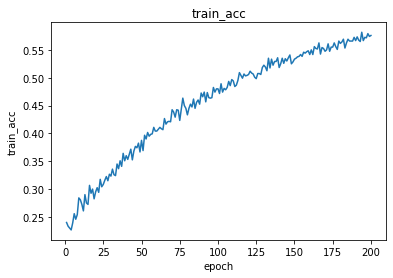

In [ ]:
mlp_model.plot('train_acc')

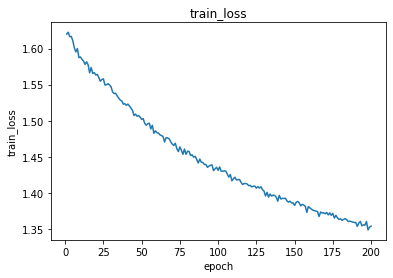

In [ ]:
mlp_model.plot('train_loss')

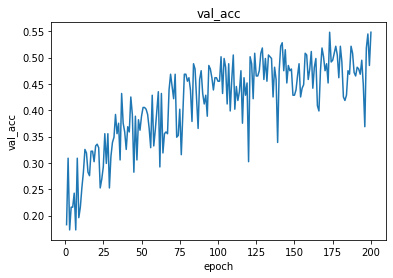

In [ ]:
mlp_model.plot('val_acc')